In [1]:
!pip -q install roboflow
!pip -q install ultralytics
! pip -q install ruamel.yaml
! wget https://github.com/ultralytics/assets/releases/download/v0.0.0/yolov8m-seg.pt

from roboflow import Roboflow
import sys
import ruamel.yaml
from ultralytics import YOLO
from pathlib import Path
import os
from collections import defaultdict
import copy
import math
import shutil
import numpy as np
import psutil
import gc
import matplotlib.pyplot as plt
import locale
from IPython.display import clear_output
import ctypes
import ctypes.util
import torch
import random


# deterministic set
torch.manual_seed(43)
random.seed(43)
np.random.seed(43)


rf = Roboflow(api_key="tD9RSesaXxGqmwVD6eVZ")
project = rf.workspace("roboarm").project("feet-qevah")
dataset = project.version(14).download("yolov8")

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyterlab 4.0.5 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
jupyterlab-lsp 5.0.0 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
jupyterlab-lsp 5.0.0 requires jupyterlab<5.0.0a0,>=4.0.6, but you have jupyterlab 4.0.5 which is incompatible.
pytoolconfig 1.2.6 requires packaging>=22.0, but you have packaging 21.3 which is incompatible.
tensorflowjs 4.13.0 requires packaging~=23.1, but you have packaging 21.3 which is incompatible.
ydata-profiling 4.5.1 requires numpy<1.24,>=1.16.0, but you have numpy 1.24.3 which is incompatible.
--2023-11-24 11:06:36--  https://github.com/ultralytics/assets/releases/download/v0.0.0/yolov8m-seg.pt
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... conn

A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3


loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.0.216, to fix: `pip install ultralytics==8.0.196`



Extracting Dataset Version Zip to feet-14 in yolov8:: 100%|██████████| 9508/9508 [00:02<00:00, 4327.18it/s]


In [2]:
%cd /kaggle/working/feet-14

# trying to optimize RAM usage
gc.enable()

libc = ctypes.CDLL(ctypes.util.find_library('c'))
libc.malloc_trim(ctypes.c_int(0))

torch.set_num_threads(1)
os.environ["OMP_NUM_THREADS"] = "1"

/kaggle/working/feet-14


In [3]:
class YoloModel:
    def __init__(self, path_to_model: str, path_to_yaml: str,
                 train_perc: float, test_perc: float, val_perc: float,
                 ttvs_flag = 0, tp_flag = 0):
        """Инициализация переменных

        Args:
            path_to_model (str): путь до весов yolov8.pt
            path_to_yaml (str): путь до data.yaml файла датасета
            train_perc (float): доля тренировочных данных 
            test_perc (float): доля тестовых данных
            val_perc (float): доля валидационных данных
        """        
        self.path_to_model = path_to_model
        self.path_to_yaml = path_to_yaml
        self.train_path = Path('train') if os.path.exists(Path('train')) else None
        self.test_path = Path('test') if os.path.exists(Path('test')) else None
        self.val_path = Path('valid') if os.path.exists(Path('valid')) else None
        self.train_perc = train_perc
        self.test_perc = test_perc
        self.val_perc = val_perc
        
        self.ttvs_flag = ttvs_flag
        self.tp_flag = tp_flag
        
        self.ram_usage = []
        
        assert self.train_path != None, 'Директория train отсутствует'
        if (self.val_path == None):
            os.mkdir("valid", mode=0o777)
            os.mkdir("valid/images", mode=0o777)
            os.mkdir("valid/labels", mode=0o777)
            self.val_path = Path("valid")
        if (self.test_path == None):
            os.mkdir("test", mode=0o777)
            os.mkdir("test/images", mode=0o777)
            os.mkdir("test/labels", mode=0o777)
            self.test_path = Path("test")
    
    def get_ram_usage(self,):
        """Gets the current RAM usage of the system.

        Returns:
            float: RAM usage in GB.
        """
        return psutil.virtual_memory().used / 1e9

    def train(self, folder_name: str, iters: int) -> YOLO: 
        """Инициализация модели и обучение

        Args:
            folder_name (str): название директории с частью данных
            iters (int): кол-во интераций

        Returns:
            YOLO: экземпляр обученной модели
        """        
        # Корректируем data.yaml файл
        yaml = ruamel.yaml.YAML()
        # yaml.preserve_quotes = True
        with open('data.yaml', 'r+') as fp:
            data = yaml.load(fp)
            for elem in data:
                if elem == 'train':
                    data[elem] = './'+folder_name+'/train/images'
                elif elem == 'val':
                    data[elem] = f"./valid_{folder_name.split('_')[1]}/images"
                elif elem == 'test':
                    data[elem] = f"./test_{folder_name.split('_')[1]}/images"
            fp.truncate(0)
            fp.seek(0)
            yaml.dump(data, fp)
        self.ram_usage.append(self.get_ram_usage())
        model = YOLO(self.path_to_model)
        model.train(
            # Random Seed parameters
            deterministic=True,
            seed=43,
            data=self.path_to_yaml, 
            pretrained=True,
            exist_ok=True,
            epochs=iters,
            optimizer="SGD",
            device=0,)
        
        return model
    
    def retrain(self, folder_name: str, iters: int,) -> YOLO:
        """Обучение модели на всех предыдущих частях данных для профилакти просадки метрики

        Args:
            folder_name (str): название директории с частью данных
            iters (int): кол-во интераций

        Returns:
            YOLO: экземпляр обученной модели
        """        
        os.mkdir("retrain", mode=0o777)
        os.mkdir("retrain/train", mode=0o777)
        os.mkdir("retrain/train/images", mode=0o777)
        os.mkdir("retrain/train/labels", mode=0o777)

        # собираем список всех кусков данных до нашего folder_name
        folder_num = np.arange(1, int(folder_name.split('_')[-1]) + 1)
        cls = folder_name.split("_")[1]
        source_pathes = [f"temp_{cls}_{i}" for i in folder_num]

        # копируем все собранные куски данных в папку retrain
        for path in source_pathes:
            # собираем все файлы
            all_images_train = os.listdir(path+"/train/images")
            all_labels_train = os.listdir(path+"/train/labels")

            for image in all_images_train:
                shutil.copyfile(path+"/train/images/" + image,
                                "retrain/train/images/" + image)
            for label in all_labels_train:
                shutil.copyfile(path+"/train/labels/" + label,
                                "retrain/train/labels/" + label)

        # Корректируем data.yaml файл
        yaml = ruamel.yaml.YAML()
        with open('data.yaml', 'r+') as fp:
            data = yaml.load(fp)
            for elem in data:
                if elem == 'train':
                    data[elem] = 'retrain/train/images'
                elif elem == 'val':
                    data[elem] = f"./valid_{folder_name.split('_')[1]}/images"
                elif elem == 'test':
                    data[elem] = f"./test_{folder_name.split('_')[1]}/images"
            fp.truncate(0)
            fp.seek(0)
            yaml.dump(data, fp)
        
        self.ram_usage.append(self.get_ram_usage())
        # load a pretrained model (recommended for training)
        model = YOLO(self.path_to_model)
        model.train(# Random Seed parameters
            deterministic=True,
            seed=43,
            data=self.path_to_yaml, 
            pretrained=True,
            exist_ok=True,
            epochs=iters,
            optimizer="SGD",
            device=0,)
        
        return model
    
    def test(self, model: YOLO):
        """Тестирование модели

        Args:
            model (YOLO): экземпляр обученной модели

        Returns:
            _type_: _description_
        """        
        metrics = model.val(data=self.path_to_yaml, split="test")
        return metrics
    
    def train_test_val_split(self, keep_perc: float):
        """Разделение изначального датасета на заданные доли train/test/val. Удаление 1-keep_perc доли данных 

        Args:
            keep_perc (float): доля данных, которую нужно оставить
        """        
        # создаем директории для объединения всех файлов
        os.mkdir("temp", mode=0o777)
        os.mkdir("temp/images", mode=0o777)
        os.mkdir("temp/labels", mode=0o777)
            
        source_pathes = (self.train_path / 'images', self.train_path / 'labels',\
                        self.test_path / 'images', self.test_path / 'labels',\
                        self.val_path / 'images', self.val_path / 'labels',)
        destination = Path('temp')

        for path in source_pathes:
            # собираем все файлы
            allfiles = os.listdir(path)
            # итерируем по всем файлам, чтобы переместить их в папку назначения
            sub_folder = path.name # images or labels
            for f in allfiles:
                src_path = os.path.join(path, f)
                dst_path = os.path.join(destination / sub_folder, f)
                os.rename(src_path, dst_path)
        total_num = len(allfiles)
        # Создаем словарь, где ключ - метка класса, значение - множество путей к label файлам данного класса
        classes = defaultdict(set)
        empty_count = 0
        for txt_path in Path("temp/labels").glob("*.txt"):
            with txt_path.open() as f:
                text = f.read()
                # Каждому объекту на изображении соотвествует одна строка, где первое значение - метка класса,
                # а остальное - координаты сегментации
                for obj in text.split('\n'):
                    if len(obj) > 0:
                        classes[obj.split()[0]].add(txt_path)
                    else:
                        print(f"Пустой файл: {txt_path}")
                        empty_count += 1
        print(f"Кол-во пустых файлов - {empty_count}")
        # Оставляем указанный процент данных
        for cls, pathes in zip(list(classes.keys()), list(classes.values())):
            num_files = len(pathes)
            num_to_del = num_files*(1-keep_perc)
            for i, file_path in enumerate(pathes.copy()):
                if i+1 >= num_to_del:
                    break
                f = file_path.name.split('.')[:-1]
                f.append('jpg')
                try:
                    Path("temp",'images',".".join(f)).unlink()
                    file_path.unlink()
                except OSError as e:
                    # Файл не найден (скорее всего имеет несколько классов и был уже перемещен)
                    pass
                classes[cls].remove(file_path)
        for cls in classes.keys():
            os.mkdir(f"valid_{cls}", mode=0o777)
            os.mkdir(f"test_{cls}", mode=0o777)


            os.mkdir(f"valid_{cls}/labels", mode=0o777)
            os.mkdir(f"valid_{cls}/images", mode=0o777)
            os.mkdir(f"test_{cls}/labels", mode=0o777)
            os.mkdir(f"test_{cls}/images", mode=0o777)
        # Распределяем данные по директориям train, test, val с учетом указанных пропорций
        class_copy = copy.deepcopy(classes)
        for cls, pathes in zip(list(classes.keys()), list(classes.values())):
            num_files = len(class_copy[cls])
            num_to_mv_train = int(num_files * self.train_perc)
            num_to_mv_test = int(num_files * self.test_perc)
            num_to_mv_val = int(num_files * self.val_perc)
            # print(num_files, num_to_mv, len(pathes))
            temp_dict_name = "train"
            for i, file_path in enumerate(pathes.copy()):
                if i+1 > num_to_mv_train and i+1 < num_to_mv_val + num_to_mv_train:
                    temp_dict_name = f"valid_{cls}"
                elif i+1 > num_to_mv_val + num_to_mv_train:
                    temp_dict_name = f"test_{cls}"
                f = file_path.name.split('.')[:-1]
                f.append('jpg')
                shutil.copyfile(Path("temp", "images", ".".join(f)),
                                Path(temp_dict_name, "images").joinpath(Path("train", "images", ".".join(f)).name))
                shutil.copyfile(file_path,
                                Path(temp_dict_name, "labels").joinpath(file_path.name))
                if temp_dict_name != "train":
                    # remove another classes in label file
                    orig_lines = [line.strip() for line in open(Path(temp_dict_name, "labels").joinpath(file_path.name))]
                    new_lines = [l for l in orig_lines if l.split()[0] == str(cls)]

                    with open(Path(temp_dict_name, "labels").joinpath(file_path.name), 'w') as fp:
                        print(*new_lines, sep='\n', file=fp)
                classes[cls].remove(file_path)
            dir_path = f"valid_{cls}/images"
            print(dir_path, len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]))
            dir_path = f"test_{cls}/images"
            print(dir_path, len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]))
        dir_path = f"train/labels"
        print(dir_path, len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]), "\n")
        
        shutil.rmtree("temp")
    
    def __train_set_of(self,n):
        x = []
        temp = 2
        while temp < n:
            x.append(temp)
            if temp < 10:
                temp+=2
            elif temp >= 10 and temp < 30:
                temp += 3
            elif temp >= 30 and temp < 100:
                temp += 5
            elif temp >= 100 and temp < 200:
                temp += 10
            elif temp >= 200 and temp < 300:
                temp += 50
            elif temp >= 300 and temp < 500:
                temp +=100
            elif temp >= 500:
                temp += 500
        if x[-1] != n:
            x.append(n)
            
        return x


    def take_piece(self, piece_perc: float = None, fib_flag:bool = False) -> (dict, dict):
        """Разделение исходного датасета на части равные доле piece_perc по директориям temp_{n}, n = {1..1/piece_perc}

        Args:
            piece_perc (float): доля части данных, на которые нужно поделить датасет
        """

        source_pathes = (self.train_path / 'images', self.train_path / 'labels')
        
        # Создаем словарь, где ключ - метка класса, значение - множество путей к label файлам данного класса
        classes = defaultdict(set)
        empty_count = 0
        for txt_path in Path("train/labels").glob("*.txt"):
            with txt_path.open() as f:
                text = f.read()
                # Каждому объекту на изображении соотвествует одна строка, где первое значение - метка класса,
                # а остальное - координаты сегментации
                for obj in text.split('\n'):
                    if len(obj) > 0:
                        classes[obj.split()[0]].add(txt_path)
                    else:
                        print(f"Пустой файл: {txt_path}")
                        empty_count += 1
                        
        print(f"Кол-во пустых файлов - {empty_count}")
        d_c = {key: len(value) for key, value in zip(classes.keys(), classes.values())}
        print(*[f"Класс {key} содержит {value} объекта(-ов)\n" for key, value in zip(d_c.keys(), d_c.values())])
        
        cls_tl_dict = defaultdict(list) # key - class, value - result of __train_set_of(n)
        cls_fif_dict = defaultdict(int) # key - class, value - num folders
        # Разделить сначала по классам, а потом внутри класса разделить по __train_set_of
        for cls in classes.keys():
            print(f"Класс {cls}")
            total_num = len(classes[cls])
            print(f"\tКол-во train класса {cls}: {total_num}")
            if fib_flag == True:
                n = total_num
                train_list = self.__train_set_of(n)
                files_in_folder = []
                for i in range(len(train_list)):
                    if i == 0:
                        files_in_folder.append(train_list[i])
                        continue
                    files_in_folder.append(train_list[i] - train_list[i-1])
                print(f"\tКоличество данных (train) на каждой итерации класса {cls}: {train_list}")
                cls_tl_dict[cls] = train_list
                cls_fif_dict[cls] = len(files_in_folder)

            if fib_flag == True:
                self.num_folders = len(files_in_folder)
                print(f"\tКол-во директорий для класса {cls}: {self.num_folders} ")
            else:
                self.num_folders = 1 / piece_perc
            for folder in range(int(self.num_folders)):
                os.mkdir(f"temp_{cls}_{folder+1}", mode=0o777)

                os.mkdir(f"temp_{cls}_{folder+1}/train", mode=0o777)

                os.mkdir(f"temp_{cls}_{folder+1}/train/labels", mode=0o777)
                os.mkdir(f"temp_{cls}_{folder+1}/train/images", mode=0o777)
            
            # Распределяем данные по директориям  
            class_copy = copy.deepcopy(classes)
            for f_i, folder in enumerate(range(int(self.num_folders))):
                folder_name = f"temp_{cls}_{folder+1}"
                num_to_mv_train = int(num_files * piece_perc) if fib_flag == False else files_in_folder[f_i]
                print(f"\tnum_to_mv_train {num_to_mv_train}, folder {folder}, cls {cls}")
                # print(num_files, num_to_mv, len(pathes))
                temp_dict_name = "train"
                for i, file_path in enumerate(classes[cls].copy()):
                    if i+1 > num_to_mv_train:
                        break
                    f = file_path.name.split('.')[:-1]
                    f.append('jpg')
                    shutil.copyfile(Path("train", "images", ".".join(f)),
                                    Path(folder_name, temp_dict_name, "images").joinpath(Path("train", "images", ".".join(f)).name))
                    shutil.copyfile(file_path,
                                    Path(folder_name, temp_dict_name, "labels").joinpath(file_path.name))
                    # remove another classes in label file
                    orig_lines = [line.strip() for line in open(Path(folder_name, temp_dict_name, "labels").joinpath(file_path.name))]
                    new_lines = [l for l in orig_lines if l.split()[0] == str(cls)]

                    with open(Path(folder_name, temp_dict_name, "labels").joinpath(file_path.name), 'w') as fp:
                        print(*new_lines, sep='\n', file=fp)
                    classes[cls].remove(file_path)
            for folder in range(int(self.num_folders)):
                dir_path = f"temp_{cls}_{folder+1}/train/labels"
                print(dir_path, len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]))
                dir_path = f"temp_{cls}_{folder+1}/train/images"
                print(dir_path, len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]), "\n")
        return cls_tl_dict, cls_fif_dict
    
    def plot_result(self, result_dict: dict, color_dict = "green", fib_list:list = None):
        '''Функция для отрисовки графиков зависимости метрик от размера обучающей выборки

        Args:
            result_dict (dict): словарь с метриками {доля данных: массив метрик}
            color_dict (dict): словарь с индикаторами повторного обучения
        '''
        metrics_names = ("mAP","mAP50", "mAP75")
        colors = list(color_dict.values()) if color_dict != 'green' else color_dict
        if fib_list == None:
            for i, metric in enumerate(metrics_names):
                plt.scatter(list(result_dict.keys()), [j[i] for j in result_dict.values()], color=colors, zorder=1)
                plt.plot(list(result_dict.keys()), [j[i] for j in result_dict.values()], linestyle='-')
                plt.ylabel(metric)
                plt.xlabel("Num files (train)")
                plt.xticks(ticks=list(result_dict.keys())) 
                plt.show()
        else:
            for i, metric in enumerate(metrics_names):
                plt.scatter(fib_list, [j[i] for j in result_dict.values()], color=colors, zorder=1)
                plt.plot(fib_list, [j[i] for j in result_dict.values()], linestyle='-')
                plt.ylabel(metric)
                plt.xlabel("Num files (train)")
                plt.xticks(ticks=list(fib_list)) 
                plt.show()

    def plot_ram_usage(self,):
        '''Функция для отрисовки использования RAM в процессе обучения'''
        plt.plot(self.ram_usage, marker='o', linestyle='-', color='b')
        plt.xlabel('Iteration')
        plt.ylabel('RAM Usage (GB)')
        plt.title('RAM Usage During Training')
        plt.show()
    
    def __early_stopping(self, result_dict: dict, prev_num: int, threshold: float) -> bool:
        keys_sorted = sorted(result_dict.keys())
        prev_results = np.array([result_dict[i][0] for i in keys_sorted[-prev_num-1:-1]])
        res = result_dict[keys_sorted[-1]][0] - prev_results
        print(f"Progress for {prev_num} last iterations with {threshold} threshold = {np.sum(res)}")
        if np.sum(res) < threshold:
            return True
        else:
            return False
    
    def increm_learning(self, keep_perc: float, iters: int, piece_perc:float = None, fib_flag:bool = None, prev_num:int = 3, threshold:float = 0.01) -> (list,list):
        os.environ['WANDB_DISABLED'] = 'true'
        # делим датасет на тренировочную/тестовую/валидационную выборку
        if self.ttvs_flag == 0:
            self.train_test_val_split(keep_perc)
            self.ttvs = 1
        if self.tp_flag == 0:
            cls_tl_dict, cls_fif_dict = self.take_piece(piece_perc, fib_flag)
            self.tp = 1
        else:
            assert fib_flag == False
            self.num_folders = 1 / piece_perc
        # путь к изначальным весам yolov8 для повторного обучения при понижении метрики
        native_path_to_model = self.path_to_model
        # словарь с метриками {доля данных: массив метрик}
        # Инкрементальное обучение 
        for cls in cls_tl_dict.keys():
            result_dict = defaultdict(list)
            # словарь с индикаторами повторного обучения
            color_dict = defaultdict(str)
            # переменная для отслеживания максимального map в целях профилактики просадок метрики
            max_map = 0
            self.path_to_model = native_path_to_model
            for folder in range(cls_fif_dict[cls]):
                if (folder > prev_num):
                    if self.__early_stopping(result_dict, prev_num, threshold):
                        break
                libc = ctypes.CDLL(ctypes.util.find_library('c'))
                libc.malloc_trim(ctypes.c_int(0))

                torch.set_num_threads(1)
                folder_name = f"temp_{cls}_{folder+1}"
                # дообучаем модель
                model = self.train(folder_name, iters)
                # тестируем модель
                metrics = self.test(model)
                # проверяем, что метрика улучшается
                if metrics.seg.map > max_map:
                    max_map = metrics.seg.map
                    # заносим метрики в словарь
                    result_dict[folder].append(metrics.seg.map)
                    result_dict[folder].append(metrics.seg.map50)
                    result_dict[folder].append(metrics.seg.map75)
                    color_dict[folder] = "green"
#                     clear_output(wait=True)
                    del(model)
                    del(metrics)
                    gc.collect()
                    self.path_to_model = "./runs/segment/train/weights/last.pt"
                else:
                    self.path_to_model = native_path_to_model
                    # дообучаем модель
                    model = self.retrain(folder_name, iters)
                    # тестируем модель
                    metrics = self.test(model)
                    if metrics.seg.map > max_map:
                        max_map = metrics.seg.map
                    # заносим метрики в словарь
                    result_dict[folder].append(metrics.seg.map)
                    result_dict[folder].append(metrics.seg.map50)
                    result_dict[folder].append(metrics.seg.map75)
                    color_dict[folder] = "blue"
#                     clear_output(wait=True)
                    del(model)
                    del(metrics)
                    gc.collect()
                    self.path_to_model = "./runs/segment/train/weights/last.pt"
                    shutil.rmtree("retrain")
                
            print(f"Итоговый результат (инкрементальное обучение) для класса {cls}: \n {result_dict}")
            print(f"Количество данных (train) для класса {cls}: {cls_tl_dict[cls]}")
            self.plot_result(result_dict, color_dict) if fib_flag == False else self.plot_result(result_dict, color_dict, cls_tl_dict[cls][:len(result_dict.keys())])

    def base_learning(self, keep_perc: float, piece_perc: float, iters: int):
        os.environ['WANDB_DISABLED'] = 'true'
        # делим датасет на тренировочную/тестовую/валидационную выборку
        if self.ttvs_flag == 0:
            self.train_test_val_split(keep_perc)
            self.ttvs = 1
        if self.tp_flag == 0:
            self.take_piece(piece_perc)
            self.tp_flag = 1
        else: 
            self.num_folders = 1 / piece_perc
        # путь к изначальным весам yolov8 для повторного обучения при понижении метрики
        native_path_to_model = self.path_to_model
        # словарь с метриками {доля данных: массив метрик}
        result_dict = {k_p:[] for k_p in range(int(self.num_folders))}
        
        for folder in range(int(self.num_folders)):
            folder_name = f"temp_{folder+1}"
            # дообучаем модель
            model = self.retrain(folder_name, iters)
            # тестируем модель
            metrics = self.test(model)
            # заносим метрики в словарь
            result_dict[folder].append(metrics.seg.map)
            result_dict[folder].append(metrics.seg.map50)
            result_dict[folder].append(metrics.seg.map75)
            clear_output(wait=True)
            del(model)
            del(metrics)
            gc.collect()
            shutil.rmtree("retrain")
            
        print(f"Итоговый результат (базовое обучение): \n {result_dict}")
        self.plot_result(result_dict)
        
        return result_dict

Кол-во пустых файлов - 0
valid_0/images 474
test_0/images 476
valid_1/images 474
test_1/images 476
train/labels 3798 

Кол-во пустых файлов - 0
Класс 0 содержит 3798 объекта(-ов)
 Класс 1 содержит 3798 объекта(-ов)

Класс 0
	Кол-во train класса 0: 3798
	Количество данных (train) на каждой итерации класса 0: [2, 4, 6, 8, 10, 13, 16, 19, 22, 25, 28, 31, 36, 41, 46, 51, 56, 61, 66, 71, 76, 81, 86, 91, 96, 101, 111, 121, 131, 141, 151, 161, 171, 181, 191, 201, 251, 301, 401, 501, 1001, 1501, 2001, 2501, 3001, 3501, 3798]
	Кол-во директорий для класса 0: 47 
	num_to_mv_train 2, folder 0, cls 0
	num_to_mv_train 2, folder 1, cls 0
	num_to_mv_train 2, folder 2, cls 0
	num_to_mv_train 2, folder 3, cls 0
	num_to_mv_train 2, folder 4, cls 0
	num_to_mv_train 3, folder 5, cls 0
	num_to_mv_train 3, folder 6, cls 0
	num_to_mv_train 3, folder 7, cls 0
	num_to_mv_train 3, folder 8, cls 0
	num_to_mv_train 3, folder 9, cls 0
	num_to_mv_train 3, folder 10, cls 0
	num_to_mv_train 3, folder 11, cls 0
	num_t

100%|██████████| 755k/755k [00:00<00:00, 37.2MB/s]
2023-11-24 11:07:35,818	INFO util.py:129 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2023-11-24 11:07:37,084	INFO util.py:129 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...


100%|██████████| 6.23M/6.23M [00:00<00:00, 46.1MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_0_1/train/labels... 2 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2/2 [00:00<00:00, 215.27it/s]

train: New cache created: /kaggle/working/feet-14/temp_0_1/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/feet-14/valid_0/labels... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<00:00, 969.20it/s]

val: New cache created: /kaggle/working/feet-14/valid_0/labels.cache


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      2.28G     0.4702     0.7178      4.014     0.9412          5        640: 100%|██████████| 1/1 [00:02<00:00,  2.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.50it/s]

                   all        474        474     0.0597    0.00633    0.00792    0.00707     0.0594    0.00633    0.00839     0.0073



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.43G     0.2916     0.7439       4.84     0.9745          2        640: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.53it/s]

                   all        474        474     0.0634    0.00633     0.0081     0.0072     0.0634    0.00633    0.00853    0.00748



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.43G     0.5947      0.678      4.898      0.872          2        640: 100%|██████████| 1/1 [00:00<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.53it/s]

                   all        474        474     0.0832    0.00844    0.00796    0.00716     0.0832    0.00844    0.00848    0.00738



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.35G     0.4451     0.7471      4.378     0.8834          3        640: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.51it/s]

                   all        474        474     0.0988     0.0105    0.00849     0.0076     0.0988     0.0105    0.00897    0.00782



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.44G     0.3564     0.7618      4.807     0.9569          2        640: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.53it/s]

                   all        474        474     0.0973     0.0105    0.00868    0.00778     0.0952     0.0105    0.00936    0.00807



5 epochs completed in 0.018 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


                   all        474        474     0.0969     0.0105     0.0087    0.00779     0.0938     0.0105    0.00939    0.00808
                  card        474        474     0.0969     0.0105     0.0087    0.00779     0.0938     0.0105    0.00939    0.00808
Speed: 0.7ms preprocess, 13.1ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▃▁▆█
wandb:        metrics/mAP50(M) ▁▂▂▅█
wandb:     metrics/mAP50-95(B) ▁▂▂▆█
wandb:     metrics/mAP50-95(M) ▁▃▂▆█
wandb:    metrics/precision(B) ▁▂▅██
wandb:    metrics/precision(M) ▁▂▅█▇
wandb:       metrics/recall(B) ▁▁▅██
wandb:       metrics/recall(M) ▁▁▅██
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▅▁█▅▂
wandb:          train/cls_loss ▁██▄▇
wandb:          train/dfl_loss ▆█▁▂▇
wandb:          train/seg_loss ▄▇▁▇█
wandb:            val/box_loss ▅▁▄██
wandb:            val/cls_loss ▁▅▅▅█
wandb:            val/dfl_loss ▁▃▆█▇
wandb:            val/seg_loss ▁▂▄▅█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<00:00, 1014.58it/s]

val: New cache created: /kaggle/working/feet-14/test_0/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:13<00:00,  2.20it/s]


                   all        476        476    0.00525       0.62    0.00725    0.00624    0.00555      0.655    0.00759    0.00661
                  card        476        476    0.00525       0.62    0.00725    0.00624    0.00555      0.655    0.00759    0.00661
Speed: 0.8ms preprocess, 14.3ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, v

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_0_2/train/labels... 2 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2/2 [00:00<00:00, 1540.89it/s]

train: New cache created: /kaggle/working/feet-14/temp_0_2/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.71G     0.6251      1.491      3.697     0.8953          6        640: 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]

                   all        474        474      0.109     0.0148    0.00927    0.00808      0.109     0.0148    0.00985    0.00825



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.42G     0.5707      1.118      4.893     0.9661          2        640: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.52it/s]

                   all        474        474     0.0867     0.0127    0.00911    0.00795     0.0831     0.0127    0.00977     0.0081



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.31G     0.7446      0.987       4.88      1.114          2        640: 100%|██████████| 1/1 [00:00<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.52it/s]

                   all        474        474     0.0793     0.0105    0.00911    0.00793     0.0756     0.0105    0.00978    0.00812



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.33G     0.6345      1.091      4.057     0.9311          5        640: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.52it/s]

                   all        474        474     0.0707     0.0105    0.00905    0.00794     0.0707     0.0105    0.00967    0.00806



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.32G     0.6169     0.9961      5.316      1.227          2        640: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.52it/s]

                   all        474        474     0.0689     0.0105    0.00919    0.00808     0.0682     0.0105    0.00989    0.00823



5 epochs completed in 0.018 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


                   all        474        474     0.0785     0.0105    0.00914    0.00795     0.0785     0.0105    0.00974    0.00814
                  card        474        474     0.0785     0.0105    0.00914    0.00795     0.0785     0.0105    0.00974    0.00814
Speed: 0.7ms preprocess, 13.2ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) █▃▃▁▄
wandb:        metrics/mAP50(M) █▅▅▁▄
wandb:     metrics/mAP50-95(B) █▂▁▁▂
wandb:     metrics/mAP50-95(M) █▂▃▁▄
wandb:    metrics/precision(B) █▄▃▁▂
wandb:    metrics/precision(M) █▃▂▁▂
wandb:       metrics/recall(B) █▅▁▁▁
wandb:       metrics/recall(M) █▅▁▁▁
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▃▁█▄▃
wandb:          train/cls_loss ▁▆▆▃█
wandb:          train/dfl_loss ▁▂▆▂█
wandb:          train/seg_loss █▃▁▂▁
wandb:            val/box_loss ▂▂▁▅█
wandb:            val/cls_loss ▁▃▄▇█
wandb:            val/dfl_loss ▁▂▄██
wandb:            val/seg_loss ▁▂▄▆█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:13<00:00,  2.18it/s]


                   all        476        476    0.00497      0.613    0.00628     0.0054    0.00513      0.632     0.0069    0.00578
                  card        476        476    0.00497      0.613    0.00628     0.0054    0.00513      0.632     0.0069    0.00578
Speed: 0.7ms preprocess, 14.3ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=Tru

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<00:00, 757.95it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.67G     0.4505     0.8386      4.224      0.858          6        640: 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]

                   all        474        474     0.0613    0.00633    0.00784    0.00702     0.0613    0.00633    0.00823    0.00719



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      3.89G     0.3629     0.7552       5.66     0.9585          3        640: 100%|██████████| 1/1 [00:00<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.53it/s]

                   all        474        474       0.06    0.00633    0.00813    0.00728       0.06    0.00633    0.00863    0.00753



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.78G     0.3806     0.8338      4.079     0.7784          5        640: 100%|██████████| 1/1 [00:00<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.53it/s]

                   all        474        474     0.0615    0.00633    0.00834    0.00751     0.0615    0.00633    0.00886    0.00771



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.79G      0.478      1.111      4.763      0.971          5        640: 100%|██████████| 1/1 [00:00<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.52it/s]

                   all        474        474     0.0964     0.0105    0.00847    0.00762     0.0964     0.0105    0.00917    0.00789



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.77G     0.5288       1.26      4.152     0.9284          6        640: 100%|██████████| 1/1 [00:00<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.53it/s]

                   all        474        474     0.0954     0.0105    0.00884    0.00797     0.0954     0.0105     0.0096    0.00824



5 epochs completed in 0.019 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.19it/s]


                   all        474        474     0.0953     0.0105    0.00888      0.008     0.0953     0.0105    0.00963    0.00827
                  card        474        474     0.0953     0.0105    0.00888      0.008     0.0953     0.0105    0.00963    0.00827
Speed: 0.6ms preprocess, 13.1ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▃▄▅█
wandb:        metrics/mAP50(M) ▁▃▄▆█
wandb:     metrics/mAP50-95(B) ▁▃▄▅█
wandb:     metrics/mAP50-95(M) ▁▃▄▆█
wandb:    metrics/precision(B) ▁▁▁██
wandb:    metrics/precision(M) ▁▁▁██
wandb:       metrics/recall(B) ▁▁▁██
wandb:       metrics/recall(M) ▁▁▁██
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▅▁▂▆█
wandb:          train/cls_loss ▂█▁▄▁
wandb:          train/dfl_loss ▄█▁█▆
wandb:          train/seg_loss ▂▁▂▆█
wandb:            val/box_loss ▅█▄▄▁
wandb:            val/cls_loss ██▇▂▁
wandb:            val/dfl_loss ▁▄▅██
wandb:            val/seg_loss ▁▁▃▅█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:13<00:00,  2.18it/s]


                   all        476        476     0.0053      0.628    0.00713    0.00616    0.00567      0.672    0.00763    0.00652
                  card        476        476     0.0053      0.628    0.00713    0.00616    0.00567      0.672    0.00763    0.00652
Speed: 0.7ms preprocess, 14.3ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, v

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_0_3/train/labels... 2 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2/2 [00:00<00:00, 855.72it/s]

train: New cache created: /kaggle/working/feet-14/temp_0_3/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.84G     0.4396      1.173      4.175     0.8156          5        640: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]

                   all        474        474     0.0864     0.0127    0.00941    0.00812     0.0864     0.0127    0.00988    0.00828



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.42G     0.4351      1.801      4.823     0.9504          2        640: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.52it/s]

                   all        474        474     0.0754     0.0105    0.00917    0.00789     0.0754     0.0105    0.00975    0.00809



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.23G     0.4355     0.9219      4.924      1.074          2        640: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.52it/s]

                   all        474        474     0.0629    0.00844    0.00916    0.00789     0.0629    0.00844    0.00962    0.00804



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.33G     0.5832      1.197      3.763     0.8922          5        640: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.53it/s]

                   all        474        474     0.0659    0.00844    0.00909     0.0078     0.0659    0.00844    0.00962    0.00801



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.32G     0.5414      1.389      5.193        1.1          2        640: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.52it/s]

                   all        474        474     0.0553    0.00844    0.00862    0.00742      0.051    0.00844    0.00924    0.00758



5 epochs completed in 0.017 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


                   all        474        474     0.0862     0.0127     0.0094     0.0081     0.0862     0.0127    0.00988    0.00826
                  card        474        474     0.0862     0.0127     0.0094     0.0081     0.0862     0.0127    0.00988    0.00826
Speed: 0.8ms preprocess, 13.2ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) █▃▃▁█
wandb:        metrics/mAP50(M) █▅▁▁█
wandb:     metrics/mAP50-95(B) █▃▃▁█
wandb:     metrics/mAP50-95(M) █▃▂▁▇
wandb:    metrics/precision(B) █▅▁▂█
wandb:    metrics/precision(M) █▅▁▂█
wandb:       metrics/recall(B) █▅▁▁█
wandb:       metrics/recall(M) █▅▁▁█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁▁▁█▆
wandb:          train/cls_loss ▃▆▇▁█
wandb:          train/dfl_loss ▁▄▇▃█
wandb:          train/seg_loss ▃█▁▃▅
wandb:            val/box_loss ▁▃▅▅█
wandb:            val/cls_loss ▃▁▂▃█
wandb:            val/dfl_loss ▁▂▄▆█
wandb:            val/seg_loss ▁▃▅▇█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:13<00:00,  2.18it/s]


                   all        476        476    0.00502      0.622    0.00616    0.00524    0.00518      0.641    0.00696    0.00561
                  card        476        476    0.00502      0.622    0.00616    0.00524    0.00518      0.641    0.00696    0.00561
Speed: 0.9ms preprocess, 14.3ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=Tru

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 6 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6/6 [00:00<00:00, 893.48it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.68G     0.5015      1.381      4.112     0.9495         10        640: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]

                   all        474        474     0.0608    0.00844    0.00755    0.00675     0.0608    0.00844    0.00788    0.00692



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      5.07G     0.4818      1.222      4.197     0.9358          9        640: 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.51it/s]

                   all        474        474      0.059    0.00633    0.00808    0.00722     0.0573    0.00633    0.00842    0.00743



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.93G     0.4675      1.062      4.078     0.8951          9        640: 100%|██████████| 1/1 [00:00<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.52it/s]

                   all        474        474     0.0814    0.00844    0.00826    0.00745     0.0807    0.00844    0.00864    0.00762



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      5.06G      0.617      1.285       4.56          1         10        640: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.52it/s]

                   all        474        474     0.0796    0.00844     0.0085    0.00766      0.078    0.00844    0.00919    0.00789



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5       5.1G     0.5575      0.942      4.609     0.9189          9        640: 100%|██████████| 1/1 [00:00<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.53it/s]

                   all        474        474     0.0785    0.00844    0.00847    0.00759     0.0785    0.00844    0.00921    0.00791



5 epochs completed in 0.019 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.19it/s]


                   all        474        474     0.0817    0.00844    0.00852    0.00768     0.0782    0.00844    0.00921    0.00791
                  card        474        474     0.0817    0.00844    0.00852    0.00768     0.0782    0.00844    0.00921    0.00791
Speed: 0.9ms preprocess, 13.1ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▅▆██
wandb:        metrics/mAP50(M) ▁▄▅██
wandb:     metrics/mAP50-95(B) ▁▅▆██
wandb:     metrics/mAP50-95(M) ▁▅▆██
wandb:    metrics/precision(B) ▂▁█▇█
wandb:    metrics/precision(M) ▂▁█▇▇
wandb:       metrics/recall(B) █▁███
wandb:       metrics/recall(M) █▁███
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▃▂▁█▅
wandb:          train/cls_loss ▁▃▁▇█
wandb:          train/dfl_loss ▅▄▁█▃
wandb:          train/seg_loss █▅▃▆▁
wandb:            val/box_loss ▄▇▂▁█
wandb:            val/cls_loss ▃▇█▄▁
wandb:            val/dfl_loss ▁▃▄▆█
wandb:            val/seg_loss ▁▃▅▇█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:13<00:00,  2.20it/s]


                   all        476        476    0.00528      0.624    0.00702     0.0061    0.00562      0.664    0.00743    0.00637
                  card        476        476    0.00528      0.624    0.00702     0.0061    0.00562      0.664    0.00743    0.00637
Speed: 1.0ms preprocess, 14.2ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, v

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_0_4/train/labels... 2 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2/2 [00:00<00:00, 775.72it/s]

train: New cache created: /kaggle/working/feet-14/temp_0_4/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      6.03G     0.3835      1.686      3.196     0.9141          6        640: 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]

                   all        474        474      0.076     0.0105    0.00895    0.00771      0.076     0.0105    0.00943    0.00786



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5       2.4G     0.3921       1.63      4.688     0.9105          2        640: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.50it/s]

                   all        474        474     0.0596    0.00844    0.00885    0.00766     0.0596    0.00844    0.00929    0.00783



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.43G     0.4434      1.027       4.77       1.06          2        640: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.50it/s]

                   all        474        474     0.0499     0.0105     0.0085    0.00738     0.0499     0.0105    0.00904    0.00749



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.45G     0.3965      1.113      3.906     0.9325          5        640: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.52it/s]

                   all        474        474     0.0437     0.0148    0.00824    0.00721     0.0437     0.0148    0.00902    0.00745



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.43G     0.4702      1.087      5.038     0.9538          2        640: 100%|██████████| 1/1 [00:00<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.52it/s]

                   all        474        474     0.0607     0.0232    0.00933      0.008     0.0607     0.0232       0.01    0.00812



5 epochs completed in 0.018 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


                   all        474        474     0.0517      0.019    0.00921    0.00787     0.0517      0.019    0.00986    0.00801
                  card        474        474     0.0517      0.019    0.00921    0.00787     0.0517      0.019    0.00986    0.00801
Speed: 0.7ms preprocess, 13.2ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▆▅▃▁█
wandb:        metrics/mAP50(M) ▄▃▁▁█
wandb:     metrics/mAP50-95(B) ▆▆▃▁█
wandb:     metrics/mAP50-95(M) ▆▆▁▁█
wandb:    metrics/precision(B) █▄▂▁▃
wandb:    metrics/precision(M) █▄▂▁▃
wandb:       metrics/recall(B) ▂▁▂▅█
wandb:       metrics/recall(M) ▂▁▂▅█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁▂▆▂█
wandb:          train/cls_loss ▁▇▇▄█
wandb:          train/dfl_loss ▁▁█▂▃
wandb:          train/seg_loss █▇▁▂▂
wandb:            val/box_loss █▃▁▅▇
wandb:            val/cls_loss █▅▇█▁
wandb:            val/dfl_loss ▁▁▃█▇
wandb:            val/seg_loss ▁▂▅▇█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:13<00:00,  2.16it/s]


                   all        476        476     0.0286     0.0294    0.00709    0.00612     0.0307     0.0315    0.00792    0.00657
                  card        476        476     0.0286     0.0294    0.00709    0.00612     0.0307     0.0315    0.00792    0.00657
Speed: 0.8ms preprocess, 14.3ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=Tru

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 8 images, 0 backgrounds, 0 corrupt: 100%|██████████| 8/8 [00:00<00:00, 1094.65it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.78G     0.4711      1.384      4.565     0.8802         12        640: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]

                   all        474        474     0.0671    0.00844    0.00777    0.00698     0.0671    0.00844    0.00821    0.00715



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      6.22G     0.5259      1.315      4.323      0.919         15        640: 100%|██████████| 1/1 [00:00<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]

                   all        474        474     0.0611    0.00633    0.00803     0.0072     0.0601    0.00633    0.00849     0.0074



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5       6.3G     0.5753      1.637      4.233     0.9493         13        640: 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]

                   all        474        474     0.0772    0.00844    0.00839    0.00758     0.0772    0.00844    0.00886    0.00775



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      6.28G     0.5939      1.291      4.664      1.007          8        640: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.53it/s]

                   all        474        474     0.0804    0.00844    0.00846    0.00763     0.0804    0.00844    0.00917    0.00791



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5       6.2G      0.581       1.14      4.419      1.051         13        640: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.53it/s]

                   all        474        474      0.081    0.00844    0.00864    0.00775     0.0789    0.00844    0.00934    0.00808



5 epochs completed in 0.019 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


                   all        474        474     0.0796    0.00844    0.00862    0.00772     0.0785    0.00844    0.00931    0.00805
                  card        474        474     0.0796    0.00844    0.00862    0.00772     0.0785    0.00844    0.00931    0.00805
Speed: 0.7ms preprocess, 13.2ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▃▆▇█
wandb:        metrics/mAP50(M) ▁▃▅▇█
wandb:     metrics/mAP50-95(B) ▁▃▇▇█
wandb:     metrics/mAP50-95(M) ▁▃▆▇█
wandb:    metrics/precision(B) ▃▁▇██
wandb:    metrics/precision(M) ▃▁▇█▇
wandb:       metrics/recall(B) █▁███
wandb:       metrics/recall(M) █▁███
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁▄▇█▇
wandb:          train/cls_loss ▆▂▁█▄
wandb:          train/dfl_loss ▁▃▄▆█
wandb:          train/seg_loss ▄▃█▃▁
wandb:            val/box_loss █▆▁▁▇
wandb:            val/cls_loss ██▆▁▁
wandb:            val/dfl_loss ▁▃▃▅█
wandb:            val/seg_loss ▁▃▄▆█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:13<00:00,  2.18it/s]


                   all        476        476    0.00521      0.618     0.0069    0.00597    0.00555      0.658    0.00749    0.00633
                  card        476        476    0.00521      0.618     0.0069    0.00597    0.00555      0.658    0.00749    0.00633
Speed: 0.8ms preprocess, 14.2ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, v

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_0_5/train/labels... 2 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2/2 [00:00<00:00, 968.89it/s]

train: New cache created: /kaggle/working/feet-14/temp_0_5/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.93G     0.8237     0.6601      3.919      1.013          5        640: 100%|██████████| 1/1 [00:00<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]

                   all        474        474     0.0926     0.0148    0.00921    0.00793     0.0926     0.0148    0.00964    0.00812



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.42G      1.017      1.161      5.145       1.34          2        640: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.52it/s]

                   all        474        474     0.0937     0.0148    0.00934    0.00802     0.0937     0.0148    0.00971    0.00814



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.43G     0.8604      2.785      5.133      1.218          2        640: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]

                   all        474        474     0.0888     0.0148     0.0092    0.00792     0.0692     0.0148    0.00984    0.00807



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.35G     0.5844     0.8196      4.991     0.8742          2        640: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.51it/s]

                   all        474        474     0.0471     0.0211    0.00905    0.00782     0.0471     0.0211    0.00954    0.00798



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.43G     0.8005      1.008      5.108      1.266          2        640: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]

                   all        474        474      0.043     0.0211    0.00879    0.00755       0.04     0.0211    0.00923    0.00767



5 epochs completed in 0.018 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


                   all        474        474     0.0942     0.0148    0.00932    0.00803     0.0942     0.0148    0.00963    0.00812
                  card        474        474     0.0942     0.0148    0.00932    0.00803     0.0942     0.0148    0.00963    0.00812
Speed: 0.7ms preprocess, 13.1ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▅█▅▁█
wandb:        metrics/mAP50(M) ▃▅█▁▃
wandb:     metrics/mAP50-95(B) ▅█▄▁█
wandb:     metrics/mAP50-95(M) ▇█▅▁▇
wandb:    metrics/precision(B) ██▇▁█
wandb:    metrics/precision(M) ██▄▁█
wandb:       metrics/recall(B) ▁▁▁█▁
wandb:       metrics/recall(M) ▁▁▁█▁
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▅█▅▁▅
wandb:          train/cls_loss ▁██▇█
wandb:          train/dfl_loss ▃█▆▁▇
wandb:          train/seg_loss ▁▃█▂▂
wandb:            val/box_loss ▁▂▄▆█
wandb:            val/cls_loss ▁▃▄▆█
wandb:            val/dfl_loss ▁▂▄▇█
wandb:            val/seg_loss ▁▂▃▆█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:13<00:00,  2.17it/s]


                   all        476        476    0.00476      0.574    0.00603    0.00514    0.00502      0.605    0.00654    0.00556
                  card        476        476    0.00476      0.574    0.00603    0.00514    0.00502      0.605    0.00654    0.00556
Speed: 0.7ms preprocess, 14.3ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=Tru

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<00:00, 1325.76it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      6.94G     0.4648      1.086      4.297     0.9618         14        640: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]

                   all        474        474     0.0654    0.00844    0.00762    0.00681     0.0654    0.00844    0.00805    0.00701



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      7.56G     0.5461      1.102      4.144     0.9229         17        640: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]

                   all        474        474     0.0613    0.00633    0.00786    0.00704     0.0613    0.00633    0.00821    0.00721



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      7.45G     0.6894      1.187      4.136     0.9892         18        640: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]

                   all        474        474     0.0803    0.00844    0.00799    0.00718     0.0803    0.00844    0.00841    0.00736



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      7.47G     0.7888      1.347      4.508      1.147         13        640: 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.53it/s]

                   all        474        474     0.0779    0.00844    0.00802    0.00719     0.0776    0.00844    0.00863    0.00745



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      7.45G     0.6058      1.255      5.029     0.9982          9        640: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.54it/s]

                   all        474        474     0.0837    0.00844     0.0081    0.00732     0.0813    0.00844    0.00885    0.00763



5 epochs completed in 0.019 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


                   all        474        474     0.0821    0.00844    0.00809    0.00729     0.0821    0.00844    0.00883    0.00761
                  card        474        474     0.0821    0.00844    0.00809    0.00729     0.0821    0.00844    0.00883    0.00761
Speed: 0.7ms preprocess, 13.2ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▅▇▇█
wandb:        metrics/mAP50(M) ▁▂▄▆█
wandb:     metrics/mAP50-95(B) ▁▄▆▇█
wandb:     metrics/mAP50-95(M) ▁▃▅▆█
wandb:    metrics/precision(B) ▂▁▇▇█
wandb:    metrics/precision(M) ▂▁▇▆█
wandb:       metrics/recall(B) █▁███
wandb:       metrics/recall(M) █▁███
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁▃▆█▄
wandb:          train/cls_loss ▂▁▁▄█
wandb:          train/dfl_loss ▂▁▃█▃
wandb:          train/seg_loss ▁▁▄█▆
wandb:            val/box_loss ▁▃▄▇█
wandb:            val/cls_loss ▆█▅▅▁
wandb:            val/dfl_loss ▁▃▄▆█
wandb:            val/seg_loss ▁▂▄▆█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:13<00:00,  2.22it/s]


                   all        476        476     0.0052      0.616    0.00671    0.00587    0.00553      0.655    0.00723     0.0062
                  card        476        476     0.0052      0.616    0.00671    0.00587    0.00553      0.655    0.00723     0.0062
Speed: 0.7ms preprocess, 14.3ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, v

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_0_6/train/labels... 3 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3/3 [00:00<00:00, 979.21it/s]

train: New cache created: /kaggle/working/feet-14/temp_0_6/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 3 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      6.01G     0.6843      2.121       3.65     0.8307          6        640: 100%|██████████| 1/1 [00:00<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]

                   all        474        474      0.101     0.0148    0.00848    0.00728      0.101     0.0148    0.00896    0.00749



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.96G     0.6122      1.209      4.384       1.04          4        640: 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.50it/s]

                   all        474        474     0.0611    0.00844    0.00816     0.0071     0.0611    0.00844    0.00858    0.00725



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.89G      0.536      1.422       4.44     0.9507          3        640: 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.52it/s]

                   all        474        474     0.0433    0.00633    0.00786    0.00684     0.0433    0.00633    0.00822    0.00693



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.77G     0.7743      3.065      5.307      1.228          3        640: 100%|██████████| 1/1 [00:00<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.51it/s]

                   all        474        474     0.0446    0.00633    0.00733    0.00642     0.0446    0.00633    0.00781    0.00645



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.89G      0.435      1.338      3.961     0.9666          6        640: 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]

                   all        474        474      0.041    0.00633    0.00688      0.006     0.0348    0.00633    0.00758    0.00624



5 epochs completed in 0.018 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


                   all        474        474      0.101     0.0148    0.00851    0.00733      0.101     0.0148    0.00902    0.00751
                  card        474        474      0.101     0.0148    0.00851    0.00733      0.101     0.0148    0.00902    0.00751
Speed: 0.8ms preprocess, 13.1ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) █▆▄▁█
wandb:        metrics/mAP50(M) █▅▃▁█
wandb:     metrics/mAP50-95(B) █▆▄▁█
wandb:     metrics/mAP50-95(M) █▆▄▁█
wandb:    metrics/precision(B) █▃▁▁█
wandb:    metrics/precision(M) █▃▁▁█
wandb:       metrics/recall(B) █▃▁▁█
wandb:       metrics/recall(M) █▃▁▁█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▆▅▃█▁
wandb:          train/cls_loss ▁▄▄█▂
wandb:          train/dfl_loss ▁▅▃█▃
wandb:          train/seg_loss ▄▁▂█▁
wandb:            val/box_loss ▁▁▅▆█
wandb:            val/cls_loss ▁▂▃██
wandb:            val/dfl_loss ▁▂▅▇█
wandb:            val/seg_loss ▁▃▅▆█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:13<00:00,  2.16it/s]


                   all        476        476    0.00481      0.597    0.00591    0.00515    0.00503      0.624     0.0067    0.00552
                  card        476        476    0.00481      0.597    0.00591    0.00515    0.00503      0.624     0.0067    0.00552
Speed: 0.8ms preprocess, 14.2ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=Tru

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 13 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13/13 [00:00<00:00, 866.44it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.93G       0.55      1.327      4.016     0.8792         22        640: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]

                   all        474        474     0.0517    0.00844    0.00735    0.00659     0.0615     0.0105    0.00778    0.00676



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.88G     0.5618      1.264      4.559     0.9568         17        640: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]

                   all        474        474     0.0583    0.00633    0.00775    0.00697     0.0583    0.00633    0.00815    0.00718



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.78G     0.5875        1.4      4.195     0.8904         20        640: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]

                   all        474        474     0.0777    0.00844    0.00802    0.00723     0.0777    0.00844    0.00842    0.00743



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.78G     0.6897       2.29      4.582      1.123         14        640: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.53it/s]

                   all        474        474     0.0786    0.00844    0.00775    0.00695     0.0775    0.00844     0.0084    0.00721



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.78G     0.5305      1.196      4.046     0.9053         22        640: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.53it/s]

                   all        474        474     0.0807    0.00844    0.00779      0.007     0.0807    0.00844     0.0085    0.00731



5 epochs completed in 0.019 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.25it/s]


                   all        474        474     0.0768    0.00844    0.00801    0.00723     0.0768    0.00844    0.00841    0.00742
                  card        474        474     0.0768    0.00844    0.00801    0.00723     0.0768    0.00844    0.00841    0.00742
Speed: 0.6ms preprocess, 13.2ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▅█▅█
wandb:        metrics/mAP50(M) ▁▅███
wandb:     metrics/mAP50-95(B) ▁▅█▅█
wandb:     metrics/mAP50-95(M) ▁▅█▆█
wandb:    metrics/precision(B) ▁▃███
wandb:    metrics/precision(M) ▂▁███
wandb:       metrics/recall(B) █▁███
wandb:       metrics/recall(M) █▁▅▅▄
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▂▂▄█▁
wandb:          train/cls_loss ▁█▃█▁
wandb:          train/dfl_loss ▁▃▁█▂
wandb:          train/seg_loss ▂▁▂█▁
wandb:            val/box_loss ▁▂▁▆█
wandb:            val/cls_loss ▃▁▁█▄
wandb:            val/dfl_loss ▁▂▃▆█
wandb:            val/seg_loss ▁▂▄▅█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:13<00:00,  2.20it/s]


                   all        476        476    0.00521      0.613    0.00659    0.00577    0.00553      0.651    0.00709    0.00616
                  card        476        476    0.00521      0.613    0.00659    0.00577    0.00553      0.651    0.00709    0.00616
Speed: 0.8ms preprocess, 14.3ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, v

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_0_7/train/labels... 3 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3/3 [00:00<00:00, 733.78it/s]

train: New cache created: /kaggle/working/feet-14/temp_0_7/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 3 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5         6G     0.3611     0.6488      3.547     0.9025          6        640: 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]

                   all        474        474      0.086     0.0127    0.00828    0.00716      0.086     0.0127    0.00877    0.00735



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5         3G     0.6286     0.6403      5.226     0.9602          2        640: 100%|██████████| 1/1 [00:00<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.50it/s]

                   all        474        474     0.0596    0.00844    0.00822    0.00708     0.0708     0.0105    0.00871    0.00728



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.87G     0.4127     0.9739      3.755     0.8877          4        640: 100%|██████████| 1/1 [00:00<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.51it/s]

                   all        474        474     0.0405    0.00633    0.00804    0.00683     0.0388    0.00633     0.0086    0.00716



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.87G     0.9646      1.267      4.527      1.159          3        640: 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.50it/s]

                   all        474        474     0.0551     0.0126    0.00788    0.00681     0.0621     0.0148    0.00865    0.00716



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.77G     0.3135     0.8797      4.216      0.956          4        640: 100%|██████████| 1/1 [00:00<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.52it/s]

                   all        474        474     0.0603     0.0169    0.00913    0.00797     0.0603     0.0169     0.0101    0.00834



5 epochs completed in 0.018 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


                   all        474        474     0.0602     0.0169    0.00909    0.00793     0.0602     0.0169       0.01     0.0083
                  card        474        474     0.0602     0.0169    0.00909    0.00793     0.0602     0.0169       0.01     0.0083
Speed: 0.6ms preprocess, 13.2ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▃▃▂▁█
wandb:        metrics/mAP50(M) ▂▂▁▁█
wandb:     metrics/mAP50-95(B) ▃▃▁▁█
wandb:     metrics/mAP50-95(M) ▂▂▁▁█
wandb:    metrics/precision(B) █▄▁▃▄
wandb:    metrics/precision(M) █▆▁▄▄
wandb:       metrics/recall(B) ▅▂▁▅█
wandb:       metrics/recall(M) ▅▄▁▇█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▂▄▂█▁
wandb:          train/cls_loss ▁█▂▅▄
wandb:          train/dfl_loss ▁▃▁█▃
wandb:          train/seg_loss ▁▁▅█▄
wandb:            val/box_loss █▅▄▄▁
wandb:            val/cls_loss ▅▆▆█▁
wandb:            val/dfl_loss █▁██▁
wandb:            val/seg_loss █▇▅▇▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:13<00:00,  2.20it/s]


                   all        476        476    0.00503      0.624    0.00775    0.00652    0.00532       0.66      0.009    0.00723
                  card        476        476    0.00503      0.624    0.00775    0.00652    0.00532       0.66      0.009    0.00723
Speed: 0.8ms preprocess, 14.2ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, v

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_0_8/train/labels... 3 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3/3 [00:00<00:00, 2387.20it/s]

train: New cache created: /kaggle/working/feet-14/temp_0_8/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 3 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.74G     0.4938      1.929      3.751     0.8656          6        640: 100%|██████████| 1/1 [00:00<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]

                   all        474        474     0.0433     0.0295    0.00881    0.00769     0.0433     0.0295     0.0095    0.00774



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.99G     0.5352      1.169      4.251          1          4        640: 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.50it/s]

                   all        474        474     0.0533     0.0253    0.00885    0.00761     0.0556     0.0274    0.00948    0.00768



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.88G     0.7112      1.741      3.991     0.9358          5        640: 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]

                   all        474        474     0.0461     0.0316    0.00877    0.00745     0.0461     0.0316    0.00937    0.00743



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.87G     0.5478      1.879      4.829      1.075          3        640: 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.51it/s]

                   all        474        474     0.0453      0.038    0.00876    0.00718     0.0453      0.038    0.00941    0.00731



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.89G       1.36      3.902      4.949      1.282          6        640: 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.50it/s]

                   all        474        474     0.0467     0.0338    0.00902    0.00762     0.0467     0.0338    0.00964    0.00758



5 epochs completed in 0.018 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


                   all        474        474     0.0418     0.0295    0.00877    0.00767     0.0418     0.0295    0.00947    0.00775
                  card        474        474     0.0418     0.0295    0.00877    0.00767     0.0418     0.0295    0.00947    0.00775
Speed: 0.7ms preprocess, 13.2ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▅█▂▁▂
wandb:        metrics/mAP50(M) █▇▁▃▆
wandb:     metrics/mAP50-95(B) █▇▅▁█
wandb:     metrics/mAP50-95(M) █▇▃▁█
wandb:    metrics/precision(B) ▂█▄▃▁
wandb:    metrics/precision(M) ▂█▃▃▁
wandb:       metrics/recall(B) ▃▁▅█▃
wandb:       metrics/recall(M) ▂▁▄█▂
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁▁▃▁█
wandb:          train/cls_loss ▁▄▂▇█
wandb:          train/dfl_loss ▁▃▂▅█
wandb:          train/seg_loss ▃▁▂▃█
wandb:            val/box_loss █▅▃▂▁
wandb:            val/cls_loss ▁▅█▇▇
wandb:            val/dfl_loss ▁▃▃▇█
wandb:            val/seg_loss ▁▃▅█▇
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:13<00:00,  2.19it/s]


                   all        476        476     0.0346     0.0777    0.00841    0.00737     0.0365     0.0819    0.00947    0.00767
                  card        476        476     0.0346     0.0777    0.00841    0.00737     0.0365     0.0819    0.00947    0.00767
Speed: 0.7ms preprocess, 14.3ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, v

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_0_9/train/labels... 3 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3/3 [00:00<00:00, 3288.79it/s]

train: New cache created: /kaggle/working/feet-14/temp_0_9/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 3 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.62G     0.3704      0.391      3.437     0.9215          6        640: 100%|██████████| 1/1 [00:00<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]

                   all        474        474     0.0191     0.0169    0.00614    0.00504     0.0185     0.0169    0.00708    0.00519



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      3.01G     0.3346      1.241      4.943     0.8462          2        640: 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.51it/s]

                   all        474        474      0.017     0.0127    0.00667    0.00551     0.0164     0.0127    0.00755    0.00553



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.89G     0.4222       0.53      4.056     0.8675          4        640: 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.52it/s]

                   all        474        474     0.0209     0.0148    0.00666    0.00548     0.0203     0.0148    0.00743    0.00546



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.87G     0.6452     0.8868      4.784      1.043          3        640: 100%|██████████| 1/1 [00:00<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.50it/s]

                   all        474        474     0.0192     0.0127    0.00672    0.00551     0.0188     0.0127    0.00738     0.0055



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.88G     0.4668     0.7462       3.85     0.9009          7        640: 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.51it/s]

                   all        474        474     0.0189     0.0127    0.00741     0.0061     0.0212     0.0148     0.0081    0.00618



5 epochs completed in 0.018 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


                   all        474        474     0.0189     0.0127    0.00748    0.00615     0.0213     0.0148    0.00817    0.00623
                  card        474        474     0.0189     0.0127    0.00748    0.00615     0.0213     0.0148    0.00817    0.00623
Speed: 0.7ms preprocess, 13.2ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▄▄▄█
wandb:        metrics/mAP50(M) ▁▄▃▃█
wandb:     metrics/mAP50-95(B) ▁▄▄▄█
wandb:     metrics/mAP50-95(M) ▁▃▃▃█
wandb:    metrics/precision(B) ▅▁█▅▄
wandb:    metrics/precision(M) ▄▁▇▄█
wandb:       metrics/recall(B) █▁▅▁▁
wandb:       metrics/recall(M) █▁▅▁▄
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▂▁▃█▄
wandb:          train/cls_loss ▁█▄▇▃
wandb:          train/dfl_loss ▄▁▂█▃
wandb:          train/seg_loss ▁█▂▅▄
wandb:            val/box_loss █▁▄▆▁
wandb:            val/cls_loss ▁▁▅█▁
wandb:            val/dfl_loss ▁▂▄▇█
wandb:            val/seg_loss ▁▃▆█▇
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:13<00:00,  2.20it/s]


                   all        476        476     0.0338      0.063    0.00788    0.00657     0.0327     0.0609    0.00848    0.00651
                  card        476        476     0.0338      0.063    0.00788    0.00657     0.0327     0.0609    0.00848    0.00651
Speed: 0.9ms preprocess, 14.3ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=Tru

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 22 images, 0 backgrounds, 0 corrupt: 100%|██████████| 22/22 [00:00<00:00, 1214.33it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      9.29G     0.6229      1.369      4.248     0.9917          9        640: 100%|██████████| 2/2 [00:01<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.33it/s]

                   all        474        474     0.0607    0.00633    0.00776    0.00699     0.0607    0.00633    0.00824    0.00719



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      9.53G     0.5445      1.028      4.183     0.9858          9        640: 100%|██████████| 2/2 [00:01<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]

                   all        474        474     0.0765    0.00844    0.00806    0.00724     0.0765    0.00844    0.00865    0.00747



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      9.41G     0.4979      1.323      4.219     0.8923          7        640: 100%|██████████| 2/2 [00:01<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.52it/s]

                   all        474        474     0.0746    0.00844    0.00811    0.00724     0.0746    0.00844    0.00884     0.0076



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      9.42G     0.6563      1.252      4.714      1.023          6        640: 100%|██████████| 2/2 [00:01<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.51it/s]

                   all        474        474      0.086     0.0105     0.0143     0.0129     0.0856     0.0105     0.0157     0.0134



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      9.52G     0.5175      1.157      3.835     0.9624          8        640: 100%|██████████| 2/2 [00:01<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.54it/s]

                   all        474        474      0.152     0.0211     0.0615     0.0548       0.14     0.0211      0.063     0.0548



5 epochs completed in 0.021 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


                   all        474        474      0.149     0.0211     0.0614     0.0548      0.141     0.0211     0.0632     0.0549
                  card        474        474      0.149     0.0211     0.0614     0.0548      0.141     0.0211     0.0632     0.0549
Speed: 0.7ms preprocess, 13.2ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▄
wandb:                  lr/pg2 ▁▆█▇▄
wandb:        metrics/mAP50(B) ▁▁▁▂█
wandb:        metrics/mAP50(M) ▁▁▁▂█
wandb:     metrics/mAP50-95(B) ▁▁▁▂█
wandb:     metrics/mAP50-95(M) ▁▁▁▂█
wandb:    metrics/precision(B) ▁▂▂▃█
wandb:    metrics/precision(M) ▁▂▂▃█
wandb:       metrics/recall(B) ▁▂▂▃█
wandb:       metrics/recall(M) ▁▂▂▃█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▇▃▁█▂
wandb:          train/cls_loss ▄▄▄█▁
wandb:          train/dfl_loss ▆▆▁█▅
wandb:          train/seg_loss █▁▇▆▄
wandb:            val/box_loss ▄▃▄█▁
wandb:            val/cls_loss ███▆▁
wandb:            val/dfl_loss ▄▅█▇▁
wandb:            val/seg_loss ▃▅█▇▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09119
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:13<00:00,  2.21it/s]


                   all        476        476      0.176      0.162     0.0595     0.0529      0.176      0.162     0.0607     0.0531
                  card        476        476      0.176      0.162     0.0595     0.0529      0.176      0.162     0.0607     0.0531
Speed: 0.8ms preprocess, 14.2ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, v

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_0_10/train/labels... 3 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3/3 [00:00<00:00, 2391.73it/s]

train: New cache created: /kaggle/working/feet-14/temp_0_10/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 3 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      6.23G     0.7866      1.366      4.007     0.9375          6        640: 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]

                   all        474        474      0.187     0.0464     0.0702      0.062      0.187     0.0464     0.0707      0.061



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.98G     0.4206     0.9008      4.897     0.8634          3        640: 100%|██████████| 1/1 [00:00<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.53it/s]

                   all        474        474      0.182     0.0426     0.0703      0.062      0.182     0.0426     0.0709     0.0607



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.99G     0.5367       2.05      5.116     0.9845          3        640: 100%|██████████| 1/1 [00:00<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.50it/s]

                   all        474        474      0.165     0.0401     0.0694     0.0612      0.165     0.0401       0.07       0.06



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.01G     0.5093      2.208      4.478     0.9783          3        640: 100%|██████████| 1/1 [00:00<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.53it/s]

                   all        474        474      0.165     0.0422     0.0693     0.0608      0.165     0.0422     0.0705       0.06



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.98G     0.5834      1.247      3.969     0.9472          7        640: 100%|██████████| 1/1 [00:00<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.53it/s]

                   all        474        474       0.18     0.0422     0.0846     0.0745       0.18     0.0422     0.0854     0.0728



5 epochs completed in 0.018 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.28it/s]


                   all        474        474       0.18     0.0422     0.0843     0.0742       0.18     0.0422     0.0851     0.0726
                  card        474        474       0.18     0.0422     0.0843     0.0742       0.18     0.0422     0.0851     0.0726
Speed: 0.7ms preprocess, 13.1ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▁▁▁█
wandb:        metrics/mAP50(M) ▁▁▁▁█
wandb:     metrics/mAP50-95(B) ▂▂▁▁█
wandb:     metrics/mAP50-95(M) ▂▁▁▁█
wandb:    metrics/precision(B) █▆▁▁▆
wandb:    metrics/precision(M) █▆▁▁▆
wandb:       metrics/recall(B) █▄▁▃▃
wandb:       metrics/recall(M) █▄▁▃▃
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▁▃▃▄
wandb:          train/cls_loss ▁▇█▄▁
wandb:          train/dfl_loss ▅▁██▆
wandb:          train/seg_loss ▃▁▇█▃
wandb:            val/box_loss ▁▅▇▇█
wandb:            val/cls_loss ██▇▇▁
wandb:            val/dfl_loss ▁▅▇█▂
wandb:            val/seg_loss ▃█▄▇▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:13<00:00,  2.17it/s]


                   all        476        476      0.194     0.0609     0.0798     0.0714      0.194     0.0609     0.0831     0.0716
                  card        476        476      0.194     0.0609     0.0798     0.0714      0.194     0.0609     0.0831     0.0716
Speed: 0.8ms preprocess, 14.3ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, v

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_0_11/train/labels... 3 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3/3 [00:00<00:00, 4537.65it/s]

train: New cache created: /kaggle/working/feet-14/temp_0_11/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 3 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.74G     0.4449     0.8728      3.323     0.9294          6        640: 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]

                   all        474        474      0.152     0.0738      0.074     0.0643      0.152     0.0738     0.0741     0.0623



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.96G     0.3958      1.028      4.273      0.958          3        640: 100%|██████████| 1/1 [00:00<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.50it/s]

                   all        474        474       0.15     0.0696     0.0739      0.064       0.15     0.0696     0.0743     0.0625



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.96G      0.318     0.6101      3.585     0.8316          4        640: 100%|██████████| 1/1 [00:00<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.52it/s]

                   all        474        474      0.159     0.0696     0.0781     0.0675      0.159     0.0696     0.0786     0.0662



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.98G     0.3519     0.9964      3.857     0.8098          3        640: 100%|██████████| 1/1 [00:00<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.52it/s]

                   all        474        474      0.169     0.0738     0.0789     0.0681      0.169     0.0738     0.0795     0.0668



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.98G     0.6164     0.7184      4.002     0.9007          5        640: 100%|██████████| 1/1 [00:00<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.55it/s]

                   all        474        474      0.198     0.0844     0.0889     0.0769      0.198     0.0844     0.0894     0.0752



5 epochs completed in 0.019 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.25it/s]


                   all        474        474      0.202      0.086     0.0892     0.0772      0.202      0.086     0.0897     0.0754
                  card        474        474      0.202      0.086     0.0892     0.0772      0.202      0.086     0.0897     0.0754
Speed: 0.7ms preprocess, 13.2ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▁▃▃█
wandb:        metrics/mAP50(M) ▁▁▃▃█
wandb:     metrics/mAP50-95(B) ▁▁▃▃█
wandb:     metrics/mAP50-95(M) ▁▁▃▃█
wandb:    metrics/precision(B) ▁▁▂▄█
wandb:    metrics/precision(M) ▁▁▂▄█
wandb:       metrics/recall(B) ▃▁▁▃█
wandb:       metrics/recall(M) ▃▁▁▃█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▄▃▁▂█
wandb:          train/cls_loss ▁█▃▅▆
wandb:          train/dfl_loss ▇█▂▁▅
wandb:          train/seg_loss ▅█▁▇▃
wandb:            val/box_loss █▅▁▃▂
wandb:            val/cls_loss ████▁
wandb:            val/dfl_loss █▅▁▆█
wandb:            val/seg_loss ▁▃▄██
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:13<00:00,  2.24it/s]


                   all        476        476      0.185      0.084     0.0722     0.0633      0.185      0.084     0.0725     0.0622
                  card        476        476      0.185      0.084     0.0722     0.0633      0.185      0.084     0.0725     0.0622
Speed: 0.8ms preprocess, 14.2ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=Tru

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 28 images, 0 backgrounds, 0 corrupt: 100%|██████████| 28/28 [00:00<00:00, 1336.75it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      9.32G     0.5381      1.293      4.167     0.9363         22        640: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]

                   all        474        474     0.0638    0.00844    0.00786    0.00709     0.0638    0.00844    0.00833    0.00726



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      9.52G     0.6556      1.365      4.389      1.028         19        640: 100%|██████████| 2/2 [00:01<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.51it/s]

                   all        474        474     0.0763    0.00844    0.00783    0.00708     0.0745    0.00844    0.00853    0.00735



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      9.41G     0.4797      1.278      4.131     0.9138         28        640: 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.52it/s]

                   all        474        474     0.0739    0.00844    0.00773    0.00693     0.0739    0.00844    0.00856    0.00733



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      9.42G     0.5797      1.187      4.652     0.9751         15        640: 100%|██████████| 2/2 [00:01<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.51it/s]

                   all        474        474     0.0775    0.00844     0.0154     0.0138     0.0751    0.00844     0.0169     0.0144



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      9.52G     0.6489      1.471      3.861     0.9525         25        640: 100%|██████████| 2/2 [00:01<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.54it/s]

                   all        474        474      0.206      0.029     0.0843     0.0753      0.206      0.029     0.0857     0.0747



5 epochs completed in 0.021 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


                   all        474        474       0.21     0.0292     0.0841     0.0752       0.21     0.0292     0.0855     0.0746
                  card        474        474       0.21     0.0292     0.0841     0.0752       0.21     0.0292     0.0855     0.0746
Speed: 0.7ms preprocess, 13.1ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▄
wandb:                  lr/pg2 ▁▆█▇▄
wandb:        metrics/mAP50(B) ▁▁▁▂█
wandb:        metrics/mAP50(M) ▁▁▁▂█
wandb:     metrics/mAP50-95(B) ▁▁▁▂█
wandb:     metrics/mAP50-95(M) ▁▁▁▂█
wandb:    metrics/precision(B) ▁▂▁▂█
wandb:    metrics/precision(M) ▁▂▁▂█
wandb:       metrics/recall(B) ▁▁▁▁█
wandb:       metrics/recall(M) ▁▁▁▁█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▃█▁▅█
wandb:          train/cls_loss ▄▆▃█▁
wandb:          train/dfl_loss ▂█▁▅▃
wandb:          train/seg_loss ▄▅▃▁█
wandb:            val/box_loss ▄▆█▇▁
wandb:            val/cls_loss ███▆▁
wandb:            val/dfl_loss ▆▇█▆▁
wandb:            val/seg_loss ▅▇█▆▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09119
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:13<00:00,  2.18it/s]


                   all        476        476      0.147      0.265     0.0814     0.0726      0.147      0.265     0.0829     0.0728
                  card        476        476      0.147      0.265     0.0814     0.0726      0.147      0.265     0.0829     0.0728
Speed: 0.8ms preprocess, 14.4ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 0.5499414472575226
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, p

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_0_12/train/labels... 3 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3/3 [00:00<00:00, 5298.07it/s]

train: New cache created: /kaggle/working/feet-14/temp_0_12/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 3 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      6.21G     0.7235      1.671      3.423      1.016          7        640: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]

                   all        474        474      0.196     0.0443     0.0872     0.0773      0.196     0.0443     0.0877      0.076



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.98G     0.3152      1.113        3.8     0.8735          3        640: 100%|██████████| 1/1 [00:00<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.51it/s]

                   all        474        474      0.189     0.0389     0.0869     0.0769      0.189     0.0389     0.0873     0.0754



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.85G     0.3956     0.9901      4.074      1.005          4        640: 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.52it/s]

                   all        474        474      0.176     0.0362     0.0836     0.0741      0.176     0.0362     0.0842     0.0725



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.77G     0.5902      1.923      4.508     0.9844          3        640: 100%|██████████| 1/1 [00:00<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.52it/s]

                   all        474        474       0.21     0.0416     0.0819     0.0724       0.21     0.0416     0.0823     0.0708



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.86G     0.3831      1.576       3.48     0.8066          6        640: 100%|██████████| 1/1 [00:00<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.51it/s]

                   all        474        474      0.194     0.0401     0.0806     0.0714      0.194     0.0401     0.0812     0.0698



5 epochs completed in 0.018 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


                   all        474        474      0.198     0.0443     0.0871     0.0773      0.198     0.0443     0.0876     0.0759
                  card        474        474      0.198     0.0443     0.0871     0.0773      0.198     0.0443     0.0876     0.0759
Speed: 0.7ms preprocess, 13.2ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ██▃▁█
wandb:        metrics/mAP50(M) █▇▄▁█
wandb:     metrics/mAP50-95(B) █▇▃▁█
wandb:     metrics/mAP50-95(M) █▇▃▁█
wandb:    metrics/precision(B) ▅▄▁█▅
wandb:    metrics/precision(M) ▅▄▁█▅
wandb:       metrics/recall(B) █▃▁▆█
wandb:       metrics/recall(M) █▃▁▆█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▁▂▆▂
wandb:          train/cls_loss ▁▃▅█▁
wandb:          train/dfl_loss █▃█▇▁
wandb:          train/seg_loss ▆▂▁█▅
wandb:            val/box_loss █▁▃▄█
wandb:            val/cls_loss ▁▂▂█▆
wandb:            val/dfl_loss ▁▂▄▅█
wandb:            val/seg_loss ▁▂▄▇█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:13<00:00,  2.17it/s]


                   all        476        476      0.213      0.046     0.0837     0.0747      0.213      0.046     0.0863     0.0744
                  card        476        476      0.213      0.046     0.0837     0.0747      0.213      0.046     0.0863     0.0744
Speed: 0.7ms preprocess, 14.3ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 0.4997936559104482
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, p

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_0_13/train/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 2356.62it/s]

train: New cache created: /kaggle/working/feet-14/temp_0_13/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5       5.6G     0.4761      1.058      3.614     0.8317         10        640: 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]

                   all        474        474      0.164     0.0717     0.0748     0.0649      0.164     0.0717     0.0754     0.0635



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.09G     0.4365      1.583        4.2     0.8387          6        640: 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.50it/s]

                   all        474        474      0.163     0.0675     0.0747     0.0651      0.163     0.0675     0.0752     0.0637



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.97G      1.054      1.837       3.95      1.018          8        640: 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.51it/s]

                   all        474        474      0.161     0.0654     0.0724     0.0629      0.161     0.0654     0.0728     0.0617



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.97G     0.7208     0.9802      4.362     0.9767          6        640: 100%|██████████| 1/1 [00:00<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.51it/s]

                   all        474        474      0.165     0.0654     0.0699     0.0606      0.165     0.0654     0.0701     0.0594



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.97G     0.7615      2.021      4.164      1.076          5        640: 100%|██████████| 1/1 [00:00<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.53it/s]

                   all        474        474      0.136     0.0485     0.0692     0.0602      0.136     0.0485     0.0697     0.0588



5 epochs completed in 0.018 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.25it/s]


                   all        474        474      0.165     0.0675     0.0749     0.0654      0.165     0.0675     0.0753     0.0639
                  card        474        474      0.165     0.0675     0.0749     0.0654      0.165     0.0675     0.0753     0.0639
Speed: 0.7ms preprocess, 13.2ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ██▅▁█
wandb:        metrics/mAP50(M) ██▅▁█
wandb:     metrics/mAP50-95(B) ▇█▄▁█
wandb:     metrics/mAP50-95(M) ▇█▅▁█
wandb:    metrics/precision(B) ▆▅▁██
wandb:    metrics/precision(M) ▆▅▁██
wandb:       metrics/recall(B) █▃▁▁▃
wandb:       metrics/recall(M) █▃▁▁▃
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁▁█▄▅
wandb:          train/cls_loss ▁▆▄█▆
wandb:          train/dfl_loss ▁▁▆▅█
wandb:          train/seg_loss ▂▅▇▁█
wandb:            val/box_loss ▁▂▃▃█
wandb:            val/cls_loss ▁▃▆▆█
wandb:            val/dfl_loss ▁▃▄▆█
wandb:            val/seg_loss ▁▂▃▆█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:13<00:00,  2.24it/s]


                   all        476        476      0.197      0.084     0.0667     0.0592      0.197      0.084     0.0672     0.0582
                  card        476        476      0.197      0.084     0.0667     0.0592      0.197      0.084     0.0672     0.0582
Speed: 0.9ms preprocess, 14.3ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=Tru

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 36 images, 0 backgrounds, 0 corrupt: 100%|██████████| 36/36 [00:00<00:00, 1165.32it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      9.22G     0.5538      1.577      4.398     0.9255          6        640: 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]

                   all        474        474     0.0661    0.00633    0.00806    0.00725     0.0661    0.00633    0.00842    0.00741



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      9.41G     0.5839      1.481      3.988      0.931         13        640: 100%|██████████| 3/3 [00:02<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.52it/s]

                   all        474        474     0.0784    0.00844    0.00815    0.00724     0.0784    0.00844    0.00866    0.00749



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      9.32G     0.6029      1.016      4.259     0.9476          6        640: 100%|██████████| 3/3 [00:01<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.55it/s]

                   all        474        474      0.637        0.2      0.382      0.341      0.637        0.2       0.38      0.334



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      9.42G     0.5967      1.571      3.338     0.9398          4        640: 100%|██████████| 3/3 [00:01<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.52it/s]

                   all        474        474      0.835      0.692      0.819      0.729      0.832       0.69      0.814      0.712



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      9.43G      0.519     0.9995      1.998     0.8934          8        640: 100%|██████████| 3/3 [00:01<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.55it/s]

                   all        474        474       0.93      0.862      0.948      0.849      0.925      0.858      0.943      0.826



5 epochs completed in 0.022 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.19it/s]


                   all        474        474      0.929      0.862      0.948      0.848      0.925      0.858      0.943      0.827
                  card        474        474      0.929      0.862      0.948      0.848      0.925      0.858      0.943      0.827
Speed: 0.8ms preprocess, 13.2ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▃
wandb:                  lr/pg2 ▁▆█▇▃
wandb:        metrics/mAP50(B) ▁▁▄▇█
wandb:        metrics/mAP50(M) ▁▁▄▇█
wandb:     metrics/mAP50-95(B) ▁▁▄▇█
wandb:     metrics/mAP50-95(M) ▁▁▄▇█
wandb:    metrics/precision(B) ▁▁▆▇█
wandb:    metrics/precision(M) ▁▁▆▇█
wandb:       metrics/recall(B) ▁▁▃▇█
wandb:       metrics/recall(M) ▁▁▃▇█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▄▆█▇▁
wandb:          train/cls_loss █▇█▅▁
wandb:          train/dfl_loss ▅▆█▇▁
wandb:          train/seg_loss █▇▁█▁
wandb:            val/box_loss ██▆▃▁
wandb:            val/cls_loss ██▅▃▁
wandb:            val/dfl_loss ▇█▄▂▁
wandb:            val/seg_loss ▇█▃▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.08629
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:13<00:00,  2.17it/s]


                   all        476        476      0.888      0.867      0.933      0.836      0.888      0.867      0.932      0.814
                  card        476        476      0.888      0.867      0.933      0.836      0.888      0.867      0.932      0.814
Speed: 1.0ms preprocess, 14.2ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 7.830434144515412
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, pr

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_0_14/train/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 1790.45it/s]

train: New cache created: /kaggle/working/feet-14/temp_0_14/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.56G     0.5945     0.8797      1.691     0.9727          9        640: 100%|██████████| 1/1 [00:00<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]

                   all        474        474      0.888       0.85      0.929      0.827      0.883      0.846      0.922      0.803



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.13G     0.5686      2.459      2.604      0.927          6        640: 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]

                   all        474        474      0.903      0.828      0.928      0.823      0.899      0.824      0.918      0.802



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.97G     0.6103      1.671      3.058     0.9636          9        640: 100%|██████████| 1/1 [00:00<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.52it/s]

                   all        474        474      0.919      0.816      0.927      0.822      0.914      0.812      0.917      0.801



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.97G      0.492      1.633      2.198     0.9308          7        640: 100%|██████████| 1/1 [00:00<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.54it/s]

                   all        474        474      0.905      0.824      0.926      0.822        0.9       0.82      0.916        0.8



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.02G      0.867      0.998      2.418      1.083          6        640: 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.54it/s]

                   all        474        474      0.888       0.84      0.926       0.82      0.891      0.827      0.916      0.799



5 epochs completed in 0.018 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


                   all        474        474      0.886       0.85      0.929      0.826      0.881      0.846      0.922      0.804
                  card        474        474      0.886       0.85      0.929      0.826      0.881      0.846      0.922      0.804
Speed: 0.8ms preprocess, 13.2ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) █▄▃▁█
wandb:        metrics/mAP50(M) █▃▁▁█
wandb:     metrics/mAP50-95(B) █▃▂▁█
wandb:     metrics/mAP50-95(M) ▇▅▄▁█
wandb:    metrics/precision(B) ▁▅█▅▁
wandb:    metrics/precision(M) ▁▅█▅▁
wandb:       metrics/recall(B) █▃▁▃█
wandb:       metrics/recall(M) █▃▁▃█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▃▂▃▁█
wandb:          train/cls_loss ▁▆█▄▅
wandb:          train/dfl_loss ▃▁▃▁█
wandb:          train/seg_loss ▁█▅▄▂
wandb:            val/box_loss ▁▂▅█▇
wandb:            val/cls_loss ▁▄▆█▇
wandb:            val/dfl_loss ▁▄███
wandb:            val/seg_loss ▁▂▅██
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:13<00:00,  2.20it/s]


                   all        476        476      0.886      0.809      0.902      0.799      0.876      0.811      0.902      0.783
                  card        476        476      0.886      0.809      0.902      0.799      0.876      0.811      0.902      0.783
Speed: 0.7ms preprocess, 14.3ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=Tru

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 41 images, 0 backgrounds, 0 corrupt: 100%|██████████| 41/41 [00:00<00:00, 1144.38it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      9.33G     0.5486      1.208      4.489     0.9491         13        640: 100%|██████████| 3/3 [00:03<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]

                   all        474        474     0.0763    0.00844    0.00772    0.00697     0.0763    0.00844    0.00822    0.00717



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      9.51G     0.5786      1.407      4.142     0.9846         18        640: 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.51it/s]

                   all        474        474     0.0763    0.00844    0.00746    0.00671     0.0763    0.00844    0.00813    0.00707



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      9.42G      0.579      1.517      4.013     0.9546         20        640: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.52it/s]

                   all        474        474      0.134     0.0193     0.0677     0.0606      0.142     0.0211     0.0697     0.0606



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      9.54G     0.5875      1.188      3.378     0.9176         18        640: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.51it/s]

                   all        474        474      0.811      0.606      0.733      0.657      0.808      0.604       0.73      0.644



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      9.54G     0.4716     0.8752      2.146     0.8825         16        640: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.55it/s]

                   all        474        474      0.917      0.838       0.94      0.847       0.91       0.84      0.936      0.826



5 epochs completed in 0.022 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.17it/s]


                   all        474        474      0.917      0.838       0.94      0.846       0.91       0.84      0.936      0.826
                  card        474        474      0.917      0.838       0.94      0.846       0.91       0.84      0.936      0.826
Speed: 0.7ms preprocess, 13.1ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▃
wandb:                  lr/pg2 ▁▆█▇▃
wandb:        metrics/mAP50(B) ▁▁▁▆█
wandb:        metrics/mAP50(M) ▁▁▁▆█
wandb:     metrics/mAP50-95(B) ▁▁▁▆█
wandb:     metrics/mAP50-95(M) ▁▁▁▆█
wandb:    metrics/precision(B) ▁▁▁▇█
wandb:    metrics/precision(M) ▁▁▂▇█
wandb:       metrics/recall(B) ▁▁▁▆█
wandb:       metrics/recall(M) ▁▁▁▆█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▆▇▇█▁
wandb:          train/cls_loss █▇▇▅▁
wandb:          train/dfl_loss ▆█▆▃▁
wandb:          train/seg_loss ▅▇█▄▁
wandb:            val/box_loss ██▇▄▁
wandb:            val/cls_loss ██▇▃▁
wandb:            val/dfl_loss ██▆▂▁
wandb:            val/seg_loss ▇█▅▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.08629
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:13<00:00,  2.19it/s]


                   all        476        476      0.886      0.879      0.939      0.845      0.886      0.879      0.939      0.825
                  card        476        476      0.886      0.879      0.939      0.845      0.886      0.879      0.939      0.825
Speed: 1.0ms preprocess, 14.3ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 7.126495318666932
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, pr

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_0_15/train/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 3948.70it/s]

train: New cache created: /kaggle/working/feet-14/temp_0_15/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      6.18G     0.4432     0.7753      1.451     0.8754          7        640: 100%|██████████| 1/1 [00:00<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]

                   all        474        474      0.927      0.833      0.931      0.832      0.922      0.829      0.922      0.808



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.08G     0.5256     0.9329      3.086     0.9959          4        640: 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.50it/s]

                   all        474        474      0.922      0.833      0.931      0.833      0.917      0.829      0.921      0.809



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.09G     0.9508      2.193      2.603      1.192          7        640: 100%|██████████| 1/1 [00:00<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.53it/s]

                   all        474        474      0.924      0.831       0.93      0.833      0.919      0.827       0.92       0.81



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.09G     0.7691       2.18      1.909     0.9224          8        640: 100%|██████████| 1/1 [00:00<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.55it/s]

                   all        474        474       0.94      0.825       0.93      0.832      0.926      0.821       0.92      0.808



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.08G     0.7786     0.7775      1.549     0.9628         10        640: 100%|██████████| 1/1 [00:00<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.53it/s]

                   all        474        474      0.932      0.821      0.928       0.83      0.927      0.816      0.917      0.809



5 epochs completed in 0.018 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


                   all        474        474      0.927      0.829       0.93      0.833      0.922      0.825       0.92      0.809
                  card        474        474      0.927      0.829       0.93      0.833      0.922      0.825       0.92      0.809
Speed: 0.8ms preprocess, 13.2ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) █▆▄▁▄
wandb:        metrics/mAP50(M) █▄▂▁▃
wandb:     metrics/mAP50-95(B) ▄▆█▁▆
wandb:     metrics/mAP50-95(M) ▂▄█▁▆
wandb:    metrics/precision(B) ▃▁▂█▃
wandb:    metrics/precision(M) ▅▁▃█▅
wandb:       metrics/recall(B) ██▆▁▄
wandb:       metrics/recall(M) ██▆▁▄
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁▂█▅▆
wandb:          train/cls_loss ▁█▆▃▁
wandb:          train/dfl_loss ▁▄█▂▃
wandb:          train/seg_loss ▁▂██▁
wandb:            val/box_loss █▅▅▅▁
wandb:            val/cls_loss ▁▃▄▅█
wandb:            val/dfl_loss ▄▁▃█▆
wandb:            val/seg_loss ▁▂▅▆█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:13<00:00,  2.19it/s]


                   all        476        476      0.888      0.809      0.911      0.815      0.886      0.807       0.91      0.797
                  card        476        476      0.888      0.809      0.911      0.815      0.886      0.807       0.91      0.797
Speed: 0.7ms preprocess, 14.2ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=Tru

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 46 images, 0 backgrounds, 0 corrupt: 100%|██████████| 46/46 [00:00<00:00, 1194.37it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      9.22G     0.7489      1.904       4.37      1.016         25        640: 100%|██████████| 3/3 [00:03<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]

                   all        474        474     0.0795    0.00844    0.00792    0.00716     0.0764    0.00844    0.00834    0.00731



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      9.41G     0.5574      1.383      4.509     0.9353         17        640: 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.50it/s]

                   all        474        474     0.0819    0.00844    0.00834    0.00747     0.0774    0.00844    0.00914    0.00785



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      9.32G     0.5436      1.427      4.095      0.915         22        640: 100%|██████████| 3/3 [00:02<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.54it/s]

                   all        474        474     0.0922     0.0127     0.0434     0.0391     0.0922     0.0127     0.0456     0.0396



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      9.42G     0.5486      1.214      3.359     0.9317         25        640: 100%|██████████| 3/3 [00:02<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.54it/s]

                   all        474        474      0.824      0.662      0.785      0.702      0.822       0.66      0.783      0.687



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      9.41G     0.5105     0.9593      2.238     0.8871         24        640: 100%|██████████| 3/3 [00:02<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.56it/s]

                   all        474        474      0.912      0.895      0.953      0.855      0.905      0.892      0.949      0.835



5 epochs completed in 0.022 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


                   all        474        474      0.912      0.895      0.953      0.856      0.907      0.892      0.949      0.835
                  card        474        474      0.912      0.895      0.953      0.856      0.907      0.892      0.949      0.835
Speed: 0.6ms preprocess, 13.3ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▃
wandb:                  lr/pg2 ▁▆█▇▃
wandb:        metrics/mAP50(B) ▁▁▁▇█
wandb:        metrics/mAP50(M) ▁▁▁▇█
wandb:     metrics/mAP50-95(B) ▁▁▁▇█
wandb:     metrics/mAP50-95(M) ▁▁▁▇█
wandb:    metrics/precision(B) ▁▁▁▇█
wandb:    metrics/precision(M) ▁▁▁▇█
wandb:       metrics/recall(B) ▁▁▁▆█
wandb:       metrics/recall(M) ▁▁▁▆█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▂▂▂▁
wandb:          train/cls_loss ██▇▄▁
wandb:          train/dfl_loss █▄▃▃▁
wandb:          train/seg_loss █▄▄▃▁
wandb:            val/box_loss ██▇▄▁
wandb:            val/cls_loss ██▇▃▁
wandb:            val/dfl_loss ▇█▅▂▁
wandb:            val/seg_loss ▇█▅▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.08629
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:13<00:00,  2.18it/s]


                   all        476        476      0.909      0.891      0.951      0.854      0.907      0.891       0.95      0.834
                  card        476        476      0.909      0.891      0.951      0.854      0.907      0.891       0.95      0.834
Speed: 1.1ms preprocess, 14.2ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 6.399260584324477
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, pr

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_0_16/train/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 1125.38it/s]

train: New cache created: /kaggle/working/feet-14/temp_0_16/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      6.12G     0.4735      2.009      1.744     0.8356          8        640: 100%|██████████| 1/1 [00:00<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]

                   all        474        474       0.92      0.846      0.943      0.842      0.912      0.851      0.938      0.821



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.07G     0.5978     0.9109      1.886     0.9588          9        640: 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.50it/s]

                   all        474        474      0.911      0.863      0.942      0.841      0.907      0.859      0.936      0.821



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.97G     0.6135      1.602       2.47      0.956          7        640: 100%|██████████| 1/1 [00:00<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.53it/s]

                   all        474        474      0.939      0.839       0.94       0.84      0.899      0.865      0.934      0.817



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.97G     0.5831      1.089      2.207     0.8953          7        640: 100%|██████████| 1/1 [00:00<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.56it/s]

                   all        474        474      0.921      0.846       0.94       0.84      0.909       0.84      0.934      0.815



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.97G      0.612       1.73      2.562     0.8875          6        640: 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.53it/s]

                   all        474        474       0.91      0.854      0.939      0.839      0.912       0.84      0.933      0.815



5 epochs completed in 0.018 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


                   all        474        474      0.924      0.844      0.943      0.842      0.913      0.844      0.938      0.822
                  card        474        474      0.924      0.844      0.943      0.842      0.913      0.844      0.938      0.822
Speed: 0.6ms preprocess, 13.2ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) █▇▃▁█
wandb:        metrics/mAP50(M) █▅▁▁█
wandb:     metrics/mAP50-95(B) ▆▄▁▁█
wandb:     metrics/mAP50-95(M) ▇▇▃▁█
wandb:    metrics/precision(B) ▃▁█▄▄
wandb:    metrics/precision(M) ▇▅▁▆█
wandb:       metrics/recall(B) ▃█▁▃▃
wandb:       metrics/recall(M) ▄▆█▁▂
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁▇█▆█
wandb:          train/cls_loss ▁▂▇▅█
wandb:          train/dfl_loss ▁██▄▄
wandb:          train/seg_loss █▁▅▂▆
wandb:            val/box_loss ▁▄▄▆█
wandb:            val/cls_loss ▁▃▄██
wandb:            val/dfl_loss ▁▄▅▇█
wandb:            val/seg_loss ▁▃▆▇█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:13<00:00,  2.19it/s]


                   all        476        476      0.897      0.853      0.924      0.825      0.895      0.851      0.921      0.806
                  card        476        476      0.897      0.853      0.924      0.825      0.895      0.851      0.921      0.806
Speed: 0.9ms preprocess, 14.2ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=Tru

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 51 images, 0 backgrounds, 0 corrupt: 100%|██████████| 51/51 [00:00<00:00, 1057.85it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      9.26G     0.6643      1.329       4.35     0.9619          4        640: 100%|██████████| 4/4 [00:03<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]

                   all        474        474     0.0803    0.00844    0.00799    0.00721     0.0803    0.00844    0.00856    0.00743



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5       9.4G     0.6291      1.325      4.512     0.9423          3        640: 100%|██████████| 4/4 [00:02<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.53it/s]

                   all        474        474      0.101     0.0127     0.0141     0.0127      0.101     0.0127     0.0154     0.0132



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      9.41G     0.5243      1.036      4.208     0.9103          1        640: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.56it/s]

                   all        474        474      0.845       0.66      0.804      0.726      0.842      0.658        0.8      0.711



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      9.42G     0.5138      0.951      2.114     0.9051          6        640: 100%|██████████| 4/4 [00:02<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.55it/s]

                   all        474        474      0.928       0.93      0.975      0.887      0.924      0.926      0.972      0.864



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      9.42G     0.5261     0.8016      1.444     0.9023          4        640: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.56it/s]

                   all        474        474      0.947      0.938      0.978      0.896      0.943      0.934      0.975      0.868



5 epochs completed in 0.023 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.19it/s]


                   all        474        474      0.947      0.937      0.978      0.896      0.942      0.933      0.975      0.868
                  card        474        474      0.947      0.937      0.978      0.896      0.942      0.933      0.975      0.868
Speed: 0.6ms preprocess, 13.4ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▃
wandb:                  lr/pg2 ▁▆█▇▃
wandb:        metrics/mAP50(B) ▁▁▇██
wandb:        metrics/mAP50(M) ▁▁▇██
wandb:     metrics/mAP50-95(B) ▁▁▇██
wandb:     metrics/mAP50-95(M) ▁▁▇██
wandb:    metrics/precision(B) ▁▁▇██
wandb:    metrics/precision(M) ▁▁▇██
wandb:       metrics/recall(B) ▁▁▆██
wandb:       metrics/recall(M) ▁▁▆██
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▆▁▁▂
wandb:          train/cls_loss ██▇▃▁
wandb:          train/dfl_loss █▆▂▁▁
wandb:          train/seg_loss ██▄▃▁
wandb:            val/box_loss ██▅▂▁
wandb:            val/cls_loss ██▄▁▁
wandb:            val/dfl_loss ██▄▂▁
wandb:            val/seg_loss ██▃▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.0814
wandb:           

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:13<00:00,  2.19it/s]


                   all        476        476      0.945      0.938      0.973      0.888      0.943      0.936      0.972      0.861
                  card        476        476      0.945      0.938      0.973      0.888      0.943      0.936      0.972      0.861
Speed: 0.8ms preprocess, 14.3ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 5.845743035550553
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, pr

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_0_17/train/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 970.36it/s]

train: New cache created: /kaggle/working/feet-14/temp_0_17/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.84G     0.4117     0.6994      1.261     0.8545          8        640: 100%|██████████| 1/1 [00:00<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]

                   all        474        474      0.951      0.906      0.968       0.88      0.937      0.914      0.964      0.855



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.09G     0.3929     0.4903      1.649     0.8207          7        640: 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.52it/s]

                   all        474        474      0.937      0.914      0.969       0.88      0.933       0.91      0.964      0.854



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.97G      0.227     0.6926        2.5     0.7587          5        640: 100%|██████████| 1/1 [00:00<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.55it/s]

                   all        474        474      0.949      0.904      0.969       0.88      0.945      0.901      0.964      0.854



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.98G     0.3502     0.7816      2.168     0.9413          6        640: 100%|██████████| 1/1 [00:00<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.57it/s]

                   all        474        474      0.953      0.901      0.969      0.881      0.948      0.897      0.964      0.854



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.97G     0.4225     0.9373      1.371     0.9115          7        640: 100%|██████████| 1/1 [00:00<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.54it/s]

                   all        474        474      0.955      0.899      0.968       0.88      0.951      0.894      0.963      0.855



5 epochs completed in 0.018 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


                   all        474        474      0.954      0.899      0.969      0.881       0.95      0.895      0.963      0.853
                  card        474        474      0.954      0.899      0.969      0.881       0.95      0.895      0.963      0.853
Speed: 0.7ms preprocess, 13.2ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▇█▅▃
wandb:        metrics/mAP50(M) ▆█▄▃▁
wandb:     metrics/mAP50-95(B) ▂▃▁█▅
wandb:     metrics/mAP50-95(M) █▃▄▅▁
wandb:    metrics/precision(B) ▇▁▆▇█
wandb:    metrics/precision(M) ▃▁▆▇█
wandb:       metrics/recall(B) ▄█▃▂▁
wandb:       metrics/recall(M) █▇▄▂▁
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▇▁▅█
wandb:          train/cls_loss ▁▃█▆▂
wandb:          train/dfl_loss ▅▃▁█▇
wandb:          train/seg_loss ▄▁▄▆█
wandb:            val/box_loss ▁█▆▅▄
wandb:            val/cls_loss ▁▆█▆█
wandb:            val/dfl_loss ▁▇██▄
wandb:            val/seg_loss ▁▄▅██
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:13<00:00,  2.21it/s]


                   all        476        476      0.931      0.914      0.962      0.874      0.929      0.912       0.96      0.847
                  card        476        476      0.931      0.914      0.962      0.874      0.929      0.912       0.96      0.847
Speed: 1.0ms preprocess, 14.3ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=Tru

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 56 images, 0 backgrounds, 0 corrupt: 100%|██████████| 56/56 [00:00<00:00, 1170.74it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      9.19G     0.5625      1.712      4.348     0.9273         11        640: 100%|██████████| 4/4 [00:03<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]

                   all        474        474     0.0776    0.00844    0.00781    0.00704      0.077    0.00844    0.00853     0.0073



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5       9.4G     0.5485      1.293      4.356     0.9312          9        640: 100%|██████████| 4/4 [00:03<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.53it/s]

                   all        474        474      0.182     0.0491     0.0448     0.0402      0.182     0.0491     0.0465     0.0406



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      9.41G      0.578      1.378      3.316     0.9231         11        640: 100%|██████████| 4/4 [00:02<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.56it/s]

                   all        474        474      0.892      0.823       0.91      0.815      0.888      0.819      0.906      0.794



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5       9.4G     0.5267     0.9929      1.932     0.9177         11        640: 100%|██████████| 4/4 [00:03<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.55it/s]

                   all        474        474       0.95      0.924      0.976      0.885      0.945      0.914      0.973      0.859



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      9.43G     0.4707     0.7643      1.355     0.9194         10        640: 100%|██████████| 4/4 [00:02<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.56it/s]

                   all        474        474      0.948      0.932      0.979      0.892      0.942      0.926      0.974      0.862



5 epochs completed in 0.023 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


                   all        474        474      0.948      0.932      0.979      0.892      0.942      0.926      0.974      0.863
                  card        474        474      0.948      0.932      0.979      0.892      0.942      0.926      0.974      0.863
Speed: 0.8ms preprocess, 13.2ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▃
wandb:                  lr/pg2 ▁▆█▇▃
wandb:        metrics/mAP50(B) ▁▁███
wandb:        metrics/mAP50(M) ▁▁███
wandb:     metrics/mAP50-95(B) ▁▁▇██
wandb:     metrics/mAP50-95(M) ▁▁▇██
wandb:    metrics/precision(B) ▁▂███
wandb:    metrics/precision(M) ▁▂███
wandb:       metrics/recall(B) ▁▁▇██
wandb:       metrics/recall(M) ▁▁▇██
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▇▆█▅▁
wandb:          train/cls_loss ██▆▂▁
wandb:          train/dfl_loss ▆█▄▁▂
wandb:          train/seg_loss █▅▆▃▁
wandb:            val/box_loss ██▅▂▁
wandb:            val/cls_loss █▇▂▁▁
wandb:            val/dfl_loss ██▄▂▁
wandb:            val/seg_loss ██▄▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.0814
wandb:           

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:13<00:00,  2.16it/s]


                   all        476        476      0.942      0.924      0.973      0.886      0.942      0.924      0.972      0.851
                  card        476        476      0.942      0.924      0.973      0.886      0.942      0.924      0.972      0.851
Speed: 0.7ms preprocess, 14.3ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 4.888052457545502
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, pr

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_0_18/train/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 2710.55it/s]

train: New cache created: /kaggle/working/feet-14/temp_0_18/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5       5.4G     0.4749     0.7676      1.242     0.8579          9        640: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]

                   all        474        474      0.944      0.922      0.974      0.881       0.94      0.918      0.969      0.853



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.09G      0.616      1.062       1.35     0.9621          7        640: 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.51it/s]

                   all        474        474      0.954      0.911      0.973      0.881      0.944      0.909      0.969      0.855



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.97G     0.5931      1.747      1.976     0.9426          5        640: 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.54it/s]

                   all        474        474      0.952      0.915      0.972       0.88      0.947      0.911      0.968      0.854



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.96G     0.4908     0.5524      1.497     0.9227          8        640: 100%|██████████| 1/1 [00:00<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.58it/s]

                   all        474        474      0.946      0.916      0.972      0.879       0.94      0.909      0.965      0.852



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.97G     0.4993      1.225      1.452     0.8489          7        640: 100%|██████████| 1/1 [00:00<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.54it/s]

                   all        474        474      0.947      0.916      0.972      0.881       0.94      0.909      0.965      0.853



5 epochs completed in 0.018 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


                   all        474        474       0.95      0.914      0.973      0.882      0.945      0.909      0.969      0.855
                  card        474        474       0.95      0.914      0.973      0.882      0.945      0.909      0.969      0.855
Speed: 0.6ms preprocess, 13.2ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) █▃▁▁▃
wandb:        metrics/mAP50(M) █▇▅▁▇
wandb:     metrics/mAP50-95(B) ▆▇▄▁█
wandb:     metrics/mAP50-95(M) ▃█▅▁▇
wandb:    metrics/precision(B) ▁█▇▃▅
wandb:    metrics/precision(M) ▁▅█▁▆
wandb:       metrics/recall(B) █▁▄▄▃
wandb:       metrics/recall(M) █▁▂▁▁
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁█▇▂▂
wandb:          train/cls_loss ▁▂█▃▃
wandb:          train/dfl_loss ▂█▇▆▁
wandb:          train/seg_loss ▂▄█▁▅
wandb:            val/box_loss █▇▅▂▁
wandb:            val/cls_loss ▅▁▅█▄
wandb:            val/dfl_loss ██▇▂▁
wandb:            val/seg_loss ▁▃█▄▃
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:13<00:00,  2.22it/s]


                   all        476        476      0.946       0.88      0.959      0.868      0.944      0.878      0.958      0.839
                  card        476        476      0.946       0.88      0.959      0.868      0.944      0.878      0.958      0.839
Speed: 0.8ms preprocess, 14.2ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=Tru

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 61 images, 0 backgrounds, 0 corrupt: 100%|██████████| 61/61 [00:00<00:00, 1079.56it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      9.18G     0.5991      1.552      4.588     0.9455         14        640: 100%|██████████| 4/4 [00:04<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]

                   all        474        474     0.0809    0.00844    0.00804    0.00724     0.0809    0.00844    0.00871    0.00745



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5       9.4G     0.6595      1.834      4.276      0.923         20        640: 100%|██████████| 4/4 [00:03<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.52it/s]

                   all        474        474       0.11     0.0127     0.0272     0.0245       0.11     0.0127     0.0283     0.0248



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      9.42G     0.6075      1.457      3.668     0.9408         22        640: 100%|██████████| 4/4 [00:03<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.56it/s]

                   all        474        474       0.87      0.665      0.824      0.734      0.857      0.669       0.82       0.72



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      9.41G     0.5503      1.012      1.819     0.9061         29        640: 100%|██████████| 4/4 [00:03<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.54it/s]

                   all        474        474      0.942      0.925      0.974      0.886      0.938      0.921       0.97      0.862



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      9.43G     0.4001     0.8197      1.389     0.8609         22        640: 100%|██████████| 4/4 [00:03<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.57it/s]

                   all        474        474       0.95      0.922      0.977      0.894      0.938      0.932      0.974      0.865



5 epochs completed in 0.023 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


                   all        474        474      0.942      0.931      0.977      0.893      0.938      0.932      0.974      0.865
                  card        474        474      0.942      0.931      0.977      0.893      0.938      0.932      0.974      0.865
Speed: 0.9ms preprocess, 13.1ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▃
wandb:                  lr/pg2 ▁▆█▇▃
wandb:        metrics/mAP50(B) ▁▁▇██
wandb:        metrics/mAP50(M) ▁▁▇██
wandb:     metrics/mAP50-95(B) ▁▁▇██
wandb:     metrics/mAP50-95(M) ▁▁▇██
wandb:    metrics/precision(B) ▁▁▇██
wandb:    metrics/precision(M) ▁▁▇██
wandb:       metrics/recall(B) ▁▁▆██
wandb:       metrics/recall(M) ▁▁▆██
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▆█▇▅▁
wandb:          train/cls_loss █▇▆▂▁
wandb:          train/dfl_loss █▆█▅▁
wandb:          train/seg_loss ▆█▅▂▁
wandb:            val/box_loss ██▆▂▁
wandb:            val/cls_loss █▇▃▁▁
wandb:            val/dfl_loss ██▄▂▁
wandb:            val/seg_loss █▇▄▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.0814
wandb:           

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:13<00:00,  2.19it/s]


                   all        476        476      0.957      0.918      0.972      0.885      0.954      0.916      0.971      0.853
                  card        476        476      0.957      0.918      0.972      0.885      0.954      0.916      0.971      0.853
Speed: 0.8ms preprocess, 14.3ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 4.068403660083924
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, pr

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_0_19/train/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 444.26it/s]

train: New cache created: /kaggle/working/feet-14/temp_0_19/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.42G     0.4272     0.6913      1.154     0.8083         12        640: 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]

                   all        474        474      0.943      0.912      0.968      0.878      0.939      0.907      0.963      0.851



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.08G     0.2548     0.7352      1.629     0.8891          7        640: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.52it/s]

                   all        474        474      0.942      0.918      0.968      0.877      0.937      0.914      0.963      0.851



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.97G      0.262     0.7044      1.564     0.7962          6        640: 100%|██████████| 1/1 [00:00<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.55it/s]

                   all        474        474      0.939       0.92      0.967      0.877      0.934      0.916      0.963      0.849



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.97G     0.2093     0.8912      2.232      0.917          6        640: 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.56it/s]

                   all        474        474      0.941       0.92      0.967      0.877      0.936      0.916      0.963      0.849



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.02G     0.3424     0.5765      1.536     0.8218          6        640: 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.54it/s]

                   all        474        474      0.942      0.918      0.968      0.879      0.937      0.914      0.963       0.85



5 epochs completed in 0.018 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


                   all        474        474      0.944       0.92      0.968      0.879      0.939      0.916      0.963       0.85
                  card        474        474      0.944       0.92      0.968      0.879      0.939      0.916      0.963       0.85
Speed: 0.8ms preprocess, 13.2ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▇▇▁▂█
wandb:        metrics/mAP50(M) ██▄▁▁
wandb:     metrics/mAP50-95(B) ▄▁▁▁█
wandb:     metrics/mAP50-95(M) ██▂▁▆
wandb:    metrics/precision(B) █▅▁▄█
wandb:    metrics/precision(M) █▆▁▄█
wandb:       metrics/recall(B) ▁▆███
wandb:       metrics/recall(M) ▁▆███
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▂▃▁▅
wandb:          train/cls_loss ▁▄▄█▃
wandb:          train/dfl_loss ▂▆▁█▂
wandb:          train/seg_loss ▄▅▄█▁
wandb:            val/box_loss █▆▃▃▁
wandb:            val/cls_loss ▅▄▇█▁
wandb:            val/dfl_loss █▆▂▁▃
wandb:            val/seg_loss ▁▆█▇█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:13<00:00,  2.21it/s]


                   all        476        476      0.937      0.891      0.957      0.866      0.934      0.889      0.956      0.838
                  card        476        476      0.937      0.891      0.957      0.866      0.934      0.889      0.956      0.838
Speed: 0.8ms preprocess, 14.3ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=Tru

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 66 images, 0 backgrounds, 0 corrupt: 100%|██████████| 66/66 [00:00<00:00, 1348.45it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      9.38G     0.5911      1.675      4.125     0.9309          3        640: 100%|██████████| 5/5 [00:04<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]

                   all        474        474      0.075    0.00844    0.00816    0.00733      0.075    0.00844    0.00888    0.00763



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      9.53G     0.5255      1.421      4.131     0.9144          2        640: 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.53it/s]

                   all        474        474      0.744      0.307      0.504      0.449      0.739      0.305      0.502      0.442



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      9.53G     0.5611      1.054      2.263     0.9722          4        640: 100%|██████████| 5/5 [00:03<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.56it/s]

                   all        474        474      0.956      0.922      0.979      0.894      0.949       0.92      0.977      0.861



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      9.54G     0.4268     0.7654      1.306     0.8787          3        640: 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.56it/s]

                   all        474        474      0.973      0.943      0.985      0.906      0.967      0.937      0.983      0.875



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      9.56G     0.4273      1.028      1.198     0.8669          4        640: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.58it/s]

                   all        474        474      0.976      0.946      0.987      0.908      0.972      0.942      0.986      0.878



5 epochs completed in 0.024 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


                   all        474        474      0.976      0.947      0.987      0.909      0.971      0.943      0.986      0.878
                  card        474        474      0.976      0.947      0.987      0.909      0.971      0.943      0.986      0.878
Speed: 0.8ms preprocess, 13.2ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▃
wandb:                  lr/pg2 ▁▆█▇▃
wandb:        metrics/mAP50(B) ▁▅███
wandb:        metrics/mAP50(M) ▁▅███
wandb:     metrics/mAP50-95(B) ▁▄███
wandb:     metrics/mAP50-95(M) ▁▄███
wandb:    metrics/precision(B) ▁▆███
wandb:    metrics/precision(M) ▁▆███
wandb:       metrics/recall(B) ▁▃███
wandb:       metrics/recall(M) ▁▃███
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▅▇▁▁
wandb:          train/cls_loss ██▄▁▁
wandb:          train/dfl_loss ▅▄█▂▁
wandb:          train/seg_loss █▆▃▁▃
wandb:            val/box_loss █▇▃▁▁
wandb:            val/cls_loss █▅▂▁▁
wandb:            val/dfl_loss █▆▂▁▁
wandb:            val/seg_loss █▅▄▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.0765
wandb:           

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:13<00:00,  2.21it/s]


                   all        476        476       0.97      0.939      0.982      0.901       0.97      0.939      0.982      0.865
                  card        476        476       0.97      0.939      0.982      0.901       0.97      0.939      0.982      0.865
Speed: 1.1ms preprocess, 14.2ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 3.3359516942028478
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, p

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_0_20/train/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 669.27it/s]

train: New cache created: /kaggle/working/feet-14/temp_0_20/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      6.12G     0.4313     0.6494     0.8491     0.8274          9        640: 100%|██████████| 1/1 [00:00<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]

                   all        474        474      0.961      0.941      0.979      0.899      0.957      0.937      0.976      0.869



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.09G     0.4484     0.7641      1.398     0.9563          7        640: 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.55it/s]

                   all        474        474      0.955      0.947       0.98      0.898      0.951      0.943      0.977       0.87



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.97G     0.5824     0.9093      1.328     0.9677          6        640: 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.55it/s]

                   all        474        474      0.956      0.947      0.979      0.898      0.952      0.943      0.977      0.869



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.97G     0.4513     0.8868      1.543     0.9114          7        640: 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.57it/s]

                   all        474        474      0.949      0.947       0.98      0.898      0.945      0.943      0.978      0.868



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.07G     0.3813     0.7022     0.9882     0.7879          7        640: 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.55it/s]

                   all        474        474      0.947      0.949      0.979      0.899      0.942      0.945      0.977       0.87



5 epochs completed in 0.018 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.25it/s]


                   all        474        474      0.946      0.949      0.979      0.899      0.942      0.945      0.978      0.869
                  card        474        474      0.946      0.949      0.979      0.899      0.942      0.945      0.978      0.869
Speed: 0.6ms preprocess, 13.2ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁█▄▅▄
wandb:        metrics/mAP50(M) ▁▄▅█▇
wandb:     metrics/mAP50-95(B) █▆▂▁█
wandb:     metrics/mAP50-95(M) ▆█▂▁▆
wandb:    metrics/precision(B) █▅▆▂▁
wandb:    metrics/precision(M) █▅▆▂▁
wandb:       metrics/recall(B) ▁▆▆▆█
wandb:       metrics/recall(M) ▁▆▆▆█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▃▃█▃▁
wandb:          train/cls_loss ▁▇▆█▂
wandb:          train/dfl_loss ▃██▆▁
wandb:          train/seg_loss ▁▄█▇▂
wandb:            val/box_loss ▅▇▆█▁
wandb:            val/cls_loss ▁▅██▄
wandb:            val/dfl_loss █▅▁▃▄
wandb:            val/seg_loss ▆▆██▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:13<00:00,  2.23it/s]


                   all        476        476      0.952      0.915      0.969      0.888      0.952      0.915      0.969      0.851
                  card        476        476      0.952      0.915      0.969      0.888      0.952      0.915      0.969      0.851
Speed: 0.9ms preprocess, 14.3ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=Tru

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 71 images, 0 backgrounds, 0 corrupt: 100%|██████████| 71/71 [00:00<00:00, 1192.84it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      9.37G     0.5811      1.396      4.279       0.94         14        640: 100%|██████████| 5/5 [00:05<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]

                   all        474        474     0.0771    0.00844    0.00781      0.007     0.0759    0.00844    0.00837    0.00721



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      9.52G     0.5333      1.205      4.002     0.9227          8        640: 100%|██████████| 5/5 [00:03<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.55it/s]

                   all        474        474      0.839      0.694      0.818      0.733      0.833      0.696      0.813      0.719



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      9.54G     0.4869     0.8033      1.802     0.8828          9        640: 100%|██████████| 5/5 [00:03<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.58it/s]

                   all        474        474      0.956      0.926       0.98      0.892      0.952      0.922      0.977      0.862



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      9.54G     0.4254      0.649      1.289     0.8739          8        640: 100%|██████████| 5/5 [00:03<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.56it/s]

                   all        474        474      0.955      0.947      0.984      0.903      0.953      0.945      0.983      0.878



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      9.56G      0.351     0.5858      1.005     0.8433         12        640: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.58it/s]

                   all        474        474       0.96      0.969       0.99      0.911      0.958      0.967      0.989      0.888



5 epochs completed in 0.024 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.18it/s]


                   all        474        474      0.959      0.968       0.99      0.912      0.957      0.966      0.989      0.889
                  card        474        474      0.959      0.968       0.99      0.912      0.957      0.966      0.989      0.889
Speed: 0.6ms preprocess, 13.2ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▃
wandb:                  lr/pg2 ▁▆█▇▃
wandb:        metrics/mAP50(B) ▁▇███
wandb:        metrics/mAP50(M) ▁▇███
wandb:     metrics/mAP50-95(B) ▁▇███
wandb:     metrics/mAP50-95(M) ▁▇███
wandb:    metrics/precision(B) ▁▇███
wandb:    metrics/precision(M) ▁▇███
wandb:       metrics/recall(B) ▁▆███
wandb:       metrics/recall(M) ▁▆███
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▇▅▃▁
wandb:          train/cls_loss █▇▃▂▁
wandb:          train/dfl_loss █▇▄▃▁
wandb:          train/seg_loss █▆▃▂▁
wandb:            val/box_loss █▇▃▁▁
wandb:            val/cls_loss █▄▂▁▁
wandb:            val/dfl_loss █▅▂▁▁
wandb:            val/seg_loss █▅▃▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.0765
wandb:           

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:13<00:00,  2.16it/s]


                   all        476        476      0.974      0.949      0.985      0.903      0.972      0.947      0.985      0.871
                  card        476        476      0.974      0.949      0.985      0.903      0.972      0.947      0.985      0.871
Speed: 0.8ms preprocess, 14.3ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 2.585836564218795
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, pr

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_0_21/train/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 705.09it/s]

train: New cache created: /kaggle/working/feet-14/temp_0_21/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      6.22G     0.6666      1.491     0.8977     0.8646          9        640: 100%|██████████| 1/1 [00:00<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]

                   all        474        474      0.966      0.956      0.987      0.907      0.955      0.956      0.986      0.882



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.09G     0.5803      2.109      1.233     0.9208          6        640: 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.53it/s]

                   all        474        474       0.96       0.96      0.987      0.907      0.956      0.956      0.986      0.882



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.97G     0.5549      1.143     0.9647     0.9461          6        640: 100%|██████████| 1/1 [00:00<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.57it/s]

                   all        474        474      0.961      0.958      0.987      0.909      0.956      0.954      0.986      0.881



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.97G     0.5591      1.171      1.698     0.8274          5        640: 100%|██████████| 1/1 [00:00<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.56it/s]

                   all        474        474      0.965      0.954      0.987      0.909       0.96      0.951      0.985       0.88



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.97G     0.5572       1.12      1.071     0.8874         10        640: 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.57it/s]

                   all        474        474      0.973      0.943      0.987      0.908       0.96       0.95      0.985      0.879



5 epochs completed in 0.018 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


                   all        474        474      0.961      0.958      0.987      0.907      0.956      0.954      0.985      0.882
                  card        474        474      0.961      0.958      0.987      0.907      0.956      0.954      0.985      0.882
Speed: 0.8ms preprocess, 13.1ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▇█▄▁▃
wandb:        metrics/mAP50(M) █▇▄▁▄
wandb:     metrics/mAP50-95(B) ▂▁█▇▂
wandb:     metrics/mAP50-95(M) █▅▄▁▇
wandb:    metrics/precision(B) █▁▁▇▁
wandb:    metrics/precision(M) ▁▂▃█▂
wandb:       metrics/recall(B) ▃█▆▁▆
wandb:       metrics/recall(M) ██▅▁▅
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▃▁▁▁
wandb:          train/cls_loss ▁▄▂█▃
wandb:          train/dfl_loss ▃▇█▁▅
wandb:          train/seg_loss ▄█▁▁▁
wandb:            val/box_loss █▄▁▁▁
wandb:            val/cls_loss ▁▄▆██
wandb:            val/dfl_loss █▆▁▂▁
wandb:            val/seg_loss ▁▁▃▅█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:13<00:00,  2.24it/s]


                   all        476        476      0.959      0.939      0.978      0.894      0.957      0.937      0.975      0.859
                  card        476        476      0.959      0.939      0.978      0.894      0.957      0.937      0.975      0.859
Speed: 0.9ms preprocess, 14.3ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=Tru

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 76 images, 0 backgrounds, 0 corrupt: 100%|██████████| 76/76 [00:00<00:00, 1133.51it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      9.38G     0.5527      1.422      4.249     0.9352         18        640: 100%|██████████| 5/5 [00:04<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]

                   all        474        474     0.0757    0.00844    0.00789    0.00704     0.0757    0.00844    0.00855    0.00735



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      9.53G     0.5346      1.413      3.767     0.9122         19        640: 100%|██████████| 5/5 [00:04<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.55it/s]

                   all        474        474      0.885      0.776      0.888      0.797      0.878      0.772      0.884      0.781



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      9.63G     0.4904     0.9695      1.749     0.8971         22        640: 100%|██████████| 5/5 [00:04<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.57it/s]

                   all        474        474      0.955      0.949      0.984      0.902      0.951      0.944      0.983      0.877



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      9.55G     0.4181     0.8086      1.284     0.8759         26        640: 100%|██████████| 5/5 [00:03<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.58it/s]

                   all        474        474      0.953      0.968      0.988      0.913      0.951      0.966      0.987      0.887



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      9.58G     0.4335     0.8228      1.132     0.8784         27        640: 100%|██████████| 5/5 [00:03<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.58it/s]

                   all        474        474      0.949      0.964      0.988      0.914      0.947      0.962      0.988      0.884



5 epochs completed in 0.024 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.18it/s]


                   all        474        474      0.953      0.968      0.988      0.913      0.951      0.966      0.987      0.887
                  card        474        474      0.953      0.968      0.988      0.913      0.951      0.966      0.987      0.887
Speed: 0.9ms preprocess, 13.1ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▃
wandb:                  lr/pg2 ▁▆█▇▃
wandb:        metrics/mAP50(B) ▁▇███
wandb:        metrics/mAP50(M) ▁▇███
wandb:     metrics/mAP50-95(B) ▁▇███
wandb:     metrics/mAP50-95(M) ▁▇███
wandb:    metrics/precision(B) ▁▇███
wandb:    metrics/precision(M) ▁▇███
wandb:       metrics/recall(B) ▁▇███
wandb:       metrics/recall(M) ▁▇███
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▇▅▁▂
wandb:          train/cls_loss █▇▂▁▁
wandb:          train/dfl_loss █▅▄▁▁
wandb:          train/seg_loss ██▃▁▁
wandb:            val/box_loss █▆▂▁▁
wandb:            val/cls_loss █▃▂▁▁
wandb:            val/dfl_loss █▄▂▁▁
wandb:            val/seg_loss █▄▂▁▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.0765
wandb:           

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:13<00:00,  2.18it/s]


                   all        476        476      0.949      0.941      0.982        0.9      0.949      0.941      0.981      0.872
                  card        476        476      0.949      0.941      0.982        0.9      0.949      0.941      0.981      0.872
Speed: 0.6ms preprocess, 14.3ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 1.8012224122029634
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, p

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_0_22/train/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 596.83it/s]

train: New cache created: /kaggle/working/feet-14/temp_0_22/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      6.06G     0.3026     0.3505     0.9662      0.848          9        640: 100%|██████████| 1/1 [00:00<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]

                   all        474        474      0.938      0.959      0.985      0.908      0.933      0.956      0.982       0.88



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5       4.1G     0.5705      1.288      1.213     0.8871          8        640: 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.55it/s]

                   all        474        474      0.962      0.937      0.986      0.907      0.957      0.929      0.982       0.88



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.98G     0.2548     0.9244      1.056     0.8397          8        640: 100%|██████████| 1/1 [00:00<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.56it/s]

                   all        474        474      0.944      0.957      0.986      0.907      0.961      0.924      0.982       0.88



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.97G      0.276     0.4011     0.9959     0.8361          9        640: 100%|██████████| 1/1 [00:00<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.56it/s]

                   all        474        474      0.949      0.948      0.985      0.906       0.96      0.926      0.982      0.877



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.97G     0.2158      0.336     0.9119     0.8838          9        640: 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.56it/s]

                   all        474        474      0.965      0.935      0.986      0.907      0.961      0.926      0.982      0.879



5 epochs completed in 0.018 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


                   all        474        474      0.947      0.947      0.985      0.907       0.93      0.954      0.982       0.88
                  card        474        474      0.947      0.947      0.985      0.907       0.93      0.954      0.982       0.88
Speed: 0.7ms preprocess, 13.1ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▃▇█▁▃
wandb:        metrics/mAP50(M) ▅██▁▃
wandb:     metrics/mAP50-95(B) █▄▄▁▅
wandb:     metrics/mAP50-95(M) ▇█▇▁▇
wandb:    metrics/precision(B) ▁█▃▄▄
wandb:    metrics/precision(M) ▂▇██▁
wandb:       metrics/recall(B) █▁▇▅▄
wandb:       metrics/recall(M) █▂▁▁█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▃█▂▂▁
wandb:          train/cls_loss ▂█▄▃▁
wandb:          train/dfl_loss ▃█▁▁█
wandb:          train/seg_loss ▁█▅▁▁
wandb:            val/box_loss █▆▁▃▃
wandb:            val/cls_loss ▄▅▆█▁
wandb:            val/dfl_loss █▅▁▂▁
wandb:            val/seg_loss ▂▁▅█▅
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:13<00:00,  2.23it/s]


                   all        476        476      0.946      0.916      0.972      0.893      0.946      0.916      0.972      0.862
                  card        476        476      0.946      0.916      0.972      0.893      0.946      0.916      0.972      0.862
Speed: 0.7ms preprocess, 14.3ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=Tru

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 81 images, 0 backgrounds, 0 corrupt: 100%|██████████| 81/81 [00:00<00:00, 1137.44it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      9.34G     0.5829      1.326      4.374     0.9429          1        640: 100%|██████████| 6/6 [00:05<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]

                   all        474        474     0.0865     0.0105     0.0204     0.0182     0.0865     0.0105     0.0216     0.0186



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      9.64G     0.5951      1.369      3.711     0.9054          3        640: 100%|██████████| 6/6 [00:04<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.56it/s]

                   all        474        474      0.845      0.669      0.813      0.727      0.843      0.667      0.809      0.717



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      9.54G     0.5047      1.118      1.796     0.9216          3        640: 100%|██████████| 6/6 [00:04<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.57it/s]

                   all        474        474      0.972      0.914      0.978      0.888      0.967      0.909      0.975      0.868



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      9.56G     0.4981     0.8026      1.374     0.8715          3        640: 100%|██████████| 6/6 [00:04<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.58it/s]

                   all        474        474      0.965      0.939      0.986      0.905      0.961      0.934      0.984      0.881



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      9.57G      0.398     0.5529       1.06     0.8504          1        640: 100%|██████████| 6/6 [00:04<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.57it/s]

                   all        474        474      0.965      0.958       0.99      0.913      0.951      0.964      0.989      0.888



5 epochs completed in 0.025 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


                   all        474        474      0.965      0.958       0.99      0.912       0.95      0.964      0.989      0.887
                  card        474        474      0.965      0.958       0.99      0.912       0.95      0.964      0.989      0.887
Speed: 0.8ms preprocess, 13.2ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁▇███
wandb:        metrics/mAP50(M) ▁▇███
wandb:     metrics/mAP50-95(B) ▁▇███
wandb:     metrics/mAP50-95(M) ▁▇███
wandb:    metrics/precision(B) ▁▇███
wandb:    metrics/precision(M) ▁▇███
wandb:       metrics/recall(B) ▁▆███
wandb:       metrics/recall(M) ▁▆███
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ██▅▅▁
wandb:          train/cls_loss █▇▃▂▁
wandb:          train/dfl_loss █▅▆▃▁
wandb:          train/seg_loss ██▆▃▁
wandb:            val/box_loss █▇▄▂▁
wandb:            val/cls_loss █▄▂▁▁
wandb:            val/dfl_loss █▅▃▁▁
wandb:            val/seg_loss █▅▃▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.0716
wandb:           

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:13<00:00,  2.21it/s]


                   all        476        476      0.972      0.949      0.987      0.902      0.972      0.949      0.984      0.869
                  card        476        476      0.972      0.949      0.987      0.902      0.972      0.949      0.984      0.869
Speed: 1.0ms preprocess, 14.3ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 0.9709298947352476
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, p

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_0_23/train/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 611.49it/s]

train: New cache created: /kaggle/working/feet-14/temp_0_23/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.04G     0.3416      0.302     0.6394     0.7848          9        640: 100%|██████████| 1/1 [00:00<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]

                   all        474        474      0.955      0.956      0.987      0.908      0.953      0.954      0.986      0.885



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.13G     0.3912     0.8142      1.296     0.9076          7        640: 100%|██████████| 1/1 [00:00<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.54it/s]

                   all        474        474      0.956      0.955      0.986      0.909      0.954      0.953      0.986      0.885



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.97G     0.4028     0.5232      1.009     0.9365          6        640: 100%|██████████| 1/1 [00:00<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.55it/s]

                   all        474        474      0.956       0.96      0.986      0.908      0.952      0.956      0.985      0.883



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.97G     0.2935     0.3682      1.296     0.8538          7        640: 100%|██████████| 1/1 [00:00<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.56it/s]

                   all        474        474      0.956      0.958      0.986      0.908      0.952      0.954      0.985      0.883



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.02G     0.4328     0.5264      1.063     0.9392          6        640: 100%|██████████| 1/1 [00:00<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.56it/s]

                   all        474        474      0.958       0.96      0.987      0.908      0.954      0.956      0.985      0.884



5 epochs completed in 0.018 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


                   all        474        474      0.956      0.956      0.986      0.909      0.954      0.954      0.986      0.884
                  card        474        474      0.956      0.956      0.986      0.909      0.954      0.954      0.986      0.884
Speed: 0.7ms preprocess, 13.1ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) █▄▁▃▃
wandb:        metrics/mAP50(M) █▇▁▃▆
wandb:     metrics/mAP50-95(B) ▄▆▄▁█
wandb:     metrics/mAP50-95(M) ██▁▁▅
wandb:    metrics/precision(B) ▁▄█▇▄
wandb:    metrics/precision(M) ▅█▂▁█
wandb:       metrics/recall(B) ▂▁█▅▃
wandb:       metrics/recall(M) ▃▁█▃▃
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▃▆▆▁█
wandb:          train/cls_loss ▁█▅█▆
wandb:          train/dfl_loss ▁▇█▄█
wandb:          train/seg_loss ▁█▄▂▄
wandb:            val/box_loss █▅▃▂▁
wandb:            val/cls_loss ▁▃▅██
wandb:            val/dfl_loss █▅▂▁▁
wandb:            val/seg_loss ▃▁▁▃█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:13<00:00,  2.25it/s]


                   all        476        476      0.965       0.92       0.98      0.896      0.965       0.92       0.98      0.867
                  card        476        476      0.965       0.92       0.98      0.896      0.965       0.92       0.98      0.867
Speed: 0.7ms preprocess, 14.2ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=Tru

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 86 images, 0 backgrounds, 0 corrupt: 100%|██████████| 86/86 [00:00<00:00, 1105.70it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      9.33G     0.6075       1.72      4.172     0.9566         12        640: 100%|██████████| 6/6 [00:05<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]

                   all        474        474     0.0773    0.00844    0.00797    0.00715     0.0773    0.00844    0.00868     0.0075



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      9.51G     0.5503      1.157       3.56     0.9324         12        640: 100%|██████████| 6/6 [00:04<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.56it/s]

                   all        474        474      0.918      0.852      0.946      0.854      0.913      0.848      0.942      0.834



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      9.54G     0.3847     0.7665      1.442     0.8589          7        640: 100%|██████████| 6/6 [00:04<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.55it/s]

                   all        474        474      0.961      0.936      0.982      0.903      0.959      0.934      0.981      0.875



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      9.58G     0.4272     0.6787      1.351     0.9135          5        640: 100%|██████████| 6/6 [00:04<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.58it/s]

                   all        474        474      0.955      0.932      0.982      0.904      0.953       0.93      0.981      0.879



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      9.59G     0.4212     0.6496     0.9366     0.8387         12        640: 100%|██████████| 6/6 [00:04<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.55it/s]

                   all        474        474      0.972      0.951      0.989      0.909       0.97      0.949      0.987      0.888



5 epochs completed in 0.025 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


                   all        474        474      0.972      0.951      0.989      0.909       0.97      0.949      0.987      0.888
                  card        474        474      0.972      0.951      0.989      0.909       0.97      0.949      0.987      0.888
Speed: 0.7ms preprocess, 13.1ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁████
wandb:        metrics/mAP50(M) ▁████
wandb:     metrics/mAP50-95(B) ▁████
wandb:     metrics/mAP50-95(M) ▁████
wandb:    metrics/precision(B) ▁████
wandb:    metrics/precision(M) ▁████
wandb:       metrics/recall(B) ▁▇███
wandb:       metrics/recall(M) ▁▇███
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▆▁▂▂
wandb:          train/cls_loss █▇▂▂▁
wandb:          train/dfl_loss █▇▂▅▁
wandb:          train/seg_loss █▄▂▁▁
wandb:            val/box_loss █▆▂▁▁
wandb:            val/cls_loss █▂▂▁▁
wandb:            val/dfl_loss █▄▂▁▁
wandb:            val/seg_loss █▄▂▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.0716
wandb:           

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:13<00:00,  2.20it/s]


                   all        476        476      0.978      0.945      0.985      0.906      0.978      0.945      0.985      0.875
                  card        476        476      0.978      0.945      0.985      0.906      0.978      0.945      0.985      0.875
Speed: 1.1ms preprocess, 14.3ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 0.23731157742842934
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, 

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_0_24/train/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 563.34it/s]

train: New cache created: /kaggle/working/feet-14/temp_0_24/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.47G     0.8169      0.976      1.262     0.9694          8        640: 100%|██████████| 1/1 [00:00<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]

                   all        474        474       0.97      0.958      0.986      0.909      0.967      0.954      0.986      0.887



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.09G     0.5564     0.5803       1.26     0.9557          7        640: 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.54it/s]

                   all        474        474       0.97      0.958      0.987      0.909       0.97      0.951      0.986      0.886



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.98G     0.3597     0.6668      0.933     0.8948          9        640: 100%|██████████| 1/1 [00:00<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.55it/s]

                   all        474        474       0.98      0.954      0.987      0.908      0.978      0.947      0.986      0.887



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.98G     0.5373      1.005      1.718     0.9819          5        640: 100%|██████████| 1/1 [00:00<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.59it/s]

                   all        474        474      0.983      0.949      0.987      0.909      0.978      0.945      0.986      0.886



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.97G     0.5905      1.115     0.8743     0.9039          8        640: 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.56it/s]

                   all        474        474      0.982      0.949      0.988       0.91      0.978      0.944      0.986      0.886



5 epochs completed in 0.018 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


                   all        474        474       0.97      0.958      0.986      0.909      0.968      0.953      0.986      0.887
                  card        474        474       0.97      0.958      0.986      0.909      0.968      0.953      0.986      0.887
Speed: 0.9ms preprocess, 13.1ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▂▄█▁
wandb:        metrics/mAP50(M) ▅▁█▆▅
wandb:     metrics/mAP50-95(B) ▅▇▁█▄
wandb:     metrics/mAP50-95(M) █▃▆▁▆
wandb:    metrics/precision(B) ▁▁▇█▁
wandb:    metrics/precision(M) ▁▃██▂
wandb:       metrics/recall(B) ██▅▁█
wandb:       metrics/recall(M) █▆▃▁█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▄▁▄▅
wandb:          train/cls_loss ▄▄▁█▁
wandb:          train/dfl_loss ▇▆▁█▂
wandb:          train/seg_loss ▆▁▂▇█
wandb:            val/box_loss █▇▆▅▁
wandb:            val/cls_loss ▁▃▅█▇
wandb:            val/dfl_loss ▄█▇▂▁
wandb:            val/seg_loss ▄▁▂█▂
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:13<00:00,  2.24it/s]


                   all        476        476      0.945      0.943      0.978      0.895      0.945      0.943      0.978      0.866
                  card        476        476      0.945      0.943      0.978      0.895      0.945      0.943      0.978      0.866
Speed: 0.7ms preprocess, 14.3ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=Tru

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 91 images, 0 backgrounds, 0 corrupt: 100%|██████████| 91/91 [00:00<00:00, 1250.86it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      9.39G     0.6087       1.49      4.286     0.9644         18        640: 100%|██████████| 6/6 [00:06<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]

                   all        474        474     0.0761    0.00844    0.00788    0.00706     0.0748    0.00844    0.00857    0.00738



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      9.53G     0.6003      1.512      3.975     0.9704         20        640: 100%|██████████| 6/6 [00:04<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.56it/s]

                   all        474        474      0.899      0.787      0.906      0.815      0.897      0.786      0.902      0.793



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      9.64G     0.4709     0.8979      1.476     0.8802         19        640: 100%|██████████| 6/6 [00:04<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.55it/s]

                   all        474        474      0.951      0.932      0.977      0.894      0.948       0.93      0.976      0.873



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      9.68G     0.3842     0.6764      1.036     0.8585         24        640: 100%|██████████| 6/6 [00:04<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.57it/s]

                   all        474        474      0.938      0.945       0.98      0.904      0.933      0.945      0.979      0.879



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      9.58G     0.4452     0.7236       1.01     0.8692         16        640: 100%|██████████| 6/6 [00:04<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.57it/s]

                   all        474        474      0.958      0.963       0.99      0.911      0.956      0.961      0.989      0.886



5 epochs completed in 0.026 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


                   all        474        474      0.958      0.964       0.99       0.91      0.956      0.962      0.989      0.886
                  card        474        474      0.958      0.964       0.99       0.91      0.956      0.962      0.989      0.886
Speed: 0.7ms preprocess, 13.2ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁▇███
wandb:        metrics/mAP50(M) ▁▇███
wandb:     metrics/mAP50-95(B) ▁▇███
wandb:     metrics/mAP50-95(M) ▁▇███
wandb:    metrics/precision(B) ▁████
wandb:    metrics/precision(M) ▁████
wandb:       metrics/recall(B) ▁▇███
wandb:       metrics/recall(M) ▁▇███
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ██▄▁▃
wandb:          train/cls_loss █▇▂▁▁
wandb:          train/dfl_loss ██▂▁▂
wandb:          train/seg_loss ██▃▁▁
wandb:            val/box_loss █▆▃▁▁
wandb:            val/cls_loss █▃▂▁▁
wandb:            val/dfl_loss █▄▂▁▁
wandb:            val/seg_loss █▅▃▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.0716
wandb:           

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:13<00:00,  2.23it/s]


                   all        476        476      0.954      0.967      0.986      0.904      0.954      0.967      0.986      0.868
                  card        476        476      0.954      0.967      0.986      0.904      0.954      0.967      0.986      0.868
Speed: 1.0ms preprocess, 14.3ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 0.10549959914339346
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, 

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_0_25/train/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 599.56it/s]

train: New cache created: /kaggle/working/feet-14/temp_0_25/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.92G     0.3796      0.503     0.7207     0.8424         10        640: 100%|██████████| 1/1 [00:00<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]

                   all        474        474      0.964      0.939      0.986      0.909      0.961      0.939      0.985      0.883



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.09G     0.4894     0.9615      1.073     0.9081          5        640: 100%|██████████| 1/1 [00:00<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.55it/s]

                   all        474        474      0.963      0.941      0.986      0.908      0.954      0.945      0.985      0.882



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.97G     0.4038     0.6083     0.9392     0.9322          5        640: 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.56it/s]

                   all        474        474       0.97       0.94      0.986      0.909      0.962      0.937      0.985      0.882



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.98G     0.4423       1.27      1.361     0.8223          6        640: 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.58it/s]

                   all        474        474      0.969      0.939      0.986      0.909      0.963      0.935      0.985       0.88



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.97G     0.3908     0.4479     0.8048     0.8912          8        640: 100%|██████████| 1/1 [00:00<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.56it/s]

                   all        474        474      0.966      0.941      0.986      0.911      0.961      0.937      0.985      0.882



5 epochs completed in 0.018 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


                   all        474        474      0.966      0.941      0.986       0.91      0.961      0.943      0.985      0.882
                  card        474        474      0.966      0.941      0.986       0.91      0.961      0.943      0.985      0.882
Speed: 0.6ms preprocess, 13.1ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▂▃▂▁█
wandb:        metrics/mAP50(M) ▂▂▂▁█
wandb:     metrics/mAP50-95(B) ▄▁▃▄█
wandb:     metrics/mAP50-95(M) █▆▆▁▆
wandb:    metrics/precision(B) ▁▁█▇▃
wandb:    metrics/precision(M) ▆▁▇█▆
wandb:       metrics/recall(B) ▁█▆▁▇
wandb:       metrics/recall(M) ▄█▂▁▇
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁█▃▅▂
wandb:          train/cls_loss ▁▅▃█▂
wandb:          train/dfl_loss ▂▆█▁▅
wandb:          train/seg_loss ▁▅▂█▁
wandb:            val/box_loss ▁▂▃█▅
wandb:            val/cls_loss ▄▇▂█▁
wandb:            val/dfl_loss ▁▂▄▇█
wandb:            val/seg_loss ██▅▅▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:13<00:00,  2.16it/s]


                   all        476        476      0.965      0.954      0.983      0.898      0.965      0.954      0.982      0.867
                  card        476        476      0.965      0.954      0.983      0.898      0.965      0.954      0.982      0.867
Speed: 1.1ms preprocess, 14.3ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=Tru

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 96 images, 0 backgrounds, 0 corrupt: 100%|██████████| 96/96 [00:00<00:00, 1044.79it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      9.38G     0.5903      1.398      4.302     0.9383         31        640: 100%|██████████| 6/6 [00:05<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]

                   all        474        474     0.0789    0.00844    0.00806    0.00722     0.0789    0.00844    0.00867    0.00752



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      9.52G     0.5787      1.335       3.45     0.9252         27        640: 100%|██████████| 6/6 [00:04<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.55it/s]

                   all        474        474      0.938      0.901      0.966       0.87      0.934      0.897      0.964      0.853



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      9.52G     0.4722     0.8013      1.313      0.867         24        640: 100%|██████████| 6/6 [00:04<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.55it/s]

                   all        474        474       0.96      0.954      0.986      0.905      0.955      0.951      0.984      0.879



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      9.57G     0.4178     0.6421     0.9691     0.8791         24        640: 100%|██████████| 6/6 [00:04<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.57it/s]

                   all        474        474      0.956      0.962       0.99      0.913      0.954      0.959      0.989      0.889



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      9.59G     0.3751     0.5667     0.9949      0.846         31        640: 100%|██████████| 6/6 [00:04<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.55it/s]

                   all        474        474      0.973       0.97      0.991      0.917       0.97      0.968      0.991      0.894



5 epochs completed in 0.026 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.19it/s]


                   all        474        474      0.973       0.97      0.991      0.917       0.97      0.968      0.991      0.894
                  card        474        474      0.973       0.97      0.991      0.917       0.97      0.968      0.991      0.894
Speed: 1.1ms preprocess, 13.1ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁████
wandb:        metrics/mAP50(M) ▁████
wandb:     metrics/mAP50-95(B) ▁████
wandb:     metrics/mAP50-95(M) ▁████
wandb:    metrics/precision(B) ▁████
wandb:    metrics/precision(M) ▁████
wandb:       metrics/recall(B) ▁▇███
wandb:       metrics/recall(M) ▁▇███
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ██▄▂▁
wandb:          train/cls_loss █▆▂▁▁
wandb:          train/dfl_loss █▇▃▄▁
wandb:          train/seg_loss █▇▃▂▁
wandb:            val/box_loss █▅▂▁▁
wandb:            val/cls_loss █▂▁▁▁
wandb:            val/dfl_loss █▄▂▁▁
wandb:            val/seg_loss █▄▂▁▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.0716
wandb:           

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:13<00:00,  2.18it/s]


                   all        476        476      0.969      0.969      0.991      0.912      0.969      0.969      0.991      0.877
                  card        476        476      0.969      0.969      0.991      0.912      0.969      0.969      0.991      0.877
Speed: 1.0ms preprocess, 14.2ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 0.15057477029205668
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, 

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_0_26/train/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 727.14it/s]

train: New cache created: /kaggle/working/feet-14/temp_0_26/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      6.81G     0.5083     0.9391      0.863     0.7777          7        640: 100%|██████████| 1/1 [00:00<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]

                   all        474        474       0.97      0.953       0.99      0.911      0.968      0.951      0.989       0.89



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.09G     0.6923     0.9595      1.063     0.9899          8        640: 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.53it/s]

                   all        474        474      0.964       0.96       0.99      0.912      0.962      0.958      0.989       0.89



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.97G     0.3635     0.7687       1.09      0.898          6        640: 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.55it/s]

                   all        474        474      0.958       0.96       0.99      0.912      0.956      0.958      0.988      0.889



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.98G     0.4779     0.6653      1.079     0.8688          6        640: 100%|██████████| 1/1 [00:00<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.56it/s]

                   all        474        474      0.958      0.964       0.99      0.912      0.956      0.961      0.988      0.888



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.97G     0.7438     0.4868      1.215      0.975          5        640: 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.56it/s]

                   all        474        474      0.956      0.966       0.99      0.912      0.954      0.964      0.988      0.888



5 epochs completed in 0.018 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


                   all        474        474      0.964       0.96       0.99      0.912      0.962      0.958      0.989       0.89
                  card        474        474      0.964       0.96       0.99      0.912      0.962      0.958      0.989       0.89
Speed: 0.6ms preprocess, 13.1ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▄▆█▅
wandb:        metrics/mAP50(M) █▄▁▁▄
wandb:     metrics/mAP50-95(B) ▁▄▅█▅
wandb:     metrics/mAP50-95(M) ▇█▄▁█
wandb:    metrics/precision(B) █▄▁▁▄
wandb:    metrics/precision(M) █▄▁▁▄
wandb:       metrics/recall(B) ▁▆▆█▆
wandb:       metrics/recall(M) ▁▆▆█▆
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▄▇▁▃█
wandb:          train/cls_loss ▁▅▆▅█
wandb:          train/dfl_loss ▁█▅▄█
wandb:          train/seg_loss ██▅▄▁
wandb:            val/box_loss █▇▅▃▁
wandb:            val/cls_loss ▁▃▇█▅
wandb:            val/dfl_loss ██▄▁▅
wandb:            val/seg_loss ▅▁▁▄█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:13<00:00,  2.22it/s]


                   all        476        476       0.98      0.939      0.989      0.907       0.98      0.939      0.989      0.876
                  card        476        476       0.98      0.939      0.989      0.907       0.98      0.939      0.989      0.876
Speed: 0.9ms preprocess, 14.3ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=Tru

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 101 images, 0 backgrounds, 0 corrupt: 100%|██████████| 101/101 [00:00<00:00, 1283.65it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      9.52G     0.6082      1.398      4.229     0.9314         10        640: 100%|██████████| 7/7 [00:06<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]

                   all        474        474     0.0927     0.0105     0.0233     0.0208     0.0815     0.0174     0.0251     0.0215



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      9.63G     0.5226      1.017      2.636      0.861          8        640: 100%|██████████| 7/7 [00:05<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.57it/s]

                   all        474        474      0.957      0.932      0.979      0.894       0.95      0.925      0.976      0.862



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      9.55G     0.4289     0.6781      1.252     0.8795          9        640: 100%|██████████| 7/7 [00:05<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.55it/s]

                   all        474        474      0.968      0.954      0.989      0.908      0.965      0.949      0.987      0.884



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      9.55G       0.39     0.5861     0.9119     0.8448         10        640: 100%|██████████| 7/7 [00:05<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.57it/s]

                   all        474        474      0.976      0.962      0.992      0.914       0.97      0.956      0.991      0.894



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      9.56G     0.4054     0.6227     0.7636     0.8585          9        640: 100%|██████████| 7/7 [00:05<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.54it/s]

                   all        474        474      0.979      0.972      0.993      0.914      0.975      0.968      0.992      0.892



5 epochs completed in 0.026 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


                   all        474        474      0.976      0.962      0.992      0.913       0.97      0.956      0.991      0.893
                  card        474        474      0.976      0.962      0.992      0.913       0.97      0.956      0.991      0.893
Speed: 0.9ms preprocess, 13.2ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁████
wandb:        metrics/mAP50(M) ▁████
wandb:     metrics/mAP50-95(B) ▁████
wandb:     metrics/mAP50-95(M) ▁████
wandb:    metrics/precision(B) ▁████
wandb:    metrics/precision(M) ▁████
wandb:       metrics/recall(B) ▁████
wandb:       metrics/recall(M) ▁████
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▅▂▁▁
wandb:          train/cls_loss █▅▂▁▁
wandb:          train/dfl_loss █▂▄▁▂
wandb:          train/seg_loss █▅▂▁▁
wandb:            val/box_loss █▃▁▁▁
wandb:            val/cls_loss █▂▁▁▁
wandb:            val/dfl_loss █▃▁▁▁
wandb:            val/seg_loss █▅▂▁▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.06671
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:13<00:00,  2.20it/s]


                   all        476        476      0.983      0.952      0.989      0.906      0.983      0.952      0.989      0.875
                  card        476        476      0.983      0.952      0.989      0.906      0.983      0.952      0.989      0.875
Speed: 1.0ms preprocess, 14.3ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 0.0917779736769907
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, p

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_0_27/train/labels... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<00:00, 503.94it/s]

train: New cache created: /kaggle/working/feet-14/temp_0_27/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      6.14G     0.5068     0.6014     0.7531      0.853         15        640: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]

                   all        474        474      0.972      0.968       0.99      0.912      0.968      0.964      0.988      0.889



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      7.17G     0.2686     0.4179     0.9096     0.8488          8        640: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.52it/s]

                   all        474        474      0.972       0.97       0.99       0.91      0.968      0.966      0.988      0.889



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      7.06G     0.3325      0.505     0.6597      0.852         17        640: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.52it/s]

                   all        474        474      0.972       0.97       0.99       0.91      0.968      0.966      0.989      0.888



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      7.06G     0.3096     0.8497       1.26     0.8343         10        640: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.57it/s]

                   all        474        474       0.97       0.97      0.991      0.911      0.966      0.966      0.989      0.888



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      7.05G     0.4112     0.5622     0.6206     0.8616         19        640: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.56it/s]

                   all        474        474       0.97      0.969      0.991      0.913      0.966      0.965       0.99      0.889



5 epochs completed in 0.019 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


                   all        474        474       0.97      0.969      0.991      0.913      0.966      0.965       0.99      0.889
                  card        474        474       0.97      0.969      0.991      0.913      0.966      0.965       0.99      0.889
Speed: 0.7ms preprocess, 13.1ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▂▂▆█
wandb:        metrics/mAP50(M) ▁▂▇▇█
wandb:     metrics/mAP50-95(B) ▅▁▂▄█
wandb:     metrics/mAP50-95(M) ▆█▁▃▇
wandb:    metrics/precision(B) █▇█▁▃
wandb:    metrics/precision(M) █▇█▁▃
wandb:       metrics/recall(B) ▁█▆█▄
wandb:       metrics/recall(M) ▁█▆█▅
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▁▃▂▅
wandb:          train/cls_loss ▂▄▁█▁
wandb:          train/dfl_loss ▆▅▆▁█
wandb:          train/seg_loss ▄▁▂█▃
wandb:            val/box_loss ▁▁▄█▆
wandb:            val/cls_loss ▁▅▅█▂
wandb:            val/dfl_loss ▁▂▃██
wandb:            val/seg_loss █▄▂▃▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:13<00:00,  2.24it/s]


                   all        476        476      0.976      0.958      0.989      0.903      0.976      0.958      0.989      0.874
                  card        476        476      0.976      0.958      0.989      0.903      0.976      0.958      0.989      0.874
Speed: 1.0ms preprocess, 14.3ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=Tru

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 111 images, 0 backgrounds, 0 corrupt: 100%|██████████| 111/111 [00:00<00:00, 1027.12it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      9.32G     0.5483      1.193      4.342     0.9192         17        640: 100%|██████████| 7/7 [00:07<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]

                   all        474        474     0.0752    0.00844     0.0078    0.00696     0.0752    0.00844    0.00848    0.00731



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      9.52G     0.4974      1.196      2.873     0.9036         21        640: 100%|██████████| 7/7 [00:05<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.56it/s]

                   all        474        474      0.956      0.909       0.97      0.877      0.951      0.907      0.968      0.862



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      9.54G     0.4262     0.7269      1.161     0.8859         20        640: 100%|██████████| 7/7 [00:05<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.56it/s]

                   all        474        474      0.948      0.949      0.986      0.909      0.948      0.949      0.986      0.887



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      9.54G     0.4018     0.6177     0.9118     0.8493         29        640: 100%|██████████| 7/7 [00:05<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.57it/s]

                   all        474        474      0.954      0.969      0.989      0.915      0.954      0.969      0.989      0.895



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      9.56G      0.403       0.69     0.7861     0.8541         27        640: 100%|██████████| 7/7 [00:05<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.57it/s]

                   all        474        474      0.961      0.975      0.992      0.915      0.959      0.973      0.991      0.896



5 epochs completed in 0.027 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.19it/s]


                   all        474        474      0.962      0.974      0.992      0.914       0.96      0.972      0.991      0.895
                  card        474        474      0.962      0.974      0.992      0.914       0.96      0.972      0.991      0.895
Speed: 0.8ms preprocess, 13.2ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁████
wandb:        metrics/mAP50(M) ▁████
wandb:     metrics/mAP50-95(B) ▁████
wandb:     metrics/mAP50-95(M) ▁████
wandb:    metrics/precision(B) ▁████
wandb:    metrics/precision(M) ▁████
wandb:       metrics/recall(B) ▁████
wandb:       metrics/recall(M) ▁████
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▆▂▁▁
wandb:          train/cls_loss █▅▂▁▁
wandb:          train/dfl_loss █▆▅▁▁
wandb:          train/seg_loss ██▂▁▂
wandb:            val/box_loss █▅▁▁▁
wandb:            val/cls_loss █▂▂▁▁
wandb:            val/dfl_loss █▄▁▁▁
wandb:            val/seg_loss █▄▂▁▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.06671
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:13<00:00,  2.23it/s]


                   all        476        476      0.974      0.962      0.991      0.913      0.974      0.962      0.991      0.881
                  card        476        476      0.974      0.962      0.991      0.913      0.974      0.962      0.991      0.881
Speed: 1.0ms preprocess, 14.3ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 0.1306259078152019
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, p

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_0_28/train/labels... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<00:00, 503.02it/s]

train: New cache created: /kaggle/working/feet-14/temp_0_28/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      6.05G     0.4095     0.7265     0.6534     0.8754         16        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]

                   all        474        474      0.966      0.945      0.988       0.91      0.965      0.943      0.987      0.892



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      7.17G     0.5742     0.7943     0.9955     0.9292         10        640: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.54it/s]

                   all        474        474      0.968      0.949      0.988      0.911      0.965       0.94      0.988      0.892



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      7.06G     0.3563     0.5861     0.6427     0.8222         16        640: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.55it/s]

                   all        474        474      0.958      0.951      0.988       0.91      0.954      0.947      0.988      0.894



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      7.07G     0.4668     0.7545     0.9931      0.877         11        640: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.58it/s]

                   all        474        474      0.956       0.96      0.989      0.912      0.951      0.956      0.988      0.894



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      7.06G     0.4273     0.6497       0.71     0.8027         16        640: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.58it/s]

                   all        474        474      0.952       0.96      0.989      0.911      0.948      0.956      0.988      0.894



5 epochs completed in 0.019 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


                   all        474        474      0.955       0.96      0.989      0.912      0.951      0.956      0.988      0.895
                  card        474        474      0.955       0.96      0.989      0.912      0.951      0.956      0.988      0.895
Speed: 0.6ms preprocess, 13.2ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▄▅██
wandb:        metrics/mAP50(M) ▁▄▅██
wandb:     metrics/mAP50-95(B) ▁▃▂▇█
wandb:     metrics/mAP50-95(M) ▁▃█▆█
wandb:    metrics/precision(B) ▇█▂▁▁
wandb:    metrics/precision(M) ██▂▁▁
wandb:       metrics/recall(B) ▁▃▄██
wandb:       metrics/recall(M) ▂▁▄██
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▃█▁▅▃
wandb:          train/cls_loss ▁█▁█▂
wandb:          train/dfl_loss ▅█▂▅▁
wandb:          train/seg_loss ▆█▁▇▃
wandb:            val/box_loss █▅▃▂▁
wandb:            val/cls_loss ▇█▆▅▁
wandb:            val/dfl_loss █▄▃▂▁
wandb:            val/seg_loss █▅▃▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:13<00:00,  2.26it/s]


                   all        476        476      0.944      0.966      0.986      0.909      0.944      0.966      0.986      0.879
                  card        476        476      0.944      0.966      0.986      0.909      0.944      0.966      0.986      0.879
Speed: 0.9ms preprocess, 14.3ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=Tru

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 121 images, 0 backgrounds, 0 corrupt: 100%|██████████| 121/121 [00:00<00:00, 1255.92it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      9.21G     0.5589      1.573      4.484     0.9405         19        640: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.53it/s]

                   all        474        474      0.076     0.0148     0.0313      0.028      0.076     0.0148     0.0331     0.0285



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5       9.5G     0.5222     0.9782      2.119     0.9056         15        640: 100%|██████████| 8/8 [00:06<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.58it/s]

                   all        474        474      0.978      0.931      0.984      0.903      0.973      0.927      0.982       0.88



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      9.43G     0.4263     0.7032       1.06     0.8747         15        640: 100%|██████████| 8/8 [00:06<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.55it/s]

                   all        474        474       0.97      0.966      0.991       0.91      0.968      0.964      0.991       0.89



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      9.46G     0.3819     0.6096     0.7685     0.8579         18        640: 100%|██████████| 8/8 [00:06<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.58it/s]

                   all        474        474      0.978      0.975      0.993      0.919      0.976      0.973      0.993      0.891



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      9.49G     0.3617     0.5252     0.6544     0.8675         16        640: 100%|██████████| 8/8 [00:06<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.58it/s]

                   all        474        474       0.99      0.979      0.994       0.92      0.989      0.976      0.994      0.895



5 epochs completed in 0.028 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


                   all        474        474      0.991      0.979      0.994      0.919      0.989      0.976      0.994      0.895
                  card        474        474      0.991      0.979      0.994      0.919      0.989      0.976      0.994      0.895
Speed: 0.7ms preprocess, 13.2ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁████
wandb:        metrics/mAP50(M) ▁████
wandb:     metrics/mAP50-95(B) ▁████
wandb:     metrics/mAP50-95(M) ▁████
wandb:    metrics/precision(B) ▁████
wandb:    metrics/precision(M) ▁████
wandb:       metrics/recall(B) ▁████
wandb:       metrics/recall(M) ▁████
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▇▃▂▁
wandb:          train/cls_loss █▄▂▁▁
wandb:          train/dfl_loss █▅▂▁▂
wandb:          train/seg_loss █▄▂▂▁
wandb:            val/box_loss █▂▂▁▁
wandb:            val/cls_loss █▂▂▁▁
wandb:            val/dfl_loss █▂▁▁▁
wandb:            val/seg_loss █▃▁▁▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.06181
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:13<00:00,  2.25it/s]


                   all        476        476      0.973      0.983      0.994       0.92      0.973      0.983      0.994      0.882
                  card        476        476      0.973      0.983      0.994       0.92      0.973      0.983      0.994      0.882
Speed: 1.0ms preprocess, 14.2ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 0.11365296408565162
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, 

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_0_29/train/labels... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<00:00, 554.43it/s]

train: New cache created: /kaggle/working/feet-14/temp_0_29/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.66G     0.3435     0.4416      0.898     0.8637         13        640: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]

                   all        474        474      0.989       0.97      0.993      0.918      0.983      0.973      0.993      0.893



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      7.17G      0.457     0.4673     0.8125     0.9358         11        640: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.54it/s]

                   all        474        474       0.99       0.97      0.994      0.918      0.983       0.97      0.993      0.893



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      7.06G     0.3509     0.5592     0.5486     0.8001         16        640: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.55it/s]

                   all        474        474      0.989      0.973      0.994      0.918      0.985      0.973      0.993      0.894



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      7.05G     0.3804     0.5146     0.6986     0.8658         13        640: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.61it/s]

                   all        474        474       0.99      0.968      0.994      0.918      0.987      0.967      0.993      0.893



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      7.05G     0.3086     0.3083     0.6642     0.8183         16        640: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.56it/s]

                   all        474        474      0.989       0.97      0.994      0.918      0.986       0.97      0.993      0.894



5 epochs completed in 0.018 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.27it/s]


                   all        474        474      0.989      0.968      0.994      0.918      0.986       0.97      0.993      0.894
                  card        474        474      0.989      0.968      0.994      0.918      0.986       0.97      0.993      0.894
Speed: 0.7ms preprocess, 13.2ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▆██▇
wandb:        metrics/mAP50(M) ▁▄█▆▄
wandb:     metrics/mAP50-95(B) ▁█▄▇▅
wandb:     metrics/mAP50-95(M) ▁▅▇▄█
wandb:    metrics/precision(B) ▁█▄▆▄
wandb:    metrics/precision(M) ▁▂▅█▆
wandb:       metrics/recall(B) ▅▅█▁▁
wandb:       metrics/recall(M) █▅█▁▅
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▃█▃▄▁
wandb:          train/cls_loss █▆▁▄▃
wandb:          train/dfl_loss ▄█▁▄▂
wandb:          train/seg_loss ▅▅█▇▁
wandb:            val/box_loss ▁▃▄▆█
wandb:            val/cls_loss ▁▇▄█▄
wandb:            val/dfl_loss ▁▁▃▃█
wandb:            val/seg_loss █▆▄▃▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:13<00:00,  2.26it/s]


                   all        476        476      0.965      0.978      0.991      0.915      0.965      0.978      0.991      0.881
                  card        476        476      0.965      0.978      0.991      0.915      0.965      0.978      0.991      0.881
Speed: 0.9ms preprocess, 14.2ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=Tru

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 131 images, 0 backgrounds, 0 corrupt: 100%|██████████| 131/131 [00:00<00:00, 957.23it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      9.23G     0.5867      1.405      4.139     0.9591          5        640: 100%|██████████| 9/9 [00:07<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.50it/s]

                   all        474        474      0.441     0.0884       0.18       0.16      0.441     0.0884       0.18      0.158



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      9.49G     0.4973     0.8756      1.866     0.8827          6        640: 100%|██████████| 9/9 [00:06<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.52it/s]

                   all        474        474       0.98      0.943      0.986      0.907      0.978      0.941      0.986      0.877



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      9.41G     0.4463     0.6899     0.9298     0.8623          7        640: 100%|██████████| 9/9 [00:06<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.56it/s]

                   all        474        474      0.964      0.971      0.993      0.917      0.964      0.971      0.993      0.891



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      9.41G     0.3883     0.5542     0.7235     0.8728          5        640: 100%|██████████| 9/9 [00:06<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.60it/s]

                   all        474        474       0.98      0.985      0.994      0.922      0.978      0.983      0.994      0.903



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      9.42G     0.4117     0.5141     0.6458     0.8644          3        640: 100%|██████████| 9/9 [00:06<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.60it/s]

                   all        474        474      0.981      0.989      0.995      0.921      0.973      0.987      0.994      0.898



5 epochs completed in 0.028 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


                   all        474        474       0.98      0.985      0.994      0.923      0.978      0.983      0.994      0.904
                  card        474        474       0.98      0.985      0.994      0.923      0.978      0.983      0.994      0.904
Speed: 0.7ms preprocess, 13.1ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁████
wandb:        metrics/mAP50(M) ▁████
wandb:     metrics/mAP50-95(B) ▁████
wandb:     metrics/mAP50-95(M) ▁████
wandb:    metrics/precision(B) ▁████
wandb:    metrics/precision(M) ▁████
wandb:       metrics/recall(B) ▁████
wandb:       metrics/recall(M) ▁████
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▅▃▁▂
wandb:          train/cls_loss █▃▂▁▁
wandb:          train/dfl_loss █▂▁▂▁
wandb:          train/seg_loss █▄▂▁▁
wandb:            val/box_loss █▂▁▁▁
wandb:            val/cls_loss █▂▁▁▁
wandb:            val/dfl_loss █▂▁▁▁
wandb:            val/seg_loss █▂▁▁▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.05692
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:13<00:00,  2.21it/s]


                   all        476        476      0.983      0.987      0.994      0.923      0.983      0.987      0.994      0.894
                  card        476        476      0.983      0.987      0.994      0.923      0.983      0.987      0.994      0.894
Speed: 0.9ms preprocess, 14.3ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 0.20362982141990227
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, 

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_0_30/train/labels... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<00:00, 531.42it/s]

train: New cache created: /kaggle/working/feet-14/temp_0_30/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      6.83G     0.3608     0.5548      0.644     0.8389         15        640: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]

                   all        474        474      0.983      0.982      0.994      0.922      0.979      0.978      0.994      0.896



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      7.17G     0.5073     0.7411     0.6392     0.9002         20        640: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.53it/s]

                   all        474        474      0.989      0.976      0.994      0.922      0.985      0.972      0.994      0.897



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      7.05G     0.4524     0.6799     0.6356     0.8168         20        640: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.55it/s]

                   all        474        474      0.989      0.977      0.994      0.923      0.985      0.973      0.994      0.897



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      7.06G     0.6679     0.6612     0.9636     0.9765          9        640: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.60it/s]

                   all        474        474      0.989      0.977      0.994      0.922      0.984      0.973      0.994      0.897



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      7.05G     0.5918     0.7775     0.7124     0.9244         18        640: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.59it/s]

                   all        474        474      0.989      0.977      0.994      0.922      0.985      0.973      0.994      0.897



5 epochs completed in 0.019 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


                   all        474        474      0.989      0.977      0.994      0.922      0.985      0.973      0.994      0.897
                  card        474        474      0.989      0.977      0.994      0.922      0.985      0.973      0.994      0.897
Speed: 0.8ms preprocess, 13.2ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▁▇▇█
wandb:        metrics/mAP50(M) ▁▂█▅█
wandb:     metrics/mAP50-95(B) ▁▆█▁▄
wandb:     metrics/mAP50-95(M) ▁▅▇█▅
wandb:    metrics/precision(B) ▁█▇▇▇
wandb:    metrics/precision(M) ▁█▇▇▇
wandb:       metrics/recall(B) █▁▂▂▂
wandb:       metrics/recall(M) █▁▂▂▂
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁▄▃█▆
wandb:          train/cls_loss ▁▁▁█▃
wandb:          train/dfl_loss ▂▅▁█▆
wandb:          train/seg_loss ▁▇▅▄█
wandb:            val/box_loss █▅▄▃▁
wandb:            val/cls_loss █▅▃▄▁
wandb:            val/dfl_loss █▆▄▃▁
wandb:            val/seg_loss █▆▄▄▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:13<00:00,  2.27it/s]


                   all        476        476      0.979      0.975      0.993      0.918      0.979      0.975      0.993      0.892
                  card        476        476      0.979      0.975      0.993      0.918      0.979      0.975      0.993      0.892
Speed: 0.7ms preprocess, 14.3ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=Tru

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 141 images, 0 backgrounds, 0 corrupt: 100%|██████████| 141/141 [00:00<00:00, 1118.15it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      9.35G     0.5334       1.29      4.161     0.9183         27        640: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.54it/s]

                   all        474        474      0.795      0.584       0.71      0.634      0.792      0.582      0.708      0.624



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      9.62G     0.4368     0.7766      1.587     0.8826         22        640: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.58it/s]

                   all        474        474      0.964      0.941      0.986      0.909      0.961      0.939      0.986      0.879



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      9.52G     0.4117     0.6629     0.9519     0.8436         23        640: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.56it/s]

                   all        474        474      0.973      0.974      0.993      0.916      0.973      0.974      0.993      0.891



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      9.53G     0.3938     0.5576      0.703     0.8509         23        640: 100%|██████████| 9/9 [00:07<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.59it/s]

                   all        474        474      0.993      0.977      0.995      0.922      0.994      0.973      0.994      0.896



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      9.54G     0.4129     0.5973     0.5766     0.8567         22        640: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.61it/s]

                   all        474        474      0.994      0.983      0.995      0.921      0.991      0.981      0.994      0.901



5 epochs completed in 0.029 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


                   all        474        474      0.994      0.979      0.995      0.921      0.991      0.977      0.994      0.902
                  card        474        474      0.994      0.979      0.995      0.921      0.991      0.977      0.994      0.902
Speed: 0.8ms preprocess, 13.1ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁████
wandb:        metrics/mAP50(M) ▁████
wandb:     metrics/mAP50-95(B) ▁████
wandb:     metrics/mAP50-95(M) ▁▇███
wandb:    metrics/precision(B) ▁▇▇██
wandb:    metrics/precision(M) ▁▇▇██
wandb:       metrics/recall(B) ▁▇███
wandb:       metrics/recall(M) ▁▇███
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▃▂▁▂
wandb:          train/cls_loss █▃▂▁▁
wandb:          train/dfl_loss █▅▁▂▂
wandb:          train/seg_loss █▃▂▁▁
wandb:            val/box_loss █▂▂▁▁
wandb:            val/cls_loss █▃▂▁▁
wandb:            val/dfl_loss █▂▂▁▁
wandb:            val/seg_loss █▃▂▁▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.05692
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:13<00:00,  2.28it/s]


                   all        476        476      0.987      0.983      0.994      0.918      0.987      0.983      0.994      0.885
                  card        476        476      0.987      0.983      0.994      0.918      0.987      0.983      0.994      0.885
Speed: 1.0ms preprocess, 14.3ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 0.09110430190583763
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, 

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_0_31/train/labels... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<00:00, 534.68it/s]

train: New cache created: /kaggle/working/feet-14/temp_0_31/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      7.13G     0.4522     0.8186     0.5755     0.8863         15        640: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]

                   all        474        474      0.981      0.987      0.994       0.92      0.979      0.985      0.994      0.901



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      7.17G     0.7087      1.668      0.816      1.025         11        640: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.54it/s]

                   all        474        474      0.981      0.987      0.994       0.92      0.979      0.985      0.994      0.899



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      7.05G     0.5025     0.6853     0.5504      0.869         17        640: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.55it/s]

                   all        474        474       0.98      0.987      0.994       0.92      0.978      0.985      0.994      0.901



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      7.06G     0.4047     0.9442     0.9308     0.9311         13        640: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.57it/s]

                   all        474        474      0.986      0.977      0.994      0.919      0.984      0.975      0.994        0.9



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      7.05G     0.5505     0.7833     0.5705     0.8943         21        640: 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.59it/s]

                   all        474        474      0.981      0.985      0.994      0.919      0.979      0.983      0.994        0.9



5 epochs completed in 0.018 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.27it/s]


                   all        474        474       0.98      0.987      0.994       0.92      0.978      0.985      0.994        0.9
                  card        474        474       0.98      0.987      0.994       0.92      0.978      0.985      0.994        0.9
Speed: 0.6ms preprocess, 13.2ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▅█▄█
wandb:        metrics/mAP50(M) ▁▄▃█▄
wandb:     metrics/mAP50-95(B) ▃▄█▁▇
wandb:     metrics/mAP50-95(M) █▁█▃▄
wandb:    metrics/precision(B) ▂▂▁█▁
wandb:    metrics/precision(M) ▂▂▁█▁
wandb:       metrics/recall(B) █▇█▁█
wandb:       metrics/recall(M) ███▁█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▂█▃▁▄
wandb:          train/cls_loss ▁▆▁█▁
wandb:          train/dfl_loss ▂█▁▄▂
wandb:          train/seg_loss ▂█▁▃▂
wandb:            val/box_loss █▆▃▂▁
wandb:            val/cls_loss █▇▂▂▁
wandb:            val/dfl_loss █▄▂▁▁
wandb:            val/seg_loss █▇▅▃▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:13<00:00,  2.27it/s]


                   all        476        476      0.987       0.97      0.993      0.916      0.987       0.97      0.993      0.888
                  card        476        476      0.987       0.97      0.993      0.916      0.987       0.97      0.993      0.888
Speed: 1.0ms preprocess, 14.3ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=Tru

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<00:00, 1158.06it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5       9.4G      0.564      1.323      4.196     0.9373         10        640: 100%|██████████| 10/10 [00:08<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.54it/s]

                   all        474        474      0.866      0.707      0.841      0.752      0.854      0.703      0.836      0.733



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      9.62G     0.4296     0.7519      1.374     0.8683         13        640: 100%|██████████| 10/10 [00:07<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.60it/s]

                   all        474        474      0.971      0.927      0.987      0.909      0.935      0.954      0.982      0.883



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      9.57G     0.4063     0.6567     0.8207      0.859         10        640: 100%|██████████| 10/10 [00:07<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.57it/s]

                   all        474        474      0.977      0.981      0.994       0.92      0.975      0.979      0.993        0.9



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      9.59G     0.3776     0.6094     0.6702     0.8618         14        640: 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.61it/s]

                   all        474        474      0.994      0.983      0.995      0.923      0.992      0.981      0.994      0.902



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      9.58G     0.4121     0.5611     0.5641     0.8573         15        640: 100%|██████████| 10/10 [00:07<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.62it/s]

                   all        474        474      0.994      0.977      0.994      0.926      0.994      0.977      0.994        0.9



5 epochs completed in 0.030 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


                   all        474        474      0.994      0.977      0.994      0.926      0.994      0.977      0.994      0.899
                  card        474        474      0.994      0.977      0.994      0.926      0.994      0.977      0.994      0.899
Speed: 0.6ms preprocess, 13.2ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁████
wandb:        metrics/mAP50(M) ▁▇███
wandb:     metrics/mAP50-95(B) ▁▇███
wandb:     metrics/mAP50-95(M) ▁▇███
wandb:    metrics/precision(B) ▁▇▇██
wandb:    metrics/precision(M) ▁▅▇██
wandb:       metrics/recall(B) ▁▇███
wandb:       metrics/recall(M) ▁▇███
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▃▂▁▂
wandb:          train/cls_loss █▃▁▁▁
wandb:          train/dfl_loss █▂▁▁▁
wandb:          train/seg_loss █▃▂▁▁
wandb:            val/box_loss █▁▂▁▁
wandb:            val/cls_loss █▃▂▁▁
wandb:            val/dfl_loss █▂▁▁▁
wandb:            val/seg_loss █▃▂▁▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.05202
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:13<00:00,  2.25it/s]


                   all        476        476      0.977      0.991      0.994      0.918      0.977      0.991      0.994      0.885
                  card        476        476      0.977      0.991      0.994      0.918      0.977      0.991      0.994      0.885
Speed: 0.8ms preprocess, 14.4ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 0.07561558304705451
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, 

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_0_32/train/labels... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<00:00, 376.52it/s]

train: New cache created: /kaggle/working/feet-14/temp_0_32/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      6.96G     0.3743     0.4018     0.4734     0.8851         13        640: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]

                   all        474        474      0.983      0.981      0.994      0.922      0.983      0.981      0.994        0.9



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      7.16G     0.5526     0.7136     0.7601     0.9176         20        640: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.52it/s]

                   all        474        474      0.983       0.98      0.994      0.923      0.983       0.98      0.994      0.901



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      7.05G      0.655      1.104     0.6095     0.9452         21        640: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.57it/s]

                   all        474        474      0.983      0.983      0.994      0.923      0.983      0.983      0.994      0.901



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      7.05G     0.4959     0.9209     0.6322     0.9344         12        640: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.62it/s]

                   all        474        474      0.983      0.983      0.994      0.923      0.981      0.981      0.994      0.901



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      7.04G     0.4073     0.4962     0.5633     0.8165         17        640: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.58it/s]

                   all        474        474      0.985      0.983      0.994      0.923      0.985      0.983      0.994      0.899



5 epochs completed in 0.018 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


                   all        474        474      0.983      0.983      0.994      0.923      0.983      0.983      0.994      0.901
                  card        474        474      0.983      0.983      0.994      0.923      0.983      0.983      0.994      0.901
Speed: 0.7ms preprocess, 13.1ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▅▇█▆
wandb:        metrics/mAP50(M) ▁▆█▄█
wandb:     metrics/mAP50-95(B) ▁▅██▇
wandb:     metrics/mAP50-95(M) ▁▇█▇█
wandb:    metrics/precision(B) ▄▇█▂▁
wandb:    metrics/precision(M) ▇██▁▇
wandb:       metrics/recall(B) ▃▁▇██
wandb:       metrics/recall(M) ▃▁▇▃█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁▅█▄▂
wandb:          train/cls_loss ▁█▄▅▃
wandb:          train/dfl_loss ▅▆█▇▁
wandb:          train/seg_loss ▁▄█▆▂
wandb:            val/box_loss █▇▃▃▁
wandb:            val/cls_loss █▇▆▅▁
wandb:            val/dfl_loss ▄▂▁▄█
wandb:            val/seg_loss █▆▄▃▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:13<00:00,  2.26it/s]


                   all        476        476      0.974      0.981      0.993      0.913      0.974      0.981      0.993      0.884
                  card        476        476      0.974      0.981      0.993      0.913      0.974      0.981      0.993      0.884
Speed: 0.8ms preprocess, 14.3ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=Tru

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 161 images, 0 backgrounds, 0 corrupt: 100%|██████████| 161/161 [00:00<00:00, 1048.16it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      9.42G     0.5762      1.369      3.992     0.9208          1        640: 100%|██████████| 11/11 [00:09<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.54it/s]

                   all        474        474      0.919      0.865      0.952      0.859      0.915      0.861      0.947       0.84



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      9.65G     0.4767     0.8604      1.228     0.8897          1        640: 100%|██████████| 11/11 [00:08<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.58it/s]

                   all        474        474      0.974      0.947       0.99      0.917      0.972      0.945      0.989      0.891



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      9.58G     0.4288     0.5782     0.7966     0.8456          1        640: 100%|██████████| 11/11 [00:08<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.59it/s]

                   all        474        474      0.994      0.973      0.994       0.92      0.994      0.973      0.994      0.894



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      9.56G     0.3606     0.5172     0.8326     0.7831          0        640: 100%|██████████| 11/11 [00:08<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.62it/s]

                   all        474        474      0.985      0.981      0.994      0.919      0.985      0.981      0.994      0.897



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      9.56G     0.3957     0.5184     0.4691     0.8584          2        640: 100%|██████████| 11/11 [00:08<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.64it/s]

                   all        474        474      0.977       0.99      0.994      0.916      0.977       0.99      0.994      0.899



5 epochs completed in 0.030 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.16it/s]


                   all        474        474      0.985      0.981      0.994      0.918      0.985      0.981      0.994      0.898
                  card        474        474      0.985      0.981      0.994      0.918      0.985      0.981      0.994      0.898
Speed: 0.7ms preprocess, 13.1ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁▇███
wandb:        metrics/mAP50(M) ▁▇███
wandb:     metrics/mAP50-95(B) ▁████
wandb:     metrics/mAP50-95(M) ▁▇███
wandb:    metrics/precision(B) ▁▆█▇▇
wandb:    metrics/precision(M) ▁▆█▇▇
wandb:       metrics/recall(B) ▁▆███
wandb:       metrics/recall(M) ▁▆███
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▅▃▁▂
wandb:          train/cls_loss █▃▂▂▁
wandb:          train/dfl_loss █▆▄▁▅
wandb:          train/seg_loss █▄▂▁▁
wandb:            val/box_loss █▁▂▂▁
wandb:            val/cls_loss █▄▂▂▁
wandb:            val/dfl_loss █▁▂▂▁
wandb:            val/seg_loss █▃▂▁▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.04712
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:13<00:00,  2.27it/s]


                   all        476        476      0.989      0.966      0.993      0.913      0.989      0.966      0.993      0.882
                  card        476        476      0.989      0.966      0.993      0.913      0.989      0.966      0.993      0.882
Speed: 0.9ms preprocess, 14.3ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 0.027379438614974272
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0,

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_0_33/train/labels... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<00:00, 566.56it/s]

train: New cache created: /kaggle/working/feet-14/temp_0_33/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      7.28G     0.3731     0.5522     0.5315     0.8321         16        640: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.50it/s]

                   all        474        474       0.97      0.977      0.993      0.916       0.97      0.977      0.993      0.896



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      7.18G     0.2493     0.2887     0.4137     0.7632         12        640: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.57it/s]

                   all        474        474      0.965      0.983      0.993      0.915      0.965      0.983      0.993      0.898



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      7.05G     0.4441      0.586     0.5171     0.8536         19        640: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.57it/s]

                   all        474        474      0.979      0.971      0.993      0.915      0.979      0.971      0.993      0.897



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      7.06G     0.4023     0.7567      0.582     0.7915         10        640: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.63it/s]

                   all        474        474      0.981      0.973      0.993      0.916      0.981      0.973      0.993      0.898



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      7.05G     0.5583     0.7377     0.6758     0.9922         14        640: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.58it/s]

                   all        474        474      0.981      0.971      0.993      0.917      0.981      0.971      0.993      0.897



5 epochs completed in 0.018 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


                   all        474        474      0.981      0.971      0.993      0.915      0.981      0.971      0.993      0.898
                  card        474        474      0.981      0.971      0.993      0.915      0.981      0.971      0.993      0.898
Speed: 0.6ms preprocess, 13.2ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▃▆█▄
wandb:        metrics/mAP50(M) ▁▃▆█▄
wandb:     metrics/mAP50-95(B) █▆▅▇▁
wandb:     metrics/mAP50-95(M) ▁▅▄██
wandb:    metrics/precision(B) ▃▁▇██
wandb:    metrics/precision(M) ▃▁▇██
wandb:       metrics/recall(B) ▄█▁▂▁
wandb:       metrics/recall(M) ▄█▁▂▁
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▄▁▅▄█
wandb:          train/cls_loss ▄▁▄▅█
wandb:          train/dfl_loss ▃▁▄▂█
wandb:          train/seg_loss ▅▁▅██
wandb:            val/box_loss ██▄▂▁
wandb:            val/cls_loss █▆▃▂▁
wandb:            val/dfl_loss ▁▃▄█▇
wandb:            val/seg_loss █▅▃▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:13<00:00,  2.26it/s]


                   all        476        476      0.961      0.981      0.992      0.914      0.961      0.981      0.992       0.88
                  card        476        476      0.961      0.981      0.992      0.914      0.961      0.981      0.992       0.88
Speed: 1.2ms preprocess, 14.3ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/segment/train
New https://pypi.org/project/ultralytics/8.0.217 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 171 images, 0 backgrounds, 0 corrupt: 100%|██████████| 171/171 [00:00<00:00, 952.82it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      9.42G     0.5962      1.404      4.092     0.9451         17        640: 100%|██████████| 11/11 [00:10<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.52it/s]

                   all        474        474      0.906      0.871      0.943      0.846      0.897      0.868      0.939      0.833



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      9.51G     0.4586     0.7975        1.3     0.8792         15        640: 100%|██████████| 11/11 [00:08<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.58it/s]

                   all        474        474      0.983      0.966      0.993      0.916      0.983      0.964      0.992       0.89



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      9.46G      0.416     0.6416     0.7409     0.8687         16        640: 100%|██████████| 11/11 [00:08<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.57it/s]

                   all        474        474      0.993      0.975      0.994      0.919      0.993      0.975      0.994      0.901



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      9.43G     0.4005     0.5322     0.6102     0.8372         18        640: 100%|██████████| 11/11 [00:08<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.58it/s]

                   all        474        474      0.991      0.975      0.994      0.924      0.989      0.973      0.994      0.901



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      9.45G     0.4778     0.6092     0.5597     0.8742         14        640: 100%|██████████| 11/11 [00:08<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.62it/s]

                   all        474        474      0.985      0.989      0.995      0.923      0.985      0.989      0.995      0.899



5 epochs completed in 0.031 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.27it/s]


                   all        474        474      0.991      0.975      0.994      0.924      0.989      0.973      0.994      0.901
                  card        474        474      0.991      0.975      0.994      0.924      0.989      0.973      0.994      0.901
Speed: 0.7ms preprocess, 13.2ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁████
wandb:        metrics/mAP50(M) ▁████
wandb:     metrics/mAP50-95(B) ▁▇███
wandb:     metrics/mAP50-95(M) ▁▇███
wandb:    metrics/precision(B) ▁▇███
wandb:    metrics/precision(M) ▁▇███
wandb:       metrics/recall(B) ▁▇███
wandb:       metrics/recall(M) ▁▇███
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▃▂▁▄
wandb:          train/cls_loss █▂▁▁▁
wandb:          train/dfl_loss █▄▃▁▃
wandb:          train/seg_loss █▃▂▁▂
wandb:            val/box_loss █▁▁▂▁
wandb:            val/cls_loss █▃▂▂▁
wandb:            val/dfl_loss █▁▁▂▂
wandb:            val/seg_loss █▂▂▃▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.04712
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:13<00:00,  2.23it/s]


                   all        476        476      0.983      0.981      0.994      0.926      0.983      0.981      0.994      0.891
                  card        476        476      0.983      0.981      0.994      0.926      0.983      0.981      0.994      0.891
Speed: 0.9ms preprocess, 14.3ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 0.10654670564716573
New https://pypi.org/project/ultralytics/8.0.217 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=Tru

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_0_34/train/labels... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<00:00, 453.61it/s]

train: New cache created: /kaggle/working/feet-14/temp_0_34/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.97G     0.3442     0.4809     0.4412     0.8438         17        640: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]

                   all        474        474      0.989      0.979      0.994       0.92      0.989      0.979      0.994      0.898



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      7.17G     0.7458      1.244     0.8162     0.9424         15        640: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.56it/s]

                   all        474        474       0.99      0.979      0.994      0.921       0.99      0.979      0.994        0.9



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      7.05G     0.6239     0.8997     0.5479      0.845         17        640: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.58it/s]

                   all        474        474       0.99      0.977      0.994      0.921       0.99      0.977      0.994      0.899



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      7.06G     0.5712        1.3     0.7323     0.9366         12        640: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.63it/s]

                   all        474        474      0.989      0.979      0.994      0.921      0.989      0.979      0.994      0.899



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      7.05G     0.5098     0.8208     0.8787     0.9457         13        640: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.59it/s]

                   all        474        474      0.991      0.978      0.994       0.92      0.991      0.978      0.994        0.9



5 epochs completed in 0.018 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.27it/s]


                   all        474        474       0.99      0.979      0.994       0.92       0.99      0.979      0.994      0.898
                  card        474        474       0.99      0.979      0.994       0.92       0.99      0.979      0.994      0.898
Speed: 0.6ms preprocess, 13.1ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▆▇█▆
wandb:        metrics/mAP50(M) ▁▆▇█▆
wandb:     metrics/mAP50-95(B) ▁█▅█▃
wandb:     metrics/mAP50-95(M) ▁█▂▄▁
wandb:    metrics/precision(B) ▄▆▆▁█
wandb:    metrics/precision(M) ▄▆▆▁█
wandb:       metrics/recall(B) ██▁██
wandb:       metrics/recall(M) ██▁██
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁█▆▅▄
wandb:          train/cls_loss ▁▇▃▆█
wandb:          train/dfl_loss ▁█▁▇█
wandb:          train/seg_loss ▁█▅█▄
wandb:            val/box_loss █▆▄▃▁
wandb:            val/cls_loss █▇▃▃▁
wandb:            val/dfl_loss █▆▄▃▁
wandb:            val/seg_loss █▆▄▃▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:13<00:00,  2.22it/s]


                   all        476        476      0.977      0.978      0.993      0.916      0.977      0.978      0.993      0.891
                  card        476        476      0.977      0.978      0.993      0.916      0.977      0.978      0.993      0.891
Speed: 0.9ms preprocess, 14.3ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/segment/train
New https://pypi.org/project/ultralytics/8.0.217 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 181 images, 0 backgrounds, 0 corrupt: 100%|██████████| 181/181 [00:00<00:00, 1014.49it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      9.35G     0.6131      1.358      3.868     0.9414          9        640: 100%|██████████| 12/12 [00:10<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.54it/s]

                   all        474        474      0.893      0.861       0.94      0.848      0.889      0.857      0.935      0.827



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      9.52G     0.4648     0.7901      1.249     0.8734          5        640: 100%|██████████| 12/12 [00:09<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.56it/s]

                   all        474        474      0.963      0.979      0.993      0.915      0.963      0.979      0.993      0.887



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      9.46G     0.4194     0.6399     0.7643      0.855          7        640: 100%|██████████| 12/12 [00:09<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.58it/s]

                   all        474        474      0.984      0.979      0.994      0.915      0.984      0.979      0.994      0.894



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      9.45G     0.4551     0.6579      0.596     0.8565          8        640: 100%|██████████| 12/12 [00:09<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.59it/s]

                   all        474        474      0.993      0.981      0.994       0.92      0.993      0.981      0.994      0.899



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      9.45G     0.3924     0.5199     0.4549     0.8646         10        640: 100%|██████████| 12/12 [00:09<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.62it/s]

                   all        474        474      0.987      0.987      0.995      0.924      0.987      0.987      0.995      0.907



5 epochs completed in 0.032 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.18it/s]


                   all        474        474      0.987      0.987      0.995      0.924      0.987      0.987      0.995      0.906
                  card        474        474      0.987      0.987      0.995      0.924      0.987      0.987      0.995      0.906
Speed: 0.8ms preprocess, 13.1ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁████
wandb:        metrics/mAP50(M) ▁████
wandb:     metrics/mAP50-95(B) ▁▇▇██
wandb:     metrics/mAP50-95(M) ▁▆▇▇█
wandb:    metrics/precision(B) ▁▆▇██
wandb:    metrics/precision(M) ▁▆▇██
wandb:       metrics/recall(B) ▁████
wandb:       metrics/recall(M) ▁████
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▃▂▃▁
wandb:          train/cls_loss █▃▂▁▁
wandb:          train/dfl_loss █▂▁▁▂
wandb:          train/seg_loss █▃▂▂▁
wandb:            val/box_loss █▃▂▁▁
wandb:            val/cls_loss █▃▂▂▁
wandb:            val/dfl_loss █▃▂▁▁
wandb:            val/seg_loss █▂▁▁▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.04223
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:13<00:00,  2.23it/s]


                   all        476        476      0.994      0.981      0.995      0.924      0.994      0.981      0.995      0.893
                  card        476        476      0.994      0.981      0.995      0.924      0.994      0.981      0.995      0.893
Speed: 1.0ms preprocess, 14.3ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 0.10739738308213942
New https://pypi.org/project/ultralytics/8.0.217 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=Tru

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_0_35/train/labels... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<00:00, 491.43it/s]

train: New cache created: /kaggle/working/feet-14/temp_0_35/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      7.07G     0.4775     0.6149     0.4506     0.7727         13        640: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.51it/s]

                   all        474        474      0.996      0.974      0.994      0.923      0.996      0.974      0.994      0.906



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      7.17G     0.5348      1.488     0.8665     0.9066          9        640: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.56it/s]

                   all        474        474      0.995      0.975      0.994      0.923      0.995      0.975      0.994      0.908



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      7.05G     0.4957     0.8184     0.4704     0.9021         15        640: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.59it/s]

                   all        474        474      0.995      0.975      0.995      0.922      0.995      0.975      0.995      0.907



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      7.04G     0.8647      1.327     0.7902     0.9276         14        640: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.63it/s]

                   all        474        474      0.994      0.975      0.995      0.923      0.994      0.975      0.995      0.908



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      7.04G     0.5818      1.087     0.4568     0.9543         19        640: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.60it/s]

                   all        474        474      0.994      0.975      0.995      0.923      0.994      0.975      0.995      0.907



5 epochs completed in 0.018 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


                   all        474        474      0.994      0.975      0.995      0.924      0.994      0.975      0.995      0.907
                  card        474        474      0.994      0.975      0.995      0.924      0.994      0.975      0.995      0.907
Speed: 0.6ms preprocess, 13.2ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▅▇▇█
wandb:        metrics/mAP50(M) ▁▅▇▇█
wandb:     metrics/mAP50-95(B) ▅▅▁▇█
wandb:     metrics/mAP50-95(M) ▁█▅█▆
wandb:    metrics/precision(B) █▃▂▂▁
wandb:    metrics/precision(M) █▃▂▂▁
wandb:       metrics/recall(B) ▁████
wandb:       metrics/recall(M) ▁████
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁▂▁█▃
wandb:          train/cls_loss ▁█▁▇▁
wandb:          train/dfl_loss ▁▆▆▇█
wandb:          train/seg_loss ▁█▃▇▅
wandb:            val/box_loss █▅▄▂▁
wandb:            val/cls_loss █▇▅▃▁
wandb:            val/dfl_loss █▁▂▂▅
wandb:            val/seg_loss █▆▄▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:13<00:00,  2.27it/s]


                   all        476        476      0.987      0.975      0.994      0.923      0.987      0.975      0.994      0.895
                  card        476        476      0.987      0.975      0.994      0.923      0.987      0.975      0.994      0.895
Speed: 0.8ms preprocess, 14.3ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 0.10565982842927768
New https://pypi.org/project/ultralytics/8.0.217 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=Tru

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_0_36/train/labels... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<00:00, 591.70it/s]

train: New cache created: /kaggle/working/feet-14/temp_0_36/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      6.68G     0.5697     0.7747     0.5939     0.9143         16        640: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]

                   all        474        474      0.985       0.97      0.994      0.921      0.985       0.97      0.994      0.904



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      7.17G     0.7966      1.072     0.7969      1.021         11        640: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.56it/s]

                   all        474        474      0.985      0.972      0.994      0.922      0.985      0.972      0.994      0.904



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      7.05G     0.5174     0.8245     0.5027     0.8477         14        640: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.57it/s]

                   all        474        474      0.985      0.973      0.994      0.922      0.985      0.973      0.994      0.903



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      7.05G     0.4522      0.488      0.448     0.8752         15        640: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.62it/s]

                   all        474        474      0.985      0.973      0.994      0.923      0.985      0.973      0.994      0.906



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      7.05G     0.5422     0.9139     0.4344      0.924         14        640: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.61it/s]

                   all        474        474      0.988      0.973      0.994      0.923      0.988      0.973      0.994      0.906



5 epochs completed in 0.019 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.19it/s]


                   all        474        474      0.988      0.973      0.994      0.923      0.988      0.973      0.994      0.906
                  card        474        474      0.988      0.973      0.994      0.923      0.988      0.973      0.994      0.906
Speed: 0.7ms preprocess, 13.1ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▁▃▇█
wandb:        metrics/mAP50(M) ▁▁▃▇█
wandb:     metrics/mAP50-95(B) ▁▆▄█▇
wandb:     metrics/mAP50-95(M) ▁▂▁██
wandb:    metrics/precision(B) ▁▁▁▁█
wandb:    metrics/precision(M) ▁▁▁▁█
wandb:       metrics/recall(B) ▁████
wandb:       metrics/recall(M) ▁████
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▃█▂▁▃
wandb:          train/cls_loss ▄█▂▁▁
wandb:          train/dfl_loss ▄█▁▂▄
wandb:          train/seg_loss ▄█▅▁▆
wandb:            val/box_loss █▅▂▁▁
wandb:            val/cls_loss █▆▄▃▁
wandb:            val/dfl_loss █▇▄▃▁
wandb:            val/seg_loss █▇▅▄▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:13<00:00,  2.26it/s]


                   all        476        476      0.971      0.983      0.993      0.921      0.971      0.983      0.993      0.895
                  card        476        476      0.971      0.983      0.993      0.921      0.971      0.983      0.993      0.895
Speed: 0.9ms preprocess, 14.3ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/segment/train
New https://pypi.org/project/ultralytics/8.0.217 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 201 images, 0 backgrounds, 0 corrupt: 100%|██████████| 201/201 [00:00<00:00, 1071.08it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      9.32G     0.5306      1.238      3.654     0.9205         15        640: 100%|██████████| 13/13 [00:11<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.56it/s]

                   all        474        474      0.961      0.941      0.979      0.893      0.957      0.937      0.977      0.869



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      9.65G     0.4546     0.7071       1.04     0.8719         17        640: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.58it/s]

                   all        474        474      0.982      0.968      0.994      0.918      0.982      0.968      0.994      0.895



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      9.66G     0.4763     0.7115     0.7023     0.8892         14        640: 100%|██████████| 13/13 [00:10<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.62it/s]

                   all        474        474      0.977      0.987      0.994      0.915      0.977      0.987      0.994      0.894



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      9.64G     0.4139     0.5447     0.5027     0.8723         12        640: 100%|██████████| 13/13 [00:10<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.61it/s]

                   all        474        474      0.989      0.983      0.995      0.919      0.989      0.983      0.995      0.902



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      9.67G     0.4552      0.595     0.4557     0.8711         23        640: 100%|██████████| 13/13 [00:10<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.64it/s]

                   all        474        474      0.991      0.979      0.994      0.924      0.991      0.979      0.994        0.9



5 epochs completed in 0.033 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


                   all        474        474      0.991      0.979      0.994      0.924      0.991      0.979      0.994        0.9
                  card        474        474      0.991      0.979      0.994      0.924      0.991      0.979      0.994        0.9
Speed: 1.0ms preprocess, 13.2ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁████
wandb:        metrics/mAP50(M) ▁████
wandb:     metrics/mAP50-95(B) ▁▇▆▇█
wandb:     metrics/mAP50-95(M) ▁▆▆██
wandb:    metrics/precision(B) ▁▆▅▇█
wandb:    metrics/precision(M) ▁▆▅▇█
wandb:       metrics/recall(B) ▁▅█▇▇
wandb:       metrics/recall(M) ▁▅█▇▇
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▃▅▁▃
wandb:          train/cls_loss █▂▂▁▁
wandb:          train/dfl_loss █▁▄▁▁
wandb:          train/seg_loss █▃▃▁▂
wandb:            val/box_loss █▁▄▄▂
wandb:            val/cls_loss █▃▂▁▁
wandb:            val/dfl_loss █▁▃▂▁
wandb:            val/seg_loss █▂▂▁▂
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.03733
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:13<00:00,  2.31it/s]


                   all        476        476      0.987      0.989      0.995      0.918      0.987      0.989      0.995       0.89
                  card        476        476      0.987      0.989      0.995      0.918      0.987      0.989      0.995       0.89
Speed: 0.9ms preprocess, 14.3ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 0.037686741970264004
New https://pypi.org/project/ultralytics/8.0.217 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=Tr

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_0_37/train/labels... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<00:00, 473.76it/s]

train: New cache created: /kaggle/working/feet-14/temp_0_37/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      9.41G     0.3847     0.5796     0.4077     0.8571          3        640: 100%|██████████| 4/4 [00:03<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.51it/s]

                   all        474        474      0.981      0.989      0.994       0.92      0.981      0.989      0.994        0.9



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      9.13G     0.4163     0.7465     0.5933     0.8493          2        640: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.60it/s]

                   all        474        474      0.981      0.987      0.994      0.925      0.981      0.987      0.994      0.904



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      9.02G     0.4789     0.6842     0.4752     0.8496          2        640: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.64it/s]

                   all        474        474       0.98      0.989      0.993      0.923       0.98      0.989      0.993      0.906



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      9.01G     0.3682     0.5257      1.248     0.6717          0        640: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.57it/s]

                   all        474        474      0.983      0.987      0.994      0.925      0.983      0.987      0.994      0.906



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      9.02G     0.3733     0.5425     0.3586     0.8456          4        640: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.63it/s]

                   all        474        474      0.994      0.983      0.994      0.924      0.994      0.983      0.994      0.904



5 epochs completed in 0.022 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.25it/s]


                   all        474        474      0.983      0.987      0.994      0.926      0.983      0.987      0.994      0.906
                  card        474        474      0.983      0.987      0.994      0.926      0.983      0.987      0.994      0.906
Speed: 0.6ms preprocess, 13.2ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▃
wandb:                  lr/pg2 ▁▆█▇▃
wandb:        metrics/mAP50(B) ▆█▁██
wandb:        metrics/mAP50(M) ▅▇▁██
wandb:     metrics/mAP50-95(B) ▁▇▅▇█
wandb:     metrics/mAP50-95(M) ▁▆███
wandb:    metrics/precision(B) ▃▄▁██
wandb:    metrics/precision(M) ▃▄▁██
wandb:       metrics/recall(B) █▁█▁▁
wandb:       metrics/recall(M) █▁█▁▁
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▂▄█▁▁
wandb:          train/cls_loss ▁▃▂█▁
wandb:          train/dfl_loss ███▁█
wandb:          train/seg_loss ▃█▆▁▂
wandb:            val/box_loss ▇▆█▁▁
wandb:            val/cls_loss █▅▄▂▁
wandb:            val/dfl_loss ▅▇█▂▁
wandb:            val/seg_loss █▇▄▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.0814
wandb:           

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:12<00:00,  2.31it/s]


                   all        476        476      0.995      0.981      0.995      0.922      0.995      0.981      0.995      0.893
                  card        476        476      0.995      0.981      0.995      0.922      0.995      0.981      0.995      0.893
Speed: 0.8ms preprocess, 14.3ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/segment/train
New https://pypi.org/project/ultralytics/8.0.217 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 251 images, 0 backgrounds, 0 corrupt: 100%|██████████| 251/251 [00:00<00:00, 1016.13it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5       9.5G     0.5664      1.233      3.266     0.9236         19        640: 100%|██████████| 16/16 [00:14<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.54it/s]

                   all        474        474      0.956      0.967      0.989      0.905      0.954      0.965      0.988      0.887



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      9.74G     0.4498     0.6495     0.8011     0.8591         21        640: 100%|██████████| 16/16 [00:12<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.59it/s]

                   all        474        474      0.993      0.981      0.995      0.924      0.993      0.981      0.995      0.901



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      9.68G     0.4746     0.6345     0.6556     0.8675         16        640: 100%|██████████| 16/16 [00:12<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.64it/s]

                   all        474        474      0.998      0.982      0.994      0.907      0.996       0.98      0.994      0.883



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      9.67G     0.4532      0.646     0.4479     0.8666         20        640: 100%|██████████| 16/16 [00:12<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:08<00:00,  1.67it/s]

                   all        474        474      0.995      0.989      0.995      0.921      0.995      0.989      0.995      0.902



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      9.66G     0.4427     0.5762      0.366     0.8574         16        640: 100%|██████████| 16/16 [00:12<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]

                   all        474        474      0.989      0.993      0.995      0.919      0.989      0.993      0.995      0.904



5 epochs completed in 0.035 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


                   all        474        474      0.994      0.981      0.995      0.924      0.994      0.981      0.995      0.901
                  card        474        474      0.994      0.981      0.995      0.924      0.994      0.981      0.995      0.901
Speed: 0.8ms preprocess, 13.2ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▁█▇██
wandb:        metrics/mAP50(M) ▁█▇██
wandb:     metrics/mAP50-95(B) ▁█▂▇█
wandb:     metrics/mAP50-95(M) ▃█▁██
wandb:    metrics/precision(B) ▁▇██▇
wandb:    metrics/precision(M) ▁████
wandb:       metrics/recall(B) ▁▅▆█▅
wandb:       metrics/recall(M) ▁▆▅█▆
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▁▃▂▁
wandb:          train/cls_loss █▂▂▁▁
wandb:          train/dfl_loss █▁▂▂▁
wandb:          train/seg_loss █▂▂▂▁
wandb:            val/box_loss ▅▁█▂▃
wandb:            val/cls_loss █▄▂▁▁
wandb:            val/dfl_loss ▃▁█▂▁
wandb:            val/seg_loss █▂▅▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.02264
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:13<00:00,  2.22it/s]


                   all        476        476      0.981      0.992      0.995      0.918      0.981      0.992      0.995      0.895
                  card        476        476      0.981      0.992      0.995      0.918      0.981      0.992      0.995      0.895
Speed: 0.9ms preprocess, 14.3ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 0.07197790854713226
New https://pypi.org/project/ultralytics/8.0.217 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=Tru

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_0_38/train/labels... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<00:00, 526.39it/s]

train: New cache created: /kaggle/working/feet-14/temp_0_38/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5       9.6G     0.4593     0.7358     0.3917     0.8516          3        640: 100%|██████████| 4/4 [00:03<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.57it/s]

                   all        474        474      0.989      0.987      0.995      0.916      0.989      0.987      0.995      0.906



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      9.02G     0.3953     0.5866     0.4207     0.8652          2        640: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.65it/s]

                   all        474        474      0.989      0.987      0.994      0.922      0.989      0.987      0.994      0.897



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      9.01G     0.3658      0.562     0.3524      0.824          2        640: 100%|██████████| 4/4 [00:02<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:08<00:00,  1.70it/s]

                   all        474        474      0.981      0.996      0.995      0.917      0.981      0.996      0.995      0.896



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5         9G     0.4761     0.7091     0.3501     0.9092          3        640: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:08<00:00,  1.69it/s]

                   all        474        474       0.98      0.996      0.994      0.919       0.98      0.996      0.994      0.898



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      9.01G     0.3778     0.5607     0.3376     0.8382          4        640: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]

                   all        474        474      0.981      0.996      0.995      0.922      0.981      0.996      0.995      0.904



5 epochs completed in 0.021 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.32it/s]


                   all        474        474      0.981      0.996      0.995      0.922      0.981      0.996      0.995      0.904
                  card        474        474      0.981      0.996      0.995      0.922      0.981      0.996      0.995      0.904
Speed: 0.7ms preprocess, 13.1ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▃
wandb:                  lr/pg2 ▁▆█▇▃
wandb:        metrics/mAP50(B) ▄▂▇▁█
wandb:        metrics/mAP50(M) ▄▂▇▁█
wandb:     metrics/mAP50-95(B) ▁█▂▅█
wandb:     metrics/mAP50-95(M) █▂▁▃▇
wandb:    metrics/precision(B) ██▂▁▂
wandb:    metrics/precision(M) ██▂▁▂
wandb:       metrics/recall(B) ▁▁███
wandb:       metrics/recall(M) ▁▁███
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▇▃▁█▂
wandb:          train/cls_loss ▆█▂▂▁
wandb:          train/dfl_loss ▃▄▁█▂
wandb:          train/seg_loss █▂▁▇▁
wandb:            val/box_loss █▃▅▄▁
wandb:            val/cls_loss █▃▃▆▁
wandb:            val/dfl_loss █▄▃▃▁
wandb:            val/seg_loss ▆██▄▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.0814
wandb:           

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:12<00:00,  2.31it/s]


                   all        476        476      0.994      0.987      0.995       0.92      0.994      0.987      0.995      0.893
                  card        476        476      0.994      0.987      0.995       0.92      0.994      0.987      0.995      0.893
Speed: 0.7ms preprocess, 14.3ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/segment/train
New https://pypi.org/project/ultralytics/8.0.217 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 301 images, 0 backgrounds, 0 corrupt: 100%|██████████| 301/301 [00:00<00:00, 989.25it/s] 

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      9.51G     0.5378      1.066      2.783     0.9104         17        640: 100%|██████████| 19/19 [00:16<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.53it/s]

                   all        474        474      0.983      0.973      0.993      0.911      0.983      0.973      0.993      0.891



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      9.71G     0.4628     0.6391     0.7645     0.8594         26        640: 100%|██████████| 19/19 [00:15<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.58it/s]

                   all        474        474      0.995      0.966      0.993      0.915      0.995      0.966      0.993      0.897



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      9.64G     0.4697     0.6249     0.5636     0.8703         22        640: 100%|██████████| 19/19 [00:15<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.67it/s]

                   all        474        474      0.975      0.987      0.994      0.913      0.973      0.985      0.994      0.898



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      9.61G     0.4619     0.5918     0.4631     0.8637         28        640: 100%|██████████| 19/19 [00:15<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:08<00:00,  1.70it/s]

                   all        474        474      0.977      0.992      0.986      0.906      0.977      0.992      0.986      0.889



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      9.61G     0.4728     0.6227     0.3816     0.8659         19        640: 100%|██████████| 19/19 [00:14<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:08<00:00,  1.71it/s]

                   all        474        474      0.985      0.994      0.993       0.92      0.985      0.994      0.993      0.901



5 epochs completed in 0.039 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.27it/s]


                   all        474        474      0.985      0.994      0.993       0.92      0.985      0.994      0.993        0.9
                  card        474        474      0.985      0.994      0.993       0.92      0.985      0.994      0.993        0.9
Speed: 0.8ms preprocess, 13.3ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▇▇█▁▇
wandb:        metrics/mAP50(M) ▇▇█▁▇
wandb:     metrics/mAP50-95(B) ▃▅▅▁█
wandb:     metrics/mAP50-95(M) ▃▆▆▁█
wandb:    metrics/precision(B) ▄█▁▁▄
wandb:    metrics/precision(M) ▄█▁▂▅
wandb:       metrics/recall(B) ▃▁▆▇█
wandb:       metrics/recall(M) ▃▁▆▇█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▁▂▁▂
wandb:          train/cls_loss █▂▂▁▁
wandb:          train/dfl_loss █▁▂▂▂
wandb:          train/seg_loss █▂▁▁▁
wandb:            val/box_loss ▄▆█▇▁
wandb:            val/cls_loss █▃▄▂▁
wandb:            val/dfl_loss ▃█▇▂▁
wandb:            val/seg_loss ▄▅█▅▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.00796
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:12<00:00,  2.37it/s]


                   all        476        476          1      0.984      0.995      0.923          1      0.984      0.995      0.898
                  card        476        476          1      0.984      0.995      0.923          1      0.984      0.995      0.898
Speed: 0.8ms preprocess, 14.5ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 0.08315918588142501
New https://pypi.org/project/ultralytics/8.0.217 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=Tru

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_0_39/train/labels... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<00:00, 457.57it/s]

train: New cache created: /kaggle/working/feet-14/temp_0_39/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      9.21G     0.4206     0.5204      0.382     0.8808          5        640: 100%|██████████| 7/7 [00:06<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.64it/s]

                   all        474        474      0.985      0.994      0.993      0.921      0.985      0.994      0.993      0.906



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5       9.1G     0.4695     0.6355     0.3644     0.8795          7        640: 100%|██████████| 7/7 [00:05<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.65it/s]

                   all        474        474      0.983      0.994      0.995       0.92      0.983      0.994      0.995      0.901



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      9.02G      0.482     0.6077     0.3731     0.8578          8        640: 100%|██████████| 7/7 [00:05<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:08<00:00,  1.70it/s]

                   all        474        474      0.991      0.985      0.993      0.924      0.991      0.985      0.993      0.903



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      9.01G     0.3971     0.5853      0.303     0.8389          4        640: 100%|██████████| 7/7 [00:05<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:08<00:00,  1.69it/s]

                   all        474        474      0.992      0.989      0.995      0.928      0.992      0.989      0.995      0.908



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      9.03G     0.4251     0.5764     0.3284     0.8625          6        640: 100%|██████████| 7/7 [00:05<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:08<00:00,  1.71it/s]

                   all        474        474      0.993      0.989      0.995      0.926      0.993      0.989      0.995      0.906



5 epochs completed in 0.024 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


                   all        474        474      0.992      0.989      0.995      0.928      0.992      0.989      0.995      0.909
                  card        474        474      0.992      0.989      0.995      0.928      0.992      0.989      0.995      0.909
Speed: 0.9ms preprocess, 13.1ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▂█▁██
wandb:        metrics/mAP50(M) ▂█▁██
wandb:     metrics/mAP50-95(B) ▁▁▄██
wandb:     metrics/mAP50-95(M) ▆▁▃▇█
wandb:    metrics/precision(B) ▃▁███
wandb:    metrics/precision(M) ▃▁███
wandb:       metrics/recall(B) ██▁▄▄
wandb:       metrics/recall(M) ██▁▄▄
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▃▇█▁▃
wandb:          train/cls_loss █▆▇▁▃
wandb:          train/dfl_loss ██▄▁▅
wandb:          train/seg_loss ▁█▆▅▄
wandb:            val/box_loss █▆▁▄▁
wandb:            val/cls_loss █▅▃▂▁
wandb:            val/dfl_loss █▅▁▂▂
wandb:            val/seg_loss █▃▄▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.06671
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:12<00:00,  2.34it/s]


                   all        476        476      0.993      0.994      0.995      0.921      0.993      0.994      0.995      0.901
                  card        476        476      0.993      0.994      0.995      0.921      0.993      0.994      0.995      0.901
Speed: 0.7ms preprocess, 14.3ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 0.10311577728296517
New https://pypi.org/project/ultralytics/8.0.217 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=Tru

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_0_40/train/labels... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<00:00, 452.29it/s]

train: New cache created: /kaggle/working/feet-14/temp_0_40/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.87G     0.4492     0.6584     0.3557     0.8701          5        640: 100%|██████████| 7/7 [00:06<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.60it/s]

                   all        474        474      0.993      0.989      0.995      0.928      0.993      0.989      0.995      0.906



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      9.11G     0.4584     0.6669     0.3504      0.853          4        640: 100%|██████████| 7/7 [00:05<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:08<00:00,  1.69it/s]

                   all        474        474      0.992      0.987      0.995       0.92      0.992      0.987      0.995      0.905



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      9.01G     0.4229     0.5679      0.339     0.8431          6        640: 100%|██████████| 7/7 [00:05<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:08<00:00,  1.69it/s]

                   all        474        474      0.996      0.989      0.994      0.918      0.996      0.989      0.994      0.905



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5         9G     0.4178     0.6591     0.3136     0.8318          4        640: 100%|██████████| 7/7 [00:05<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:08<00:00,  1.69it/s]

                   all        474        474      0.995      0.996      0.995      0.921      0.995      0.996      0.995      0.901



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      9.03G     0.4143     0.5936     0.3395     0.8629          5        640: 100%|██████████| 7/7 [00:05<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:08<00:00,  1.68it/s]

                   all        474        474      0.992      0.995      0.995      0.924      0.992      0.995      0.995      0.899



5 epochs completed in 0.024 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.31it/s]


                   all        474        474      0.993      0.989      0.995      0.927      0.993      0.989      0.995      0.906
                  card        474        474      0.993      0.989      0.995      0.927      0.993      0.989      0.995      0.906
Speed: 0.8ms preprocess, 13.1ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▂
wandb:                  lr/pg2 ▁▆█▇▂
wandb:        metrics/mAP50(B) ▅▇▁█▅
wandb:        metrics/mAP50(M) ▅▇▁█▅
wandb:     metrics/mAP50-95(B) █▂▁▃▇
wandb:     metrics/mAP50-95(M) █▇▇▁█
wandb:    metrics/precision(B) ▃▁██▃
wandb:    metrics/precision(M) ▃▁██▃
wandb:       metrics/recall(B) ▃▁▂█▃
wandb:       metrics/recall(M) ▃▁▂█▃
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▇█▂▂▁
wandb:          train/cls_loss █▇▅▁▅
wandb:          train/dfl_loss █▅▃▁▇
wandb:          train/seg_loss ▇█▁▇▃
wandb:            val/box_loss ▁▅▅█▂
wandb:            val/cls_loss ██▇▅▁
wandb:            val/dfl_loss ▁▄▄█▄
wandb:            val/seg_loss ▁▃▄▇█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.06671
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:12<00:00,  2.38it/s]


                   all        476        476      0.996      0.981      0.995       0.92      0.996      0.981      0.995      0.898
                  card        476        476      0.996      0.981      0.995       0.92      0.996      0.981      0.995      0.898
Speed: 1.0ms preprocess, 14.2ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/segment/train
New https://pypi.org/project/ultralytics/8.0.217 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 501 images, 0 backgrounds, 0 corrupt: 100%|██████████| 501/501 [00:00<00:00, 1148.07it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      9.45G      0.518      1.024      2.114     0.9007          6        640: 100%|██████████| 32/32 [00:26<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.59it/s]

                   all        474        474      0.993      0.977      0.995      0.912      0.993      0.977      0.995      0.902



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      9.61G      0.477     0.6106     0.6147     0.8642         10        640: 100%|██████████| 32/32 [00:25<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:08<00:00,  1.70it/s]

                   all        474        474      0.961      0.975      0.982      0.892      0.958      0.973      0.982      0.885



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      9.51G     0.5034     0.6576     0.4807     0.8848          7        640: 100%|██████████| 32/32 [00:24<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:08<00:00,  1.70it/s]

                   all        474        474      0.975       0.96       0.99      0.884      0.975       0.96       0.99      0.877



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      9.47G     0.5158     0.6973     0.4381     0.8871          7        640: 100%|██████████| 32/32 [00:24<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:08<00:00,  1.70it/s]

                   all        474        474      0.974      0.958       0.98       0.88      0.974      0.958       0.98      0.877



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      9.46G     0.4921      0.624      0.399     0.8724         10        640: 100%|██████████| 32/32 [00:24<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:08<00:00,  1.72it/s]

                   all        474        474      0.989      0.969      0.987      0.903      0.989      0.969      0.985      0.885



5 epochs completed in 0.051 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.19it/s]


                   all        474        474      0.993      0.977      0.995      0.913      0.993      0.977      0.995      0.902
                  card        474        474      0.993      0.977      0.995      0.913      0.993      0.977      0.995      0.902
Speed: 0.7ms preprocess, 13.1ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▅▂▁▁
wandb:                  lr/pg1 ▁▆█▄▄
wandb:                  lr/pg2 ▁▆█▄▄
wandb:        metrics/mAP50(B) █▂▆▁█
wandb:        metrics/mAP50(M) █▂▆▁█
wandb:     metrics/mAP50-95(B) █▄▂▁█
wandb:     metrics/mAP50-95(M) █▃▁▁█
wandb:    metrics/precision(B) █▁▄▄█
wandb:    metrics/precision(M) █▁▄▄█
wandb:       metrics/recall(B) █▇▂▁█
wandb:       metrics/recall(M) █▆▂▁█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▁▆█▄
wandb:          train/cls_loss █▂▁▁▁
wandb:          train/dfl_loss █▁▅▅▃
wandb:          train/seg_loss █▁▂▂▁
wandb:            val/box_loss ▁▆█▆▅
wandb:            val/cls_loss █▃▂▂▁
wandb:            val/dfl_loss ▁▄█▄▄
wandb:            val/seg_loss ▁▄▆█▇
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.00406
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:13<00:00,  2.19it/s]


                   all        476        476      0.977      0.985      0.993       0.91      0.977      0.985      0.993      0.896
                  card        476        476      0.977      0.985      0.993       0.91      0.977      0.985      0.993      0.896
Speed: 0.8ms preprocess, 14.3ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 0.04742230631145161
New https://pypi.org/project/ultralytics/8.0.217 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=Tru

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_0_41/train/labels... 500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 500/500 [00:01<00:00, 453.11it/s]


train: New cache created: /kaggle/working/feet-14/temp_0_41/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.95G     0.5041     0.6705     0.3527     0.8742         10        640: 100%|██████████| 32/32 [00:26<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:08<00:00,  1.72it/s]

                   all        474        474      0.994      0.985      0.994      0.914      0.994      0.985      0.994      0.907



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      9.13G     0.5119     0.6151     0.3974     0.8673         10        640: 100%|██████████| 32/32 [00:25<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:08<00:00,  1.71it/s]

                   all        474        474      0.998      0.983      0.994       0.91      0.998      0.983      0.993      0.905



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      9.05G      0.533     0.6362     0.3946     0.8905         10        640: 100%|██████████| 32/32 [00:25<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:08<00:00,  1.67it/s]

                   all        474        474      0.984      0.968      0.989      0.896      0.984      0.968      0.989      0.886



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      9.02G     0.5285     0.6307     0.4109     0.8835          8        640: 100%|██████████| 32/32 [00:24<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:08<00:00,  1.69it/s]

                   all        474        474      0.986      0.989      0.994      0.911      0.986      0.989      0.994      0.896



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      9.01G     0.4944     0.6438     0.3832     0.8783          6        640: 100%|██████████| 32/32 [00:24<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:08<00:00,  1.69it/s]

                   all        474        474      0.993      0.983       0.99      0.903      0.993      0.983      0.994      0.895



5 epochs completed in 0.051 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.30it/s]


                   all        474        474      0.994      0.985      0.994      0.914      0.994      0.985      0.994      0.906
                  card        474        474      0.994      0.985      0.994      0.914      0.994      0.985      0.994      0.906
Speed: 0.9ms preprocess, 13.2ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▅▂▁▁
wandb:                  lr/pg1 ▁▆█▄▄
wandb:                  lr/pg2 ▁▆█▄▄
wandb:        metrics/mAP50(B) ██▁██
wandb:        metrics/mAP50(M) █▆▁██
wandb:     metrics/mAP50-95(B) █▇▁▇█
wandb:     metrics/mAP50-95(M) ██▁▄█
wandb:    metrics/precision(B) ▆█▁▂▆
wandb:    metrics/precision(M) ▆█▁▂▆
wandb:       metrics/recall(B) ▇▆▁█▇
wandb:       metrics/recall(M) ▇▆▁█▇
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▃▄█▇▁
wandb:          train/cls_loss ▁▆▆█▅
wandb:          train/dfl_loss ▃▁█▆▄
wandb:          train/seg_loss █▁▄▃▅
wandb:            val/box_loss ▁▃█▃▃
wandb:            val/cls_loss ▁▅█▅▄
wandb:            val/dfl_loss ▁▁█▅▅
wandb:            val/seg_loss ▂▁█▄▄
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.00406
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:12<00:00,  2.35it/s]


                   all        476        476      0.992      0.992      0.995      0.913      0.992      0.992      0.995      0.901
                  card        476        476      0.992      0.992      0.995      0.913      0.992      0.992      0.995      0.901
Speed: 1.0ms preprocess, 14.3ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/segment/train
New https://pypi.org/project/ultralytics/8.0.217 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 1001 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1001/1001 [00:00<00:00, 1037.81it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      9.41G     0.4876     0.8642       1.43     0.8969         15        640: 100%|██████████| 63/63 [00:51<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.63it/s]

                   all        474        474      0.989       0.98      0.993      0.909      0.987      0.978      0.993      0.894



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      9.55G      0.515     0.6557     0.4847     0.8725         18        640: 100%|██████████| 63/63 [00:49<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]

                   all        474        474      0.984      0.966      0.982      0.893      0.984      0.966      0.982      0.885



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      9.43G     0.5314     0.6831     0.5054     0.8905         14        640: 100%|██████████| 63/63 [00:49<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:08<00:00,  1.67it/s]

                   all        474        474      0.989      0.978      0.987      0.902      0.989      0.978      0.986      0.889



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      9.47G      0.529     0.6717     0.4218     0.8847         12        640: 100%|██████████| 63/63 [00:49<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:08<00:00,  1.72it/s]

                   all        474        474       0.97      0.965      0.991      0.895       0.97      0.965      0.991      0.883



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      9.46G     0.5198     0.6614     0.3992     0.8852         15        640: 100%|██████████| 63/63 [00:49<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:08<00:00,  1.70it/s]

                   all        474        474      0.983      0.972      0.992      0.904      0.981       0.97       0.99      0.894



5 epochs completed in 0.086 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.16it/s]


                   all        474        474      0.989       0.98      0.993       0.91      0.987      0.978      0.993      0.894
                  card        474        474      0.989       0.98      0.993       0.91      0.987      0.978      0.993      0.894
Speed: 0.8ms preprocess, 13.2ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▅▁▁▁
wandb:                  lr/pg1 ▁▆█▃▃
wandb:                  lr/pg2 ▁▆█▃▃
wandb:        metrics/mAP50(B) █▁▄▇█
wandb:        metrics/mAP50(M) █▁▃▇█
wandb:     metrics/mAP50-95(B) █▁▅▂█
wandb:     metrics/mAP50-95(M) █▂▅▁█
wandb:    metrics/precision(B) █▆█▁█
wandb:    metrics/precision(M) ▇▆█▁▇
wandb:       metrics/recall(B) █▂▇▁█
wandb:       metrics/recall(M) █▂█▁█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁▅██▆
wandb:          train/cls_loss █▂▂▁▁
wandb:          train/dfl_loss █▁▆▄▅
wandb:          train/seg_loss █▁▂▂▁
wandb:            val/box_loss ▁▅▃█▆
wandb:            val/cls_loss ▆▂█▂▁
wandb:            val/dfl_loss ▁▂▅▄█
wandb:            val/seg_loss ▁█▂▄▄
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.00406
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:13<00:00,  2.20it/s]


                   all        476        476      0.981      0.977      0.994      0.919      0.981      0.977      0.994      0.898
                  card        476        476      0.981      0.977      0.994      0.919      0.981      0.977      0.994      0.898
Speed: 1.1ms preprocess, 14.4ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 0.05057880830326478
New https://pypi.org/project/ultralytics/8.0.217 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=Tru

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_0_42/train/labels... 500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 500/500 [00:01<00:00, 460.33it/s]

train: New cache created: /kaggle/working/feet-14/temp_0_42/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5         9G     0.5169     0.6312     0.3692     0.8938          7        640: 100%|██████████| 32/32 [00:26<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:08<00:00,  1.70it/s]

                   all        474        474      0.992      0.989      0.995      0.918      0.992      0.989      0.995      0.903



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      9.15G     0.5209     0.6214     0.3677     0.8829         11        640: 100%|██████████| 32/32 [00:25<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:08<00:00,  1.70it/s]

                   all        474        474          1      0.979      0.995      0.902          1      0.979      0.995      0.895



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      9.05G     0.5119     0.6091     0.3701     0.8858          7        640: 100%|██████████| 32/32 [00:24<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:08<00:00,  1.67it/s]

                   all        474        474      0.987      0.981      0.987      0.893      0.987      0.981      0.987      0.892



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      9.01G       0.56     0.6844     0.3876     0.9136          7        640: 100%|██████████| 32/32 [00:24<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:08<00:00,  1.68it/s]

                   all        474        474      0.991      0.961      0.988      0.899      0.991      0.961      0.988      0.885



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      9.01G     0.4899     0.5766     0.3686     0.8808          9        640: 100%|██████████| 32/32 [00:24<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:08<00:00,  1.72it/s]

                   all        474        474      0.983      0.983       0.99      0.905      0.983      0.983       0.99       0.89



5 epochs completed in 0.051 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.28it/s]


                   all        474        474      0.992      0.989      0.995      0.918      0.992      0.989      0.995      0.903
                  card        474        474      0.992      0.989      0.995      0.918      0.992      0.989      0.995      0.903
Speed: 0.8ms preprocess, 13.1ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▅▂▁▁
wandb:                  lr/pg1 ▁▆█▄▄
wandb:                  lr/pg2 ▁▆█▄▄
wandb:        metrics/mAP50(B) ██▁▂█
wandb:        metrics/mAP50(M) ██▁▂█
wandb:     metrics/mAP50-95(B) █▄▁▃█
wandb:     metrics/mAP50-95(M) █▅▃▁█
wandb:    metrics/precision(B) ▃█▁▃▃
wandb:    metrics/precision(M) ▃█▁▃▃
wandb:       metrics/recall(B) █▅▆▁█
wandb:       metrics/recall(M) █▅▆▁█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▄▄▃█▁
wandb:          train/cls_loss ▂▁▂█▁
wandb:          train/dfl_loss ▄▁▂█▁
wandb:          train/seg_loss ▅▄▃█▁
wandb:            val/box_loss ▁▇█▆█
wandb:            val/cls_loss ▁▅██▆
wandb:            val/dfl_loss ▁█▇▇█
wandb:            val/seg_loss ▁▄▄█▅
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.00406
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:12<00:00,  2.37it/s]


                   all        476        476      0.997      0.989      0.995      0.919      0.997      0.989      0.995      0.902
                  card        476        476      0.997      0.989      0.995      0.919      0.997      0.989      0.995      0.902
Speed: 0.9ms preprocess, 14.2ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 0.08061967396063885
New https://pypi.org/project/ultralytics/8.0.217 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=Tru

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_0_43/train/labels... 500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 500/500 [00:01<00:00, 425.37it/s]

train: New cache created: /kaggle/working/feet-14/temp_0_43/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.97G     0.5003     0.6376     0.3627     0.8861          4        640: 100%|██████████| 32/32 [00:26<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:08<00:00,  1.71it/s]

                   all        474        474      0.998       0.98      0.994      0.922      0.998       0.98      0.994      0.911



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      9.13G     0.4875     0.5852     0.3577     0.8709          4        640: 100%|██████████| 32/32 [00:24<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:08<00:00,  1.71it/s]

                   all        474        474          1      0.985      0.995      0.896          1      0.985      0.995      0.902



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      9.04G     0.5052     0.5802     0.3858     0.8774          9        640: 100%|██████████| 32/32 [00:24<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:08<00:00,  1.72it/s]

                   all        474        474      0.994      0.985      0.994      0.901      0.994      0.985      0.994      0.898



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      9.01G     0.4799     0.5663     0.3495     0.8718          6        640: 100%|██████████| 32/32 [00:24<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:08<00:00,  1.71it/s]

                   all        474        474      0.996      0.981      0.993      0.894      0.996      0.981      0.993      0.893



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      9.01G     0.4942     0.6125     0.3497      0.874          5        640: 100%|██████████| 32/32 [00:24<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:08<00:00,  1.71it/s]

                   all        474        474      0.994      0.983      0.993      0.905      0.994      0.983      0.993      0.905



5 epochs completed in 0.051 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.28it/s]


                   all        474        474      0.998       0.98      0.994      0.921      0.998       0.98      0.994      0.911
                  card        474        474      0.998       0.98      0.994      0.921      0.998       0.98      0.994      0.911
Speed: 0.8ms preprocess, 13.2ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▅▂▁▁
wandb:                  lr/pg1 ▁▆█▄▄
wandb:                  lr/pg2 ▁▆█▄▄
wandb:        metrics/mAP50(B) ▇█▆▁▇
wandb:        metrics/mAP50(M) ▇█▆▁▇
wandb:     metrics/mAP50-95(B) █▂▃▁█
wandb:     metrics/mAP50-95(M) █▅▃▁█
wandb:    metrics/precision(B) ▆█▁▃▆
wandb:    metrics/precision(M) ▆█▁▃▆
wandb:       metrics/recall(B) ▁██▃▁
wandb:       metrics/recall(M) ▁██▃▁
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▇▃█▁▅
wandb:          train/cls_loss ▄▃█▁▁
wandb:          train/dfl_loss █▁▄▁▂
wandb:          train/seg_loss █▃▂▁▆
wandb:            val/box_loss ▁█▇▆▄
wandb:            val/cls_loss ▁█▄▄▄
wandb:            val/dfl_loss ▃▁▄▆█
wandb:            val/seg_loss ▁▃▆█▆
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.00406
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:12<00:00,  2.35it/s]


                   all        476        476          1      0.992      0.995      0.921          1      0.992      0.995      0.901
                  card        476        476          1      0.992      0.995      0.921          1      0.992      0.995      0.901
Speed: 1.1ms preprocess, 14.3ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/segment/train
New https://pypi.org/project/ultralytics/8.0.217 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 2001 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2001/2001 [00:01<00:00, 1127.46it/s]


train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/feet-14/valid_0/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      9.41G     0.4623     0.7231      1.019     0.8745          1        640: 100%|██████████| 126/126 [01:42<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:08<00:00,  1.71it/s]

                   all        474        474      0.992      0.991      0.995      0.915      0.992      0.991      0.995      0.895



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      9.58G     0.4965     0.6153      0.424     0.8737          2        640: 100%|██████████| 126/126 [01:39<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:08<00:00,  1.69it/s]

                   all        474        474      0.969       0.98      0.992      0.909      0.969       0.98      0.992      0.896



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      9.48G     0.5144     0.6368     0.4041     0.8826          1        640: 100%|██████████| 126/126 [01:39<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:08<00:00,  1.71it/s]

                   all        474        474      0.985      0.928      0.973      0.863      0.985      0.928      0.973      0.866



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      9.46G     0.5271     0.6602        0.4     0.8943          1        640: 100%|██████████| 126/126 [01:38<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:08<00:00,  1.73it/s]

                   all        474        474      0.991      0.975      0.983      0.887      0.983       0.98      0.983      0.883



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      9.49G     0.5088     0.6097     0.3714      0.882          1        640: 100%|██████████| 126/126 [01:38<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.63it/s]

                   all        474        474      0.991       0.97      0.989      0.899      0.991       0.97      0.989      0.889



5 epochs completed in 0.155 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.25it/s]


                   all        474        474      0.992      0.991      0.995      0.915      0.992      0.991      0.995      0.895
                  card        474        474      0.992      0.991      0.995      0.915      0.992      0.991      0.995      0.895
Speed: 0.8ms preprocess, 13.1ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▅▁▁▁
wandb:                  lr/pg1 ▁▆█▃▃
wandb:                  lr/pg2 ▁▆█▃▃
wandb:        metrics/mAP50(B) █▇▁▄█
wandb:        metrics/mAP50(M) █▇▁▄█
wandb:     metrics/mAP50-95(B) █▇▁▄█
wandb:     metrics/mAP50-95(M) ██▁▅█
wandb:    metrics/precision(B) █▁▆██
wandb:    metrics/precision(M) █▁▆▅█
wandb:       metrics/recall(B) █▇▁▆█
wandb:       metrics/recall(M) █▇▁▇█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁▅▇█▆
wandb:          train/cls_loss █▂▁▁▁
wandb:          train/dfl_loss ▁▁▄█▄
wandb:          train/seg_loss █▁▃▄▁
wandb:            val/box_loss ▁▃█▅▅
wandb:            val/cls_loss ▁▆█▁▁
wandb:            val/dfl_loss ▁▄█▆▄
wandb:            val/seg_loss ▁▄█▆▂
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.00406
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_0/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:12<00:00,  2.34it/s]


                   all        476        476      0.981      0.992      0.994      0.908      0.981      0.992      0.994      0.892
                  card        476        476      0.981      0.992      0.994      0.908      0.981      0.992      0.994      0.892
Speed: 1.0ms preprocess, 14.3ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = -0.035472409713502406
Итоговый результат (инкрементальное обучение) для класса 0: 
 defaultdict(<class 'list'>, {0: [0.0066115072938228115, 0.007591619675075129, 0.00725830782671796], 1: [0.006518836256658553, 0.007625870013242062, 0.007209480493153176], 2: [0.006365326734947226, 0.007434872066880786, 0.007022206536053835], 3: [0.006328923412638755, 0.007485564669842836, 0.006930471525383322], 4: [0.006203112762363994, 0.007231739271896687, 0.006810512191634246], 5: [0.00615802889791205, 0.007091560108521652, 0.006644078180192482], 6: [0.0072285752147867

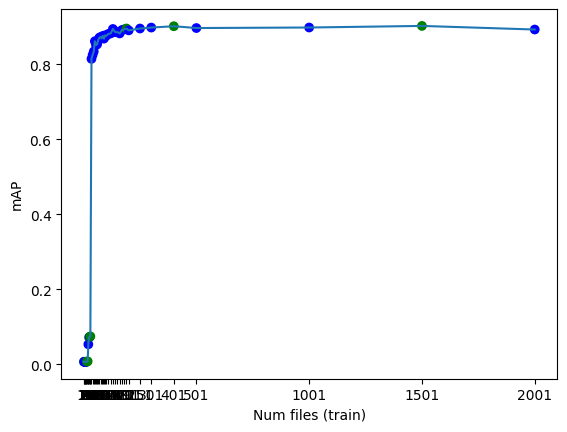

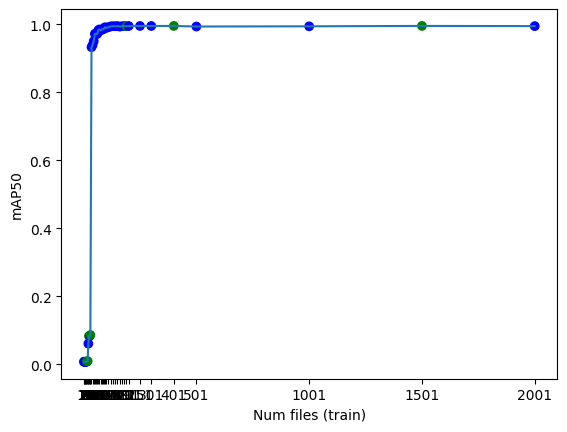

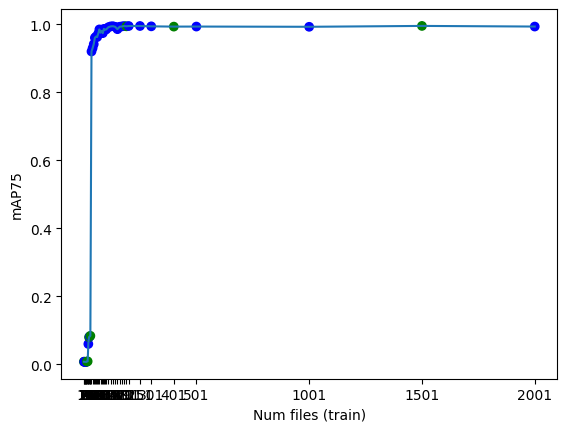

New https://pypi.org/project/ultralytics/8.0.217 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visu

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_1_1/train/labels... 2 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2/2 [00:00<00:00, 368.21it/s]

train: New cache created: /kaggle/working/feet-14/temp_1_1/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:01<00:00, 444.68it/s]

val: New cache created: /kaggle/working/feet-14/valid_1/labels.cache


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      6.78G      1.615      2.627      3.966      1.875          8        640: 100%|██████████| 1/1 [00:00<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]

                   all        474        474       0.32      0.259      0.159     0.0391      0.478      0.472      0.379     0.0941



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.35G      0.911      3.104      3.553      1.447          4        640: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]

                   all        474        474      0.325      0.259       0.16       0.04      0.476      0.468      0.381     0.0951



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.43G     0.6868       1.08      3.016      1.323          3        640: 100%|██████████| 1/1 [00:00<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.50it/s]

                   all        474        474      0.322      0.266       0.16     0.0402      0.479      0.468      0.381     0.0954



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.44G      1.564      2.193      6.203      1.824          3        640: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.51it/s]

                   all        474        474      0.318      0.264      0.161     0.0403      0.489      0.447      0.378      0.095



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.44G      1.283      1.704      3.387      1.979          2        640: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]

                   all        474        474      0.325      0.266       0.16     0.0408      0.471      0.475      0.378     0.0953



5 epochs completed in 0.018 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


                   all        474        474      0.323      0.266       0.16     0.0406      0.472      0.475       0.38     0.0956
                  legs        474        474      0.323      0.266       0.16     0.0406      0.472      0.475       0.38     0.0956
Speed: 0.7ms preprocess, 13.1ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▇▇█▅
wandb:        metrics/mAP50(M) ▃██▁▇
wandb:     metrics/mAP50-95(B) ▁▅▆▆█
wandb:     metrics/mAP50-95(M) ▁▆▇▅█
wandb:    metrics/precision(B) ▃█▅▁▆
wandb:    metrics/precision(M) ▄▃▄█▁
wandb:       metrics/recall(B) ▁▁▇▅█
wandb:       metrics/recall(M) ▇▆▆▁█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▃▁█▅
wandb:          train/cls_loss ▃▂▁█▂
wandb:          train/dfl_loss ▇▂▁▆█
wandb:          train/seg_loss ▆█▁▅▃
wandb:            val/box_loss ▁▂▄▇█
wandb:            val/cls_loss ▁▆▇██
wandb:            val/dfl_loss ▁▁▃█▆
wandb:            val/seg_loss ▁▂▅▆█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:01<00:00, 456.79it/s]

val: New cache created: /kaggle/working/feet-14/test_1/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:13<00:00,  2.18it/s]


                   all        476        476      0.261      0.284      0.147     0.0352      0.474       0.45       0.39     0.0922
                  legs        476        476      0.261      0.284      0.147     0.0352      0.474       0.45       0.39     0.0922
Speed: 1.2ms preprocess, 14.3ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs/segment/train
New https://pypi.org/project/ultralytics/8.0.217 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=Fals

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_1_2/train/labels... 2 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2/2 [00:00<00:00, 686.41it/s]

train: New cache created: /kaggle/working/feet-14/temp_1_2/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.76G     0.8505      2.502      3.194      1.479          6        640: 100%|██████████| 1/1 [00:00<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]

                   all        474        474      0.306      0.257      0.159     0.0418      0.451      0.464      0.362     0.0942



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.42G      1.833      2.378      3.191      2.602          2        640: 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]

                   all        474        474      0.314      0.257      0.164     0.0427      0.455      0.466      0.369     0.0959



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.31G      1.231      2.123      3.458      1.413          2        640: 100%|██████████| 1/1 [00:00<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]

                   all        474        474      0.316      0.259      0.165     0.0433      0.465      0.465      0.376     0.0973



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.33G     0.6763      1.582      2.819      1.016          5        640: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]

                   all        474        474      0.326      0.255      0.169     0.0442      0.457      0.464      0.375     0.0983



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.31G       1.32      2.954       4.66      1.634          2        640: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]

                   all        474        474       0.33      0.259      0.172     0.0457      0.455      0.475      0.381      0.101



5 epochs completed in 0.019 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


                   all        474        474      0.328      0.259      0.172      0.046      0.457      0.473      0.383      0.101
                  legs        474        474      0.328      0.259      0.172      0.046      0.457      0.473      0.383      0.101
Speed: 0.6ms preprocess, 13.1ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▃▄▆█
wandb:        metrics/mAP50(M) ▁▃▆▆█
wandb:     metrics/mAP50-95(B) ▁▂▃▅█
wandb:     metrics/mAP50-95(M) ▁▃▄▅█
wandb:    metrics/precision(B) ▁▄▄██
wandb:    metrics/precision(M) ▁▃█▄▄
wandb:       metrics/recall(B) ▄▄█▁█
wandb:       metrics/recall(M) ▁▃▂▁█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▂█▄▁▅
wandb:          train/cls_loss ▂▂▃▁█
wandb:          train/dfl_loss ▃█▃▁▄
wandb:          train/seg_loss ▆▅▄▁█
wandb:            val/box_loss ▁▁▅▇█
wandb:            val/cls_loss █▆▄▃▁
wandb:            val/dfl_loss █▆▅▅▁
wandb:            val/seg_loss ▁▃▃▇█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:14<00:00,  2.12it/s]


                   all        476        476      0.263      0.286       0.15     0.0373      0.444      0.445      0.388     0.0966
                  legs        476        476      0.263      0.286       0.15     0.0373      0.444      0.445      0.388     0.0966
Speed: 0.8ms preprocess, 14.3ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs/segment/train
New https://pypi.org/project/ultralytics/8.0.217 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=Fals

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_1_3/train/labels... 2 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2/2 [00:00<00:00, 297.23it/s]

train: New cache created: /kaggle/working/feet-14/temp_1_3/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.46G      0.746      1.169      3.477      1.354          6        640: 100%|██████████| 1/1 [00:00<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.36it/s]

                   all        474        474      0.306      0.287      0.177     0.0472      0.456      0.454      0.369      0.103



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5       2.4G      1.265      4.655      2.732      1.659          2        640: 100%|██████████| 1/1 [00:00<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.50it/s]

                   all        474        474      0.342       0.27      0.177     0.0472      0.451      0.449      0.372      0.103



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.32G      1.336       3.36      3.237      1.733          2        640: 100%|██████████| 1/1 [00:00<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]

                   all        474        474      0.324      0.278      0.174     0.0469      0.449      0.466      0.377      0.103



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.33G     0.7089       2.41       4.11       1.24          5        640: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]

                   all        474        474      0.332      0.272      0.178     0.0486       0.48      0.438      0.383      0.104



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.31G      1.467      3.299       2.25      2.121          2        640: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]

                   all        474        474       0.34      0.268      0.174     0.0486      0.484      0.441      0.384      0.105



5 epochs completed in 0.019 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


                   all        474        474       0.33      0.274      0.177     0.0485      0.479      0.439      0.383      0.104
                  legs        474        474       0.33      0.274      0.177     0.0485      0.479      0.439      0.383      0.104
Speed: 0.7ms preprocess, 13.2ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▇▅▁█▆
wandb:        metrics/mAP50(M) ▁▃▅██
wandb:     metrics/mAP50-95(B) ▂▂▁██
wandb:     metrics/mAP50-95(M) ▃▂▁██
wandb:    metrics/precision(B) ▁█▅▆▆
wandb:    metrics/precision(M) ▃▁▁██
wandb:       metrics/recall(B) █▁▄▂▃
wandb:       metrics/recall(M) ▅▄█▁▁
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁▆▇▁█
wandb:          train/cls_loss ▆▃▅█▁
wandb:          train/dfl_loss ▂▄▅▁█
wandb:          train/seg_loss ▁█▅▃▅
wandb:            val/box_loss ▁▃▄█▇
wandb:            val/cls_loss ▁▂▄▅█
wandb:            val/dfl_loss ▁▃▅█▇
wandb:            val/seg_loss ▁▃▆▇█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:13<00:00,  2.16it/s]


                   all        476        476      0.275      0.267      0.158     0.0401      0.448      0.429       0.39      0.101
                  legs        476        476      0.275      0.267      0.158     0.0401      0.448      0.429       0.39      0.101
Speed: 0.7ms preprocess, 14.3ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs/segment/train
New https://pypi.org/project/ultralytics/8.0.217 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=Fals

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_1_4/train/labels... 2 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2/2 [00:00<00:00, 592.88it/s]

train: New cache created: /kaggle/working/feet-14/temp_1_4/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.45G     0.6163      3.472       2.74      1.172          8        640: 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]

                   all        474        474      0.282      0.287       0.17     0.0502      0.446      0.408      0.338      0.101



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.36G     0.6214      2.485      1.503      1.122          5        640: 100%|██████████| 1/1 [00:00<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.52it/s]

                   all        474        474      0.298       0.27      0.176     0.0504      0.464      0.403      0.339        0.1



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.32G     0.3387      1.357      1.367     0.8127          3        640: 100%|██████████| 1/1 [00:00<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]

                   all        474        474      0.319      0.274       0.18     0.0511      0.481       0.41      0.348      0.103



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.32G      1.059      4.365      3.361      1.414          6        640: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.51it/s]

                   all        474        474      0.426      0.226      0.186     0.0531      0.446      0.428       0.36      0.108



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.31G     0.8532      2.206      2.862      1.148          3        640: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]

                   all        474        474      0.301      0.287      0.193     0.0542      0.458      0.428      0.372       0.11



5 epochs completed in 0.019 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


                   all        474        474      0.303      0.285      0.193     0.0543      0.459      0.428      0.371      0.111
                  legs        474        474      0.303      0.285      0.193     0.0543      0.459      0.428      0.371      0.111
Speed: 0.6ms preprocess, 13.1ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▃▄▆█
wandb:        metrics/mAP50(M) ▁▁▃▆█
wandb:     metrics/mAP50-95(B) ▁▁▃▆█
wandb:     metrics/mAP50-95(M) ▁▁▃▆█
wandb:    metrics/precision(B) ▁▂▃█▂
wandb:    metrics/precision(M) ▁▅█▁▄
wandb:       metrics/recall(B) █▆▇▁█
wandb:       metrics/recall(M) ▂▁▃██
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▄▄▁█▆
wandb:          train/cls_loss ▆▁▁█▆
wandb:          train/dfl_loss ▅▅▁█▅
wandb:          train/seg_loss ▆▄▁█▃
wandb:            val/box_loss ▁▂▄▇█
wandb:            val/cls_loss █▆█▄▁
wandb:            val/dfl_loss ▁▂▄▆█
wandb:            val/seg_loss ██▇▁▂
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:14<00:00,  2.12it/s]


                   all        476        476      0.299        0.3      0.185     0.0492      0.432      0.462      0.387      0.106
                  legs        476        476      0.299        0.3      0.185     0.0492      0.432      0.462      0.387      0.106
Speed: 1.2ms preprocess, 14.3ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs/segment/train
New https://pypi.org/project/ultralytics/8.0.217 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=Fals

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_1_5/train/labels... 2 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2/2 [00:00<00:00, 3327.49it/s]

train: New cache created: /kaggle/working/feet-14/temp_1_5/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.45G      2.204      3.287      2.451      2.247          5        640: 100%|██████████| 1/1 [00:00<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]

                   all        474        474      0.259      0.283      0.159     0.0502      0.358      0.388      0.268      0.082



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.35G      1.337      4.379      2.915      1.349          4        640: 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.53it/s]

                   all        474        474      0.292      0.276      0.166     0.0518      0.393       0.39      0.284     0.0863



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.32G     0.9414      3.164       3.14       1.33          3        640: 100%|██████████| 1/1 [00:00<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.50it/s]

                   all        474        474      0.309      0.276      0.167     0.0519      0.391      0.378      0.294     0.0902



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.33G      1.242      4.061      3.683      1.714          5        640: 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.54it/s]

                   all        474        474      0.328      0.264      0.172      0.053      0.442      0.376      0.299     0.0933



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.31G      1.083      3.988      3.244      1.735          3        640: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.51it/s]

                   all        474        474      0.317      0.276      0.168     0.0531      0.423      0.386      0.307      0.095



5 epochs completed in 0.019 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


                   all        474        474      0.322      0.278      0.169     0.0533      0.423      0.384      0.307     0.0951
                  legs        474        474      0.322      0.278      0.169     0.0533      0.423      0.384      0.307     0.0951
Speed: 0.6ms preprocess, 13.1ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▅▆█▇
wandb:        metrics/mAP50(M) ▁▄▆▇█
wandb:     metrics/mAP50-95(B) ▁▅▅▇█
wandb:     metrics/mAP50-95(M) ▁▃▅▇█
wandb:    metrics/precision(B) ▁▄▆█▇
wandb:    metrics/precision(M) ▁▄▄█▆
wandb:       metrics/recall(B) █▆▆▁▆
wandb:       metrics/recall(M) ▇█▂▁▅
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▃▁▃▂
wandb:          train/cls_loss ▁▄▅█▆
wandb:          train/dfl_loss █▁▁▄▄
wandb:          train/seg_loss ▂█▁▆▆
wandb:            val/box_loss ▁▂▄▅█
wandb:            val/cls_loss █▂▁▅█
wandb:            val/dfl_loss ▁▃▅▆█
wandb:            val/seg_loss █▇▄▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:14<00:00,  2.14it/s]


                   all        476        476      0.318      0.242      0.188     0.0554      0.445      0.334       0.32     0.0949
                  legs        476        476      0.318      0.242      0.188     0.0554      0.445      0.334       0.32     0.0949
Speed: 0.6ms preprocess, 14.5ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to runs/segment/train
New https://pypi.org/project/ultralytics/8.0.217 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<00:00, 12945.38it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      7.74G       1.36      3.815      4.406      1.792         18        640: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]

                   all        474        474      0.325      0.266       0.16     0.0397      0.478      0.473       0.38     0.0943



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      7.55G     0.9013       2.96      2.982      1.245         15        640: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]

                   all        474        474      0.332      0.255      0.163       0.04      0.476       0.47      0.382     0.0954



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      7.46G     0.9658      2.993      3.073      1.356         24        640: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]

                   all        474        474      0.329      0.255      0.162     0.0405      0.469      0.475       0.38     0.0953



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      7.45G      1.138      3.297      3.116      1.429         16        640: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.51it/s]

                   all        474        474      0.328      0.268      0.165     0.0412      0.469      0.481      0.379     0.0958



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      7.45G      1.278      3.234       3.08      1.775         20        640: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]

                   all        474        474      0.334      0.268      0.165     0.0428      0.483      0.466       0.38      0.097



5 epochs completed in 0.020 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


                   all        474        474      0.334      0.268      0.164     0.0426      0.484       0.47       0.38     0.0968
                  legs        474        474      0.334      0.268      0.164     0.0426      0.484       0.47       0.38     0.0968
Speed: 0.5ms preprocess, 13.3ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▆▄█▇
wandb:        metrics/mAP50(M) ▃█▄▁▂
wandb:     metrics/mAP50-95(B) ▁▂▃▅█
wandb:     metrics/mAP50-95(M) ▁▄▄▅█
wandb:    metrics/precision(B) ▁▆▄▄█
wandb:    metrics/precision(M) ▅▅▁▁█
wandb:       metrics/recall(B) ▇▁▁██
wandb:       metrics/recall(M) ▂▁▄█▁
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▁▂▅▇
wandb:          train/cls_loss █▁▁▂▁
wandb:          train/dfl_loss █▁▂▃█
wandb:          train/seg_loss █▁▁▄▃
wandb:            val/box_loss ▁▃▆▇█
wandb:            val/cls_loss █▆▂▂▁
wandb:            val/dfl_loss █▂▇▂▁
wandb:            val/seg_loss ▁▂▄▆█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:13<00:00,  2.16it/s]


                   all        476        476      0.257      0.271      0.147     0.0355      0.464      0.443       0.39     0.0919
                  legs        476        476      0.257      0.271      0.147     0.0355      0.464      0.443       0.39     0.0919
Speed: 0.7ms preprocess, 14.2ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs/segment/train
New https://pypi.org/project/ultralytics/8.0.217 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=Fals

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_1_6/train/labels... 3 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3/3 [00:00<00:00, 643.23it/s]

train: New cache created: /kaggle/working/feet-14/temp_1_6/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 3 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      6.01G      1.808      1.852      2.201      2.061          7        640: 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]

                   all        474        474       0.34      0.251      0.169      0.043      0.442      0.456      0.374     0.0966



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5         3G      1.456      4.057      3.103       2.18          2        640: 100%|██████████| 1/1 [00:00<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.50it/s]

                   all        474        474      0.324      0.259      0.167      0.043      0.452      0.462      0.371     0.0964



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.99G      1.022      4.378      2.734      1.478          5        640: 100%|██████████| 1/1 [00:00<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.50it/s]

                   all        474        474      0.321      0.255      0.169     0.0434       0.44       0.46      0.369     0.0963



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.77G      1.239      3.616      3.271      1.679          4        640: 100%|██████████| 1/1 [00:00<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]

                   all        474        474      0.337      0.251      0.168      0.044      0.447      0.458      0.371     0.0965



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.89G      1.327      2.685      2.205      1.874          5        640: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]

                   all        474        474      0.329      0.251      0.174     0.0456      0.439      0.485      0.372      0.098



5 epochs completed in 0.019 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


                   all        474        474      0.335      0.253      0.174     0.0456      0.438      0.484      0.371      0.098
                  legs        474        474      0.335      0.253      0.174     0.0456      0.438      0.484      0.371      0.098
Speed: 0.7ms preprocess, 13.2ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▂▁▃▂█
wandb:        metrics/mAP50(M) █▅▁▃▅
wandb:     metrics/mAP50-95(B) ▁▁▂▄█
wandb:     metrics/mAP50-95(M) ▂▁▁▂█
wandb:    metrics/precision(B) █▂▁▇▆
wandb:    metrics/precision(M) ▃█▂▆▁
wandb:       metrics/recall(B) ▁█▅▁▃
wandb:       metrics/recall(M) ▁▃▂▂█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▅▁▃▄
wandb:          train/cls_loss ▁▇▄█▁
wandb:          train/dfl_loss ▇█▁▃▅
wandb:          train/seg_loss ▁▇█▆▃
wandb:            val/box_loss ▁▄▅█▇
wandb:            val/cls_loss █▆▃▁▁
wandb:            val/dfl_loss ▁▆▃█▆
wandb:            val/seg_loss ▁▄▆▇█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:14<00:00,  2.13it/s]


                   all        476        476      0.285       0.27      0.152     0.0368      0.459      0.437      0.385     0.0967
                  legs        476        476      0.285       0.27      0.152     0.0368      0.459      0.437      0.385     0.0967
Speed: 0.8ms preprocess, 14.3ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs/segment/train
New https://pypi.org/project/ultralytics/8.0.217 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 13 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13/13 [00:00<00:00, 1193.18it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.87G       1.12      2.972      3.424      1.567         27        640: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]

                   all        474        474      0.325      0.268       0.16     0.0396      0.478      0.473      0.381     0.0948



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5         9G      1.531      4.028      3.329      1.738         27        640: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]

                   all        474        474       0.33      0.259      0.161     0.0398      0.477      0.468      0.381      0.095



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.78G      1.231      2.831      3.326      1.572         28        640: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]

                   all        474        474      0.327      0.268      0.164     0.0408       0.48      0.468      0.381     0.0955



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.77G     0.9789      2.938      2.794      1.391         28        640: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.50it/s]

                   all        474        474      0.327      0.268      0.164     0.0413      0.485      0.465       0.38     0.0954



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.78G      1.067      2.205      2.762      1.448         25        640: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.50it/s]

                   all        474        474      0.324       0.27      0.163      0.043      0.481      0.475       0.38     0.0964



5 epochs completed in 0.020 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


                   all        474        474      0.325      0.268      0.163     0.0431       0.48      0.477      0.383      0.097
                  legs        474        474      0.325      0.268      0.163     0.0431       0.48      0.477      0.383      0.097
Speed: 0.8ms preprocess, 13.2ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▃██▆
wandb:        metrics/mAP50(M) ▂▄▂▁█
wandb:     metrics/mAP50-95(B) ▁▁▃▄█
wandb:     metrics/mAP50-95(M) ▁▂▃▃█
wandb:    metrics/precision(B) ▁█▅▄▁
wandb:    metrics/precision(M) ▂▁▄█▄
wandb:       metrics/recall(B) █▁███
wandb:       metrics/recall(M) ▆▃▃▁█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▃█▄▁▂
wandb:          train/cls_loss █▇▇▁▁
wandb:          train/dfl_loss ▅█▅▁▂
wandb:          train/seg_loss ▄█▃▄▁
wandb:            val/box_loss ▁▂▄█▇
wandb:            val/cls_loss █▅▃▂▁
wandb:            val/dfl_loss █▆▆▇▁
wandb:            val/seg_loss ▁▃▄▆█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:13<00:00,  2.17it/s]


                   all        476        476      0.256      0.269      0.148     0.0358      0.455      0.445      0.392     0.0926
                  legs        476        476      0.256      0.269      0.148     0.0358      0.455      0.445      0.392     0.0926
Speed: 0.7ms preprocess, 14.3ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs/segment/train
New https://pypi.org/project/ultralytics/8.0.217 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=Fals

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_1_7/train/labels... 3 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3/3 [00:00<00:00, 849.16it/s]

train: New cache created: /kaggle/working/feet-14/temp_1_7/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 3 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      6.01G       1.33      4.018      2.834      1.732          7        640: 100%|██████████| 1/1 [00:00<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]

                   all        474        474      0.329      0.253      0.168     0.0426      0.452      0.458      0.372     0.0956



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5         3G      1.673      5.663      3.305      1.884          5        640: 100%|██████████| 1/1 [00:00<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]

                   all        474        474      0.341      0.253      0.166     0.0421      0.461      0.443      0.373     0.0964



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.86G      1.313      1.627      2.665      1.902          5        640: 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.50it/s]

                   all        474        474      0.341      0.251      0.169     0.0429      0.459      0.454      0.375      0.097



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.89G      1.191      4.003      4.237      1.521          3        640: 100%|██████████| 1/1 [00:00<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.50it/s]

                   all        474        474      0.342      0.249      0.168     0.0433      0.464      0.464      0.375     0.0972



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.88G      1.555      5.594       3.41      1.477          9        640: 100%|██████████| 1/1 [00:00<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]

                   all        474        474      0.312      0.264      0.169     0.0433      0.468      0.451      0.375     0.0978



5 epochs completed in 0.019 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


                   all        474        474      0.315      0.264      0.169     0.0432      0.472      0.449      0.375      0.098
                  legs        474        474      0.315      0.264      0.169     0.0432      0.472      0.449      0.375      0.098
Speed: 0.8ms preprocess, 13.1ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▅▁█▇▇
wandb:        metrics/mAP50(M) ▁▄▇▇█
wandb:     metrics/mAP50-95(B) ▄▁▆██
wandb:     metrics/mAP50-95(M) ▁▃▅▆█
wandb:    metrics/precision(B) ▅███▁
wandb:    metrics/precision(M) ▁▄▄▅█
wandb:       metrics/recall(B) ▃▃▂▁█
wandb:       metrics/recall(M) ▆▁▄█▃
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▃█▃▁▆
wandb:          train/cls_loss ▂▄▁█▄
wandb:          train/dfl_loss ▅██▂▁
wandb:          train/seg_loss ▅█▁▅█
wandb:            val/box_loss ▁▂▄▇█
wandb:            val/cls_loss ▁▄▆▅█
wandb:            val/dfl_loss ▁▂▃▆█
wandb:            val/seg_loss ▁▂▄█▅
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:13<00:00,  2.17it/s]


                   all        476        476      0.269      0.286      0.146     0.0356      0.458      0.445      0.384     0.0943
                  legs        476        476      0.269      0.286      0.146     0.0356      0.458      0.445      0.384     0.0943
Speed: 0.7ms preprocess, 14.3ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs/segment/train
New https://pypi.org/project/ultralytics/8.0.217 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 16 images, 0 backgrounds, 0 corrupt: 100%|██████████| 16/16 [00:00<00:00, 1117.21it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      9.29G     0.9262      3.672      2.686      1.356         39        640: 100%|██████████| 1/1 [00:01<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.34it/s]

                   all        474        474      0.326      0.266      0.159     0.0395      0.481       0.47      0.379     0.0941



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      9.41G      1.387      2.631      3.034      1.751         30        640: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]

                   all        474        474      0.329      0.259      0.159     0.0396      0.477      0.468      0.382     0.0953



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5       9.4G      1.123      3.718      3.068      1.482         31        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]

                   all        474        474      0.326       0.27      0.166     0.0406      0.473      0.473      0.383     0.0958



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5       9.4G     0.9726      3.026      2.905      1.313         32        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]

                   all        474        474      0.325       0.27      0.166      0.041      0.487      0.473      0.384     0.0957



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      9.42G      1.098      3.217      3.369       1.44         29        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]

                   all        474        474      0.322      0.266      0.164     0.0413      0.487      0.475      0.385     0.0962



5 epochs completed in 0.021 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.17it/s]


                   all        474        474      0.322      0.266      0.165     0.0415      0.488      0.473      0.385     0.0964
                  legs        474        474      0.322      0.266      0.165     0.0415      0.488      0.473      0.385     0.0964
Speed: 0.7ms preprocess, 13.1ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▁██▆
wandb:        metrics/mAP50(M) ▁▄▆▇█
wandb:     metrics/mAP50-95(B) ▁▁▅▆█
wandb:     metrics/mAP50-95(M) ▁▅▆▆█
wandb:    metrics/precision(B) ▅█▅▄▁
wandb:    metrics/precision(M) ▅▃▁██
wandb:       metrics/recall(B) ▅▁██▅
wandb:       metrics/recall(M) ▄▁███
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁█▄▂▄
wandb:          train/cls_loss ▁▅▅▃█
wandb:          train/dfl_loss ▂█▄▁▃
wandb:          train/seg_loss █▁█▄▅
wandb:            val/box_loss ▁▃▄▆█
wandb:            val/cls_loss █▅▂▃▁
wandb:            val/dfl_loss ▇▇█▁▁
wandb:            val/seg_loss ▁▃▅▆█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:13<00:00,  2.14it/s]


                   all        476        476      0.264      0.277      0.148     0.0356      0.452      0.452      0.391      0.092
                  legs        476        476      0.264      0.277      0.148     0.0356      0.452      0.452      0.391      0.092
Speed: 0.7ms preprocess, 14.3ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs/segment/train
New https://pypi.org/project/ultralytics/8.0.217 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=Fals

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_1_8/train/labels... 3 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3/3 [00:00<00:00, 786.92it/s]

train: New cache created: /kaggle/working/feet-14/temp_1_8/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 3 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5         6G      1.095      1.975      2.661      1.349          7        640: 100%|██████████| 1/1 [00:00<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]

                   all        474        474       0.33      0.255      0.168     0.0426      0.459      0.458      0.372     0.0962



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.99G      1.493      3.351      2.623      1.826          4        640: 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.50it/s]

                   all        474        474      0.341      0.257      0.168      0.043      0.462      0.441      0.371     0.0955



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.87G      1.224      2.806      2.688      2.156          4        640: 100%|██████████| 1/1 [00:00<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]

                   all        474        474      0.342      0.243      0.167     0.0428      0.455      0.437       0.37     0.0954



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.87G      1.137      5.128      2.941      1.473          3        640: 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.51it/s]

                   all        474        474      0.339      0.243      0.166     0.0434      0.448      0.439       0.37     0.0958



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.88G      1.453      2.488      3.433      1.716          8        640: 100%|██████████| 1/1 [00:00<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]

                   all        474        474      0.309      0.259      0.168      0.044      0.446      0.449      0.368     0.0964



5 epochs completed in 0.019 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


                   all        474        474      0.296       0.27      0.168      0.044      0.444      0.446      0.368     0.0963
                  legs        474        474      0.296       0.27      0.168      0.044      0.444      0.446      0.368     0.0963
Speed: 0.8ms preprocess, 13.1ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) █▇▄▁▆
wandb:        metrics/mAP50(M) █▅▄▄▁
wandb:     metrics/mAP50-95(B) ▁▃▂▅█
wandb:     metrics/mAP50-95(M) ▇▂▁▄█
wandb:    metrics/precision(B) ▆██▇▁
wandb:    metrics/precision(M) ▇█▅▃▁
wandb:       metrics/recall(B) ▄▅▁▁█
wandb:       metrics/recall(M) █▂▁▂▄
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁█▃▂▇
wandb:          train/cls_loss ▁▁▂▄█
wandb:          train/dfl_loss ▁▅█▂▄
wandb:          train/seg_loss ▁▄▃█▂
wandb:            val/box_loss ▁▅▅▇█
wandb:            val/cls_loss ▅▆█▁▁
wandb:            val/dfl_loss ▁▆▄▆█
wandb:            val/seg_loss ▁▃▄▆█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:14<00:00,  2.08it/s]


                   all        476        476      0.278      0.265      0.148      0.035      0.443      0.435      0.378     0.0921
                  legs        476        476      0.278      0.265      0.148      0.035      0.443      0.435      0.378     0.0921
Speed: 1.1ms preprocess, 14.3ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs/segment/train
New https://pypi.org/project/ultralytics/8.0.217 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 19 images, 0 backgrounds, 0 corrupt: 100%|██████████| 19/19 [00:00<00:00, 1154.00it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      9.31G      1.482      3.174      3.088      1.719          4        640: 100%|██████████| 2/2 [00:01<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]

                   all        474        474      0.331      0.262      0.161     0.0399      0.473      0.464       0.38      0.095



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      9.52G     0.9238       2.73      2.912      1.292          8        640: 100%|██████████| 2/2 [00:01<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]

                   all        474        474      0.323      0.266      0.164     0.0415      0.469      0.481       0.38     0.0959



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      9.31G      1.071      3.172      3.491      1.437          9        640: 100%|██████████| 2/2 [00:01<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.51it/s]

                   all        474        474      0.312      0.269      0.163     0.0424      0.471      0.485      0.381     0.0961



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      9.42G      1.628      4.537      3.538      1.885          3        640: 100%|██████████| 2/2 [00:01<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.50it/s]

                   all        474        474      0.308      0.276      0.163     0.0433      0.471      0.485      0.379     0.0958



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      9.43G      1.314      2.608      3.441      1.683          6        640: 100%|██████████| 2/2 [00:01<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]

                   all        474        474      0.313      0.285      0.171      0.045      0.465      0.492      0.384     0.0977



5 epochs completed in 0.021 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


                   all        474        474       0.31      0.285      0.171     0.0451      0.466      0.493      0.384     0.0982
                  legs        474        474       0.31      0.285      0.171     0.0451      0.466      0.493      0.384     0.0982
Speed: 0.6ms preprocess, 13.1ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▄
wandb:                  lr/pg2 ▁▆█▇▄
wandb:        metrics/mAP50(B) ▁▃▂▃█
wandb:        metrics/mAP50(M) ▁▂▄▁█
wandb:     metrics/mAP50-95(B) ▁▃▄▆█
wandb:     metrics/mAP50-95(M) ▁▃▃▃█
wandb:    metrics/precision(B) █▆▂▁▁
wandb:    metrics/precision(M) █▃▆▆▁
wandb:       metrics/recall(B) ▁▂▃▅█
wandb:       metrics/recall(M) ▁▅▆▆█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▇▁▂█▅
wandb:          train/cls_loss ▃▁▇█▇
wandb:          train/dfl_loss ▆▁▃█▆
wandb:          train/seg_loss ▃▁▃█▁
wandb:            val/box_loss ▂██▇▁
wandb:            val/cls_loss █▆▅▆▁
wandb:            val/dfl_loss ▇█▇▅▁
wandb:            val/seg_loss ▇█▅▅▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09119
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:13<00:00,  2.15it/s]


                   all        476        476      0.273      0.271      0.152     0.0369      0.452       0.46      0.394     0.0946
                  legs        476        476      0.273      0.271      0.152     0.0369      0.452       0.46      0.394     0.0946
Speed: 0.9ms preprocess, 14.5ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs/segment/train
New https://pypi.org/project/ultralytics/8.0.217 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=Fals

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_1_9/train/labels... 3 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3/3 [00:00<00:00, 531.28it/s]

train: New cache created: /kaggle/working/feet-14/temp_1_9/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 3 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      6.12G      1.405      2.699      3.311      1.782          6        640: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]

                   all        474        474       0.31      0.274      0.171     0.0453      0.481      0.439       0.38     0.0987



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.98G     0.9601      2.067       3.02      1.379          4        640: 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.50it/s]

                   all        474        474      0.309      0.281      0.177     0.0471      0.457      0.466      0.383      0.101



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.89G     0.8086       2.17      2.981      1.416          6        640: 100%|██████████| 1/1 [00:00<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]

                   all        474        474      0.301      0.295      0.178     0.0472      0.454      0.481      0.382      0.102



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.86G      1.035      2.329      3.411      1.364          4        640: 100%|██████████| 1/1 [00:00<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.51it/s]

                   all        474        474      0.302       0.31       0.18     0.0481      0.451      0.479      0.383      0.103



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5       2.9G      1.143       3.29      2.646      1.425         10        640: 100%|██████████| 1/1 [00:00<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.50it/s]

                   all        474        474      0.302      0.319      0.183     0.0483      0.457      0.492      0.381      0.103



5 epochs completed in 0.019 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


                   all        474        474      0.302       0.32      0.184     0.0483      0.456      0.489      0.381      0.103
                  legs        474        474      0.302       0.32      0.184     0.0483      0.456      0.489      0.381      0.103
Speed: 0.7ms preprocess, 13.2ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▄▅▆█
wandb:        metrics/mAP50(M) ▁▇▆█▂
wandb:     metrics/mAP50-95(B) ▁▅▅██
wandb:     metrics/mAP50-95(M) ▁▅▆██
wandb:    metrics/precision(B) █▇▁▂▂
wandb:    metrics/precision(M) █▂▂▁▂
wandb:       metrics/recall(B) ▁▂▄▇█
wandb:       metrics/recall(M) ▁▅▇▇█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▃▁▄▅
wandb:          train/cls_loss ▇▄▄█▁
wandb:          train/dfl_loss █▁▂▁▂
wandb:          train/seg_loss ▅▁▂▃█
wandb:            val/box_loss █▁▄▄▂
wandb:            val/cls_loss █▅▃▃▁
wandb:            val/dfl_loss █▃▄▂▁
wandb:            val/seg_loss ▁▂▅▇█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:14<00:00,  2.07it/s]


                   all        476        476      0.284      0.267      0.153     0.0385      0.459      0.441      0.388     0.0985
                  legs        476        476      0.284      0.267      0.153     0.0385      0.459      0.441      0.388     0.0985
Speed: 1.0ms preprocess, 14.3ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs/segment/train
New https://pypi.org/project/ultralytics/8.0.217 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 22 images, 0 backgrounds, 0 corrupt: 100%|██████████| 22/22 [00:00<00:00, 913.34it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5       9.3G      1.145      4.368      3.223      1.535         12        640: 100%|██████████| 2/2 [00:01<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.33it/s]

                   all        474        474      0.328      0.259      0.163     0.0404      0.484      0.468      0.382      0.095



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5       9.4G      1.097       3.48       2.99      1.511         13        640: 100%|██████████| 2/2 [00:01<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]

                   all        474        474      0.324      0.274      0.163     0.0413      0.496      0.464      0.383     0.0965



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5       9.4G      1.301      3.442      3.744      1.611         10        640: 100%|██████████| 2/2 [00:01<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]

                   all        474        474      0.321      0.268      0.164     0.0426      0.492      0.462      0.384     0.0975



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      9.41G      1.189       2.89      3.408      1.506         11        640: 100%|██████████| 2/2 [00:01<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]

                   all        474        474       0.32      0.285      0.165     0.0434      0.495      0.468      0.386     0.0979



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      9.52G      1.202      1.996      3.325      1.594         13        640: 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]

                   all        474        474      0.311      0.289      0.169     0.0445      0.493      0.474      0.389     0.0994



5 epochs completed in 0.021 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


                   all        474        474      0.309      0.291      0.168     0.0446      0.491      0.473      0.389     0.0993
                  legs        474        474      0.309      0.291      0.168     0.0446      0.491      0.473      0.389     0.0993
Speed: 0.8ms preprocess, 13.1ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▄
wandb:                  lr/pg2 ▁▆█▇▄
wandb:        metrics/mAP50(B) ▁▁▂▃█
wandb:        metrics/mAP50(M) ▁▂▃▅█
wandb:     metrics/mAP50-95(B) ▁▂▅▆█
wandb:     metrics/mAP50-95(M) ▁▃▅▆█
wandb:    metrics/precision(B) █▆▅▅▁
wandb:    metrics/precision(M) ▁█▆▇▅
wandb:       metrics/recall(B) ▁▄▃▇█
wandb:       metrics/recall(M) ▅▂▁▅█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▃▁█▄▅
wandb:          train/cls_loss ▃▁█▅▄
wandb:          train/dfl_loss ▃▁█▁▇
wandb:          train/seg_loss █▅▅▄▁
wandb:            val/box_loss ▄██▄▁
wandb:            val/cls_loss █▇▇▄▁
wandb:            val/dfl_loss ██▆▄▁
wandb:            val/seg_loss ▄▆█▄▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09119
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:13<00:00,  2.15it/s]


                   all        476        476      0.289      0.271      0.149     0.0362       0.45      0.452      0.383     0.0933
                  legs        476        476      0.289      0.271      0.149     0.0362       0.45      0.452      0.383     0.0933
Speed: 0.7ms preprocess, 14.3ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs/segment/train
New https://pypi.org/project/ultralytics/8.0.217 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=Fals

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_1_10/train/labels... 3 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3/3 [00:00<00:00, 557.46it/s]

train: New cache created: /kaggle/working/feet-14/temp_1_10/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 3 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5       6.1G      1.147      1.819      3.323      1.514          7        640: 100%|██████████| 1/1 [00:00<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]

                   all        474        474      0.297      0.274      0.172     0.0449      0.459      0.464      0.376     0.0995



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.88G      1.335      3.395      3.531      1.929          3        640: 100%|██████████| 1/1 [00:00<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]

                   all        474        474      0.294      0.308      0.175     0.0454      0.454      0.481      0.379      0.101



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.89G     0.9047       1.67      3.608       1.33          6        640: 100%|██████████| 1/1 [00:00<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]

                   all        474        474      0.366      0.243      0.173     0.0452      0.456       0.48      0.377        0.1



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.85G      2.096      1.421      3.604       2.36          3        640: 100%|██████████| 1/1 [00:00<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.50it/s]

                   all        474        474      0.283      0.296      0.171     0.0449      0.447      0.477      0.377     0.0997



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.89G      0.912      1.894      2.513      1.194          5        640: 100%|██████████| 1/1 [00:00<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]

                   all        474        474      0.275      0.296      0.174     0.0454      0.443      0.473      0.378        0.1



5 epochs completed in 0.019 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.17it/s]


                   all        474        474      0.294      0.309      0.175     0.0454      0.452      0.479       0.38      0.101
                  legs        474        474      0.294      0.309      0.175     0.0454      0.452      0.479       0.38      0.101
Speed: 0.9ms preprocess, 13.2ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▂█▄▁█
wandb:        metrics/mAP50(M) ▁▇▃▄█
wandb:     metrics/mAP50-95(B) ▂█▅▁█
wandb:     metrics/mAP50-95(M) ▁█▄▂▇
wandb:    metrics/precision(B) ▂▂█▁▂
wandb:    metrics/precision(M) █▅▆▁▄
wandb:       metrics/recall(B) ▄█▁▇█
wandb:       metrics/recall(M) ▁██▆▇
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▂▄▁█▁
wandb:          train/cls_loss ▆███▁
wandb:          train/dfl_loss ▃▅▂█▁
wandb:          train/seg_loss ▂█▂▁▃
wandb:            val/box_loss ▁▅▆▇█
wandb:            val/cls_loss █▃▁▄█
wandb:            val/dfl_loss ▁▅▆▆█
wandb:            val/seg_loss ▁▃▄▄█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:14<00:00,  2.11it/s]


                   all        476        476      0.274      0.286      0.149     0.0375      0.449      0.464      0.384     0.0964
                  legs        476        476      0.274      0.286      0.149     0.0375      0.449      0.464      0.384     0.0964
Speed: 1.0ms preprocess, 14.3ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs/segment/train
New https://pypi.org/project/ultralytics/8.0.217 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 25 images, 0 backgrounds, 0 corrupt: 100%|██████████| 25/25 [00:00<00:00, 1084.71it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      9.21G      1.347      3.742      3.209      1.627         25        640: 100%|██████████| 2/2 [00:01<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.34it/s]

                   all        474        474      0.319      0.269      0.161     0.0399      0.476      0.466      0.381     0.0953



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      9.41G     0.9811      2.868      2.996      1.438         17        640: 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]

                   all        474        474      0.332      0.257      0.164     0.0408      0.475      0.475      0.379     0.0957



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      9.29G      1.347      3.111      3.273      1.732         22        640: 100%|██████████| 2/2 [00:01<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]

                   all        474        474      0.323      0.268      0.163     0.0416      0.487      0.475      0.384     0.0962



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      9.29G       1.03      3.179      2.883      1.438         18        640: 100%|██████████| 2/2 [00:01<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.50it/s]

                   all        474        474      0.323      0.278      0.166     0.0432      0.484      0.465      0.384     0.0975



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      9.41G      1.329       2.94      3.541       1.68         18        640: 100%|██████████| 2/2 [00:01<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.50it/s]

                   all        474        474      0.321      0.276      0.175     0.0462      0.482      0.468      0.388        0.1



5 epochs completed in 0.021 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


                   all        474        474      0.321      0.276      0.174     0.0459       0.48      0.468      0.388        0.1
                  legs        474        474      0.321      0.276      0.174     0.0459       0.48      0.468      0.388        0.1
Speed: 0.6ms preprocess, 13.1ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▄
wandb:                  lr/pg2 ▁▆█▇▄
wandb:        metrics/mAP50(B) ▁▂▂▄█
wandb:        metrics/mAP50(M) ▂▁▅▅█
wandb:     metrics/mAP50-95(B) ▁▂▃▅█
wandb:     metrics/mAP50-95(M) ▁▂▂▄█
wandb:    metrics/precision(B) ▁█▃▃▂
wandb:    metrics/precision(M) ▂▁█▆▄
wandb:       metrics/recall(B) ▅▁▅█▇
wandb:       metrics/recall(M) ▂██▁▃
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▁█▂█
wandb:          train/cls_loss ▄▂▅▁█
wandb:          train/dfl_loss ▆▁█▁▇
wandb:          train/seg_loss █▁▃▃▂
wandb:            val/box_loss ▅▆██▁
wandb:            val/cls_loss █▇▅▅▁
wandb:            val/dfl_loss ▇██▇▁
wandb:            val/seg_loss ▇▇█▇▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09119
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:14<00:00,  2.09it/s]


                   all        476        476      0.291      0.275      0.153     0.0368      0.471      0.441      0.384     0.0929
                  legs        476        476      0.291      0.275      0.153     0.0368      0.471      0.441      0.384     0.0929
Speed: 0.8ms preprocess, 14.3ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs/segment/train
New https://pypi.org/project/ultralytics/8.0.217 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=Fals

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_1_11/train/labels... 3 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3/3 [00:00<00:00, 587.11it/s]

train: New cache created: /kaggle/working/feet-14/temp_1_11/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 3 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.97G      1.436      1.449      3.021      1.634          8        640: 100%|██████████| 1/1 [00:00<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.35it/s]

                   all        474        474      0.289      0.295      0.177     0.0459       0.45      0.475      0.386      0.102



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.98G      1.747      4.512      3.949      2.088          4        640: 100%|██████████| 1/1 [00:00<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.52it/s]

                   all        474        474      0.301      0.286      0.179     0.0464      0.457      0.477      0.384      0.101



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.89G      1.645       1.81      3.112      1.803          6        640: 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]

                   all        474        474      0.301      0.296       0.18     0.0462      0.462      0.462      0.385      0.101



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5       2.9G      1.173        1.1      3.222       1.49          7        640: 100%|██████████| 1/1 [00:00<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.50it/s]

                   all        474        474      0.301      0.289      0.176     0.0461      0.464      0.456      0.379     0.0997



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5       2.9G       1.66      3.737      3.385      2.025          9        640: 100%|██████████| 1/1 [00:00<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]

                   all        474        474      0.297      0.289      0.173     0.0455      0.464      0.454      0.377     0.0988



5 epochs completed in 0.018 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


                   all        474        474      0.286        0.3      0.178     0.0455      0.448      0.475      0.386      0.101
                  legs        474        474      0.286        0.3      0.178     0.0455      0.448      0.475      0.386      0.101
Speed: 0.6ms preprocess, 13.2ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▃▆█▁▄
wandb:        metrics/mAP50(M) █▅▆▁█
wandb:     metrics/mAP50-95(B) ▄█▆▅▁
wandb:     metrics/mAP50-95(M) █▅▆▁▅
wandb:    metrics/precision(B) ▂███▁
wandb:    metrics/precision(M) ▂▅▇█▁
wandb:       metrics/recall(B) ▆▁▆▂█
wandb:       metrics/recall(M) ▇█▃▁▇
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▄█▇▁▇
wandb:          train/cls_loss ▁█▂▃▄
wandb:          train/dfl_loss ▃█▅▁▇
wandb:          train/seg_loss ▂█▂▁▆
wandb:            val/box_loss ▁▁▁▃█
wandb:            val/cls_loss █▆▅▄▁
wandb:            val/dfl_loss ▅▂▁▃█
wandb:            val/seg_loss ▁▁▃█▇
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:14<00:00,  2.09it/s]


                   all        476        476       0.28      0.261      0.151     0.0384      0.468      0.433      0.391     0.0985
                  legs        476        476       0.28      0.261      0.151     0.0384      0.468      0.433      0.391     0.0985
Speed: 0.9ms preprocess, 14.2ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs/segment/train
New https://pypi.org/project/ultralytics/8.0.217 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 28 images, 0 backgrounds, 0 corrupt: 100%|██████████| 28/28 [00:00<00:00, 1139.45it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      9.21G       1.14      3.639      3.001      1.573         18        640: 100%|██████████| 2/2 [00:01<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.36it/s]

                   all        474        474      0.328      0.264      0.163     0.0406      0.478      0.475      0.384     0.0955



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      9.41G      1.268      3.947      3.148      1.628         24        640: 100%|██████████| 2/2 [00:01<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]

                   all        474        474      0.327      0.274      0.167     0.0417      0.489      0.479      0.386     0.0965



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5       9.3G      1.151      3.337      3.081      1.515         28        640: 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.51it/s]

                   all        474        474      0.321       0.27      0.163     0.0429      0.478      0.479      0.384      0.097



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      9.31G      1.349      3.041      3.184      1.542         26        640: 100%|██████████| 2/2 [00:01<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.50it/s]

                   all        474        474      0.314      0.281      0.166     0.0436      0.488       0.47      0.386      0.098



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5       9.4G      1.209      2.877      3.426      1.623         25        640: 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.52it/s]

                   all        474        474      0.317      0.285      0.172     0.0458      0.473      0.483      0.392        0.1



5 epochs completed in 0.022 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


                   all        474        474      0.317      0.284      0.171     0.0458      0.471      0.483      0.392      0.101
                  legs        474        474      0.317      0.284      0.171     0.0458      0.471      0.483      0.392      0.101
Speed: 0.8ms preprocess, 13.1ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▄
wandb:                  lr/pg2 ▁▆█▇▄
wandb:        metrics/mAP50(B) ▁▅▁▄█
wandb:        metrics/mAP50(M) ▁▃▁▃█
wandb:     metrics/mAP50-95(B) ▁▂▄▅█
wandb:     metrics/mAP50-95(M) ▁▂▃▄█
wandb:    metrics/precision(B) ██▄▁▃
wandb:    metrics/precision(M) ▃█▃█▁
wandb:       metrics/recall(B) ▁▅▃▇█
wandb:       metrics/recall(M) ▃▆▆▁█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁▅▁█▃
wandb:          train/cls_loss ▁▃▂▄█
wandb:          train/dfl_loss ▅█▁▃█
wandb:          train/seg_loss ▆█▄▂▁
wandb:            val/box_loss ▅▆█▇▁
wandb:            val/cls_loss █▆▅▃▁
wandb:            val/dfl_loss ███▆▁
wandb:            val/seg_loss ▇▇█▆▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09119
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:14<00:00,  2.11it/s]


                   all        476        476      0.286      0.284      0.151     0.0363      0.472      0.468      0.401     0.0956
                  legs        476        476      0.286      0.284      0.151     0.0363      0.472      0.468      0.401     0.0956
Speed: 0.9ms preprocess, 14.3ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = 0.0036367302386574457
New https://pypi.org/project/ultralytics/8.0.217 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=T

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/temp_1_12/train/labels... 3 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3/3 [00:00<00:00, 866.53it/s]

train: New cache created: /kaggle/working/feet-14/temp_1_12/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 3 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5       5.9G      1.127      2.781      2.305      1.282          6        640: 100%|██████████| 1/1 [00:00<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]

                   all        474        474       0.32      0.283      0.177     0.0467       0.49      0.473      0.392      0.102



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5         3G     0.8109      2.246      2.985      1.316          5        640: 100%|██████████| 1/1 [00:00<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.51it/s]

                   all        474        474      0.318      0.295      0.176     0.0467      0.499      0.464      0.391      0.102



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.01G      1.064      1.918      2.567      1.468          5        640: 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]

                   all        474        474      0.318      0.312      0.182     0.0473      0.485      0.477      0.392      0.102



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.89G      1.458      3.152      4.009      1.975          3        640: 100%|██████████| 1/1 [00:00<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.50it/s]

                   all        474        474      0.316      0.316      0.182     0.0478      0.467      0.477       0.39      0.103



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.91G      1.003      2.633      2.692      1.436          8        640: 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]

                   all        474        474      0.325       0.31      0.182     0.0483      0.458      0.479       0.39      0.103



5 epochs completed in 0.019 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


                   all        474        474      0.324       0.31      0.182     0.0481      0.456      0.479      0.389      0.103
                  legs        474        474      0.324       0.31      0.182     0.0481      0.456      0.479      0.389      0.103
Speed: 0.7ms preprocess, 13.2ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▁▇██
wandb:        metrics/mAP50(M) █▅▇▂▁
wandb:     metrics/mAP50-95(B) ▁▁▄▆█
wandb:     metrics/mAP50-95(M) ▁▁▅▆█
wandb:    metrics/precision(B) ▅▃▃▁█
wandb:    metrics/precision(M) ▇█▆▃▁
wandb:       metrics/recall(B) ▁▄▇█▇
wandb:       metrics/recall(M) ▅▁▇▇█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▄▁▄█▃
wandb:          train/cls_loss ▁▄▂█▃
wandb:          train/dfl_loss ▁▁▃█▃
wandb:          train/seg_loss ▆▃▁█▅
wandb:            val/box_loss ▇█▃▄▁
wandb:            val/cls_loss ▇█▁▁▂
wandb:            val/dfl_loss ██▃▁▁
wandb:            val/seg_loss ▁▇▆█▅
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:14<00:00,  2.09it/s]


                   all        476        476       0.28      0.277      0.151     0.0384      0.464      0.441      0.387     0.0981
                  legs        476        476       0.28      0.277      0.151     0.0384      0.464      0.441      0.387     0.0981
Speed: 0.6ms preprocess, 14.5ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs/segment/train
New https://pypi.org/project/ultralytics/8.0.217 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/feet-14/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/feet-14/retrain/train/labels... 31 images, 0 backgrounds, 0 corrupt: 100%|██████████| 31/31 [00:00<00:00, 1249.84it/s]

train: New cache created: /kaggle/working/feet-14/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/feet-14/valid_1/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      9.31G      1.116      3.295      2.954      1.446         36        640: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.36it/s]

                   all        474        474      0.313      0.259       0.16     0.0393      0.479      0.464       0.38     0.0944



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      9.51G      1.024      2.721      2.848      1.427         27        640: 100%|██████████| 2/2 [00:01<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]

                   all        474        474      0.319      0.268      0.161     0.0404       0.48      0.468      0.379     0.0952



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      9.29G      1.282      2.864      3.135      1.631         33        640: 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.50it/s]

                   all        474        474      0.321      0.266      0.161     0.0421      0.476       0.47      0.381     0.0965



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5       9.3G        1.1      3.284       3.25       1.52         28        640: 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.51it/s]

                   all        474        474      0.316      0.274      0.165     0.0432      0.483      0.465      0.381     0.0973



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      9.31G       1.34       3.45      2.993      1.662         33        640: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.51it/s]

                   all        474        474      0.314      0.283      0.168     0.0443       0.49      0.466      0.386     0.0981



5 epochs completed in 0.022 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


                   all        474        474      0.314      0.281      0.168     0.0443      0.489      0.466      0.386     0.0982
                  legs        474        474      0.314      0.281      0.168     0.0443      0.489      0.466      0.386     0.0982
Speed: 0.7ms preprocess, 13.2ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▄
wandb:                  lr/pg2 ▁▆█▇▄
wandb:        metrics/mAP50(B) ▁▂▂▆█
wandb:        metrics/mAP50(M) ▂▁▃▃█
wandb:     metrics/mAP50-95(B) ▁▂▅▆█
wandb:     metrics/mAP50-95(M) ▁▂▅▆█
wandb:    metrics/precision(B) ▁▆█▃▂
wandb:    metrics/precision(M) ▃▃▁▅█
wandb:       metrics/recall(B) ▁▄▃▆█
wandb:       metrics/recall(M) ▁▆█▂▃
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▃▁▇▃█
wandb:          train/cls_loss ▃▁▆█▄
wandb:          train/dfl_loss ▂▁▇▄█
wandb:          train/seg_loss ▇▁▂▆█
wandb:            val/box_loss ▂▆██▁
wandb:            val/cls_loss █▅▄▅▁
wandb:            val/dfl_loss ██▆▅▁
wandb:            val/seg_loss ▆▇██▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09119
wandb:          

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8m-seg summary (fused): 245 layers, 27223542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/feet-14/test_1/labels.cache... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:14<00:00,  2.12it/s]


                   all        476        476      0.279      0.288      0.148     0.0351      0.469      0.458      0.392     0.0931
                  legs        476        476      0.279      0.288      0.148     0.0351      0.469      0.458      0.392     0.0931
Speed: 0.7ms preprocess, 14.3ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs/segment/train
Progress for 10 last iterations with 0.001 threshold = -0.02466877384930269
Итоговый результат (инкрементальное обучение) для класса 1: 
 defaultdict(<class 'list'>, {0: [0.09219742116933129, 0.3899051356752889, 0.015206399037072285], 1: [0.09659750291516363, 0.38832471389160805, 0.019935784297318074], 2: [0.10057542935077715, 0.3900328305450736, 0.02243008286162983], 3: [0.10586631736449925, 0.38660132890947463, 0.0299289573625256], 4: [0.0918989148842938, 0.38969663618583544, 0.015005804787720022], 5: [0.09258140934425012, 0.39159197969221754, 0.015802126681914594], 6: [0.09200875045474641, 0.3911395320356

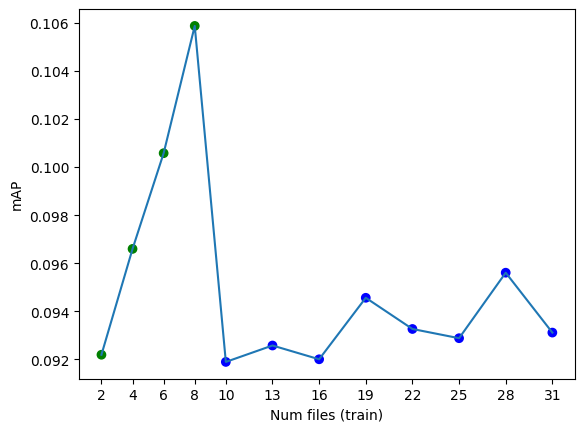

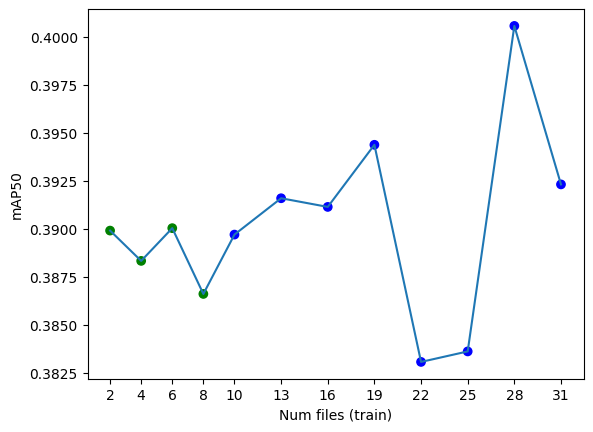

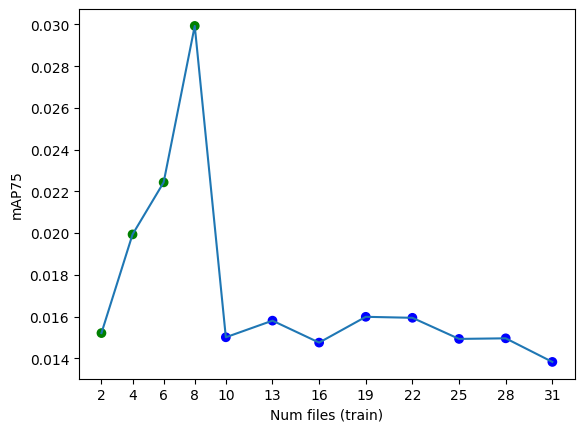

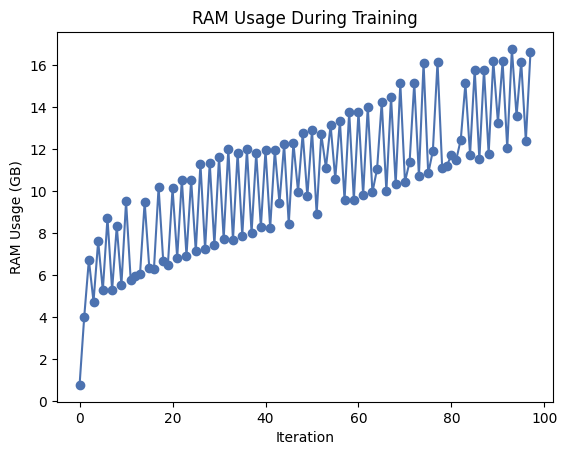

In [4]:
locale.getpreferredencoding = lambda: "UTF-8"

PATH_TO_MODEL = "/kaggle/working/yolov8m-seg.pt"
PATH_TO_YAML = "/kaggle/working/feet-14/data.yaml"
TRAIN_PERC = 0.8
TEST_PERC = 0.1
VAL_PERC = 0.1
KEEP_PERC = 1.0
PIECE_PERC = 0.05
ITERS = 5
FIB_FLAG = True
PREV_NUM = 10
THRESHOLD = 0.001

result_dict_base = dict()
result_dict_inc = dict()
color_dict_inc = dict()

exp_inc = YoloModel(PATH_TO_MODEL, PATH_TO_YAML, TRAIN_PERC, TEST_PERC, VAL_PERC)
exp_inc.increm_learning(KEEP_PERC, ITERS, PIECE_PERC, FIB_FLAG, PREV_NUM, THRESHOLD)
exp_inc.plot_ram_usage()

### Сравнение базового и инкрементального обучения

locale.getpreferredencoding = lambda: "UTF-8"

PATH_TO_MODEL = "/kaggle/working/yolov8m-seg.pt"
PATH_TO_YAML = "/kaggle/working/feet-14/data.yaml"
TRAIN_PERC = 0.8
TEST_PERC = 0.1
VAL_PERC = 0.1
KEEP_PERC = 1.0
PIECE_PERC = 0.05
ITERS = 5

result_dict_base = dict()
result_dict_inc = dict()
color_dict_inc = dict()

exp_base = YoloModel(PATH_TO_MODEL, PATH_TO_YAML, TRAIN_PERC, TEST_PERC, VAL_PERC)
result_dict_base = exp_base.base_learning(KEEP_PERC, PIECE_PERC, ITERS)
exp_base.plot_ram_usage()
del(exp_base)

exp_inc = YoloModel(PATH_TO_MODEL, PATH_TO_YAML, TRAIN_PERC, TEST_PERC, VAL_PERC, 1, 1)
result_dict_inc, color_dict_inc = exp_inc.increm_learning(KEEP_PERC, PIECE_PERC, ITERS)
exp_inc.plot_ram_usage()

import math 

map_base_list = [j[0] for j in result_dict_base.values()]
map_inc_list = [j[0] for j in result_dict_inc.values()]
mse = 0
for map_base, map_inc in zip(map_base_list, map_inc_list):
    dev = (map_base - map_inc)
    mse += dev**2
print(f"MSE = {mse}\nRMSE = {math.sqrt(mse)}")

metrics_names = ("mAP","mAP50", "mAP75")
for i, metric in enumerate(metrics_names):
    plt.plot(list(result_dict_base.keys()),
             [j[i] for j in result_dict_base.values()],
             marker='o',
             color="green",
             linestyle='-',
             zorder=0,
             label = "Базовое обучение")
    
    plt.scatter(list(result_dict_inc.keys()),
                [j[i] for j in result_dict_inc.values()],
                color=list(color_dict_inc.values()),
                zorder=1)
    plt.plot(list(result_dict_inc.keys()),
             [j[i] for j in result_dict_inc.values()],
             linestyle='-',
             label = "Инкрементальное обучение")
    
    plt.ylabel(metric)
    plt.xlabel("Keep percent (%)")
    plt.legend()
    plt.show()

num_folders = 1 / PIECE_PERC
for folder in range(int(num_folders)):
    dir_path = f"temp_{folder+1}/train/labels"
    print(dir_path, len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]))
    dir_path = f"temp_{folder+1}/train/images"
    print(dir_path, len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]))
    dir_path = f"temp_{folder+1}/valid/labels"
    print(dir_path, len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]))
    dir_path = f"temp_{folder+1}/valid/images"
    print(dir_path, len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]), '\n')
    
